# Active Learning Deep Gaussian Process Regression Monte Carlo Simulation

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/KISSGP_Deep_Kernel_Regression_CUDA.html

In [1]:
import numpy as np
import matlab.engine

import torch
from torch.nn import Sequential, Linear, ReLU, init
from torch.nn.utils import spectral_norm
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.utils.grid import ScaleToBounds
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.settings import use_toeplitz, fast_pred_var
from gpytorch.constraints.constraints import GreaterThan
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from scipy.stats import qmc
from scipy.stats import uniform, norm, lognorm, gumbel_r, \
    gamma, expon, rayleigh
import scipy.io as sio
from scipy.special import ndtri, erf

from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import random
import os.path

from bsa import bsa

In [2]:
# Set the seed for reproducibility
SEED = 42

# For NumPy
np.random.seed(SEED)

# For PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you are using multi-GPU

# For Python's built-in random module
random.seed(SEED)

# Ensuring reproducibility in cuDNN using PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Set parameters

In [3]:
N_MC = 1e6  # number of points for Monte Carlo
TRAINING_ITERATIONS = 10000  # epochs for training the DGPR
LEARNING_RATE = 0.001  # learning rate for training the model with Adam
LAYER_SIZES = [5]  # number of neurons in the hidden layers
VALIDATION_SPLIT = 6  # K-Fold split (K = VALIDATION_SPLIT)
N = 48  # initial number of points
N_INFILL = 12  # number of infill points
ALPHA = 0.05  # alpha for confidence bounds
SPECTRAL_NORMALIZATION = True
FILE_NAME = 'AL_DGPR_MCS_S01E2_Colapso'  # name to save file and plot

In [4]:
N_INITIAL_EGO = 15
N_INFILL_EGO = 15
DIM_EGO = 3  # number of hyperparameters to optimize
TRAINING_ITERATIONS_EGO = 10000
BOUNDS_BSA = (
    tuple((0, 1) for _ in range(DIM_EGO)) # the number of (0, 1) tuples has to be equal to DIM
    )
BSA_POPSIZE = 20
BSA_EPOCH = 200
BOUNDS_BAY_OPT = [[1, 5], [2, 10], [0, 4]]  # L, r, act_fun

### Random variables

In [5]:
# Wind speed
# v0 = 34.94
v0 = 38

beta = v0/10.9
mu = 7*beta

gamma_e = 0.577215664901532860606512
std = beta*np.pi/np.sqrt(6)
mean = mu + beta*gamma_e
cv = std/mean

# Converts to 10 min
mean = mean*0.72
std = mean*cv

# in 'moments': [mean, CoV], inform mean and coefficient of variation
RVs = [
    {'name': 'Wind speed',      'distribution': 'gumbel',    'moments': [mean, cv]},         # 1
    # {'name': 'f_y g50',         'distribution': 'normal',    'moments': [1.22, 0.08]},       # 2
    # {'name': 'f_y g50',         'distribution': 'lognormal', 'moments': [1.16246, 0.0418]},  # 2
    {'name': 'f_y g50',         'distribution': 'rayleigh', 'moments': [1.0695263114519873, 0.0742498104148535]},  # 2
    # {'name': 'f_y g60',         'distribution': 'normal',    'moments': [1.22, 0.08]},       # 3
    # {'name': 'f_y g60',         'distribution': 'lognormal', 'moments': [1.16246, 0.0418]},  # 3
    {'name': 'f_y g60',         'distribution': 'rayleigh', 'moments': [1.0695263114519873, 0.0742498104148535]},  # 3
    {'name': 'E',               'distribution': 'lognormal', 'moments': [1, 0.03]},          # 4
    {'name': 'E_{guys}',        'distribution': 'lognormal', 'moments': [1, 0.03]},          # 5
    {'name': 'A_{guys}',        'distribution': 'normal',    'moments': [1.03, 0.01]},       # 6
    # {'name': 'f_{u_{guys}}',    'distribution': 'normal',    'moments': [1.07, 0.015]},      # 7
    {'name': 'f_{u_{guys}}',    'distribution': 'gumbel',    'moments': [1.1864, 0.0437]},   # 7
    {'name': 'Pre-tension',     'distribution': 'gamma',     'moments': [1, 0.20]},          # 8
    {'name': 'w_{40}',          'distribution': 'normal',    'moments': [1.00075, 0.005]},   # 9
    {'name': 'w_{45}',          'distribution': 'normal',    'moments': [0.99922, 0.005]},   # 10
    {'name': 'w_{50}',          'distribution': 'normal',    'moments': [1.01800, 0.005]},   # 11
    {'name': 'w_{60}',          'distribution': 'normal',    'moments': [0.99030, 0.009]},   # 12
    {'name': 'w_{65}',          'distribution': 'normal',    'moments': [0.99030, 0.009]},   # 13
    {'name': 'w_{75}',          'distribution': 'normal',    'moments': [1.00440, 0.009]},   # 14
    {'name': 't_{3mm}',         'distribution': 'normal',    'moments': [1.0433, 0.0295]},   # 15
    {'name': 't_{4mm}',         'distribution': 'normal',    'moments': [1.0350, 0.029]},    # 16
    {'name': 't_{5mm}',         'distribution': 'normal',    'moments': [1.01, 0.0098]},     # 17
    {'name': 't_{6mm}',         'distribution': 'normal',    'moments': [1.0183, 0.022]},    # 18
    {'name': 'v',               'distribution': 'lognormal', 'moments': [1, 0.03]},          # 19
    {'name': 'd_c',             'distribution': 'normal',    'moments': [1, 0.01]},          # 20
    {'name': 'd_{gw}',          'distribution': 'normal',    'moments': [1, 0.01]},          # 21
    {'name': 'f_u g50',         'distribution': 'gumbel',    'moments': [1.1864, 0.0437]},   # 22
    {'name': 'f_u g60',         'distribution': 'gumbel',    'moments': [1.1864, 0.0437]},   # 23
    {'name': 'f_ub',            'distribution': 'normal',    'moments': [1.21, 0.0413]},     # 24
    {'name': 'A',               'distribution': 'normal',    'moments': [1, 0.129],  'bounds': [1-0.129*4,  1+0.129*4]},   # 25
    {'name': 'B',               'distribution': 'normal',    'moments': [1, 0.0855], 'bounds': [1-0.0855*4, 1+0.0855*4]},  # 26
    {'name': 'x',               'distribution': 'normal',    'moments': [1, 0.2001], 'bounds': [1-0.2001*4, 1+0.2001*4]},  # 27
    {'name': 'P',               'distribution': 'normal',    'moments': [1, 0.2234], 'bounds': [1-0.2234*4, 1+0.2234*4]},  # 28
    {'name': 'Q',               'distribution': 'normal',    'moments': [1, 0.186],  'bounds': [1-0.186*4,  1+0.186*4]},   # 29
    {'name': 'R',               'distribution': 'normal',    'moments': [1, 0.201],  'bounds': [1-0.201*4,  1+0.201*4]},   # 30
]

In [6]:
def optimization_variables(BOUNDS_BAY_OPT, X, x):
    """
    BOUNDS_BAY_OPT -> bounds for bayesian optimization (EGO)
    X -> variables from EGO (hyperparameters optimization)
    x -> sampling plan of EGRA (AL-SNDGPR-MCS)
    """
    L, r, act_fun = X[:len(BOUNDS_BAY_OPT)]
        
    # BOUNDS
    L = L*(BOUNDS_BAY_OPT[0][1] - BOUNDS_BAY_OPT[0][0]) + BOUNDS_BAY_OPT[0][0]
    r = r*(BOUNDS_BAY_OPT[1][1] - BOUNDS_BAY_OPT[1][0]) + BOUNDS_BAY_OPT[1][0]
    act_fun = act_fun*(BOUNDS_BAY_OPT[2][1] - BOUNDS_BAY_OPT[2][0]) + BOUNDS_BAY_OPT[2][0]
    
    r = int(np.round(r))
    L = int(np.round(L))
    act_fun = int(np.round(act_fun))
    
    act_fun_list = [
        torch.nn.ReLU,
        torch.nn.ELU,
        torch.nn.Tanh,
        torch.nn.GELU,
        torch.nn.Sigmoid
    ]
    
    act_fun = act_fun_list[act_fun]

    # Randomly sample hyperparameters
    spectral_normalization = SPECTRAL_NORMALIZATION
    
    layer_sizes = []
    D = x.shape[1]  # dimension of the problem
    rho = np.log(r/D) / L
    for i in range(1, L+1):
        layer_sizes.append(int(D * np.exp(rho * i)))  # Eq. 20
    
    # unique values
    myset = set(layer_sizes)
    layer_sizes = list(myset)
    
    # decreasing number of neurons per layer in architecture
    layer_sizes.sort(reverse=True)

    return layer_sizes, spectral_normalization, act_fun

In [7]:
Params = dict()
Params['RVs'] = RVs
Params['N_MC'] = N_MC
Params['training_iterations'] = TRAINING_ITERATIONS
Params['N'] = N
Params['N_added'] = N_INFILL
Params['alpha'] = ALPHA
Params['limit_state_function'] = 'S01E2 Colapso'
Params['initial_sampling_plan'] = 'LHS'
Params['learning_function'] = 'U'
Params['convergence_function'] = 'Pf_stop'
Params['seed'] = SEED

## Define the DGPR architecture

### Define the DNN architecture

In [8]:
class DNN(Sequential):
    def __init__(self, data_dim, layer_sizes, activation_fn=torch.nn.ReLU, spectral_normalization=False):
        super(DNN, self).__init__()
        
        # Define the layer configurations
        layer_size = [data_dim] + layer_sizes
        
        # Add layers dynamically
        for i in range(len(layer_size) - 1):
            in_size = layer_size[i]
            out_size = layer_size[i + 1]
            
            # Add linear layer with or without spectral normalization
            linear_layer = torch.nn.Linear(in_size, out_size)
            if spectral_normalization:
                linear_layer = spectral_norm(linear_layer)
            
            self.add_module(f'linear{i + 1}', linear_layer)
            
            # Add the chosen activation function if it's not the last layer
            if i < len(layer_size) - 2:
                self.add_module(f'activation{i + 1}', activation_fn())


        # Initialize weights using Kaiming initialization
        # Map activation functions to their corresponding Kaiming nonlinearity
        activation_to_nonlinearity = {
            torch.nn.ReLU: 'relu',
            torch.nn.LeakyReLU: 'relu',
            torch.nn.ELU: 'relu',
            torch.nn.Tanh: 'tanh',
            torch.nn.Sigmoid: 'sigmoid',
            torch.nn.Softplus: 'relu',  # No specific 'softplus', but 'relu' is a good proxy
            torch.nn.GELU: 'relu'      # Approximation
        }

        # Use the activation function to determine nonlinearity
        # activation_fn = activation_fn  # Pass or determine activation function dynamically
        nonlinearity = activation_to_nonlinearity.get(activation_fn, 'relu')  # Default to 'relu'
        
        for m in self.modules():
            if isinstance(m, Linear):
                init.kaiming_normal_(m.weight, mode='fan_out',
                                     nonlinearity=nonlinearity)
                # If your Linear layer has biases, initialize them to zero
                if m.bias is not None:
                    init.constant_(m.bias, 0)


### Define the Gaussian Process Regression model

In [9]:
class GPRegressionModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, layer_sizes, activation_fn, spectral_normalization):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        data_dim = train_x.size(-1)  # train_x is a 2D tensor [N, data_dim]

        self.spectral_normalization = spectral_normalization
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=1.5))
        self.feature_extractor = DNN(data_dim=data_dim,
                                     layer_sizes=layer_sizes,
                                     activation_fn=activation_fn,
                                     spectral_normalization=spectral_normalization)
        if not spectral_normalization:
            self.scale_to_bounds = ScaleToBounds(-1., 1.)

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        if not self.spectral_normalization:
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return MultivariateNormal(mean_x, covar_x)

### Train DGPR function

In [10]:
def train_model(train_x, train_g, val_x, val_g, training_iterations, lr, layer_sizes, activation_fn, spectral_normalization):
    # Initialize the models and likelihood
    likelihood = GaussianLikelihood(noise_constraint=GreaterThan(1e-4))
    model = GPRegressionModel(train_x=train_x, train_y=train_g, likelihood=likelihood, layer_sizes=layer_sizes,
                              activation_fn=activation_fn, spectral_normalization=spectral_normalization)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = Adam([
        {'params': model.feature_extractor.parameters()},
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # To track loss values
    training_losses = []
    validation_losses = []

    # Training loop with validation
    def train():
        best_loss, best_val_loss, best_train_loss = 1e4, 1e4, 1e4
        patience = int(training_iterations * 0.1)
        wait = 0

        for epoch in range(training_iterations):
            model.train()
            likelihood.train()

            # Zero backprop gradients
            optimizer.zero_grad()

            # Forward pass and calculate loss on training set
            output = model(train_x)
            loss = -mll(output, train_g)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            likelihood.eval()
            with torch.no_grad():
                val_output = model(val_x)
                val_loss = -mll(val_output, val_g).item()

            # Save the best model based on validation and training loss
            training_loss = loss.item()
            considered_loss = val_loss*0.5 + training_loss*0.5
            if considered_loss < best_loss:
                best_loss = considered_loss*1.0
                best_val_loss = val_loss
                best_train_loss = training_loss
                best_epoch = epoch
                # torch.save(model.state_dict(), 'best_model.pth')
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'likelihood_state_dict': likelihood.state_dict(),
                }, "best_model_and_likelihood.pth")
                wait = 0  # Reset patience counter when improvement is found
            else:
                wait += 1  # Increment patience counter if no improvement

            # Early stopping
            if wait > patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            # Track losses for plotting
            training_losses.append(loss.item())
            validation_losses.append(val_loss)

            # print(f'Epoch {epoch + 1} - Training Loss: {loss.item()} - Validation Loss: {val_loss}')

        print(f'Best Loss: {best_loss} at epoch {best_epoch}. Training loss: {best_train_loss} and val. loss: {best_val_loss}')
        return best_loss
    best_loss = train()

    # Load the best model state
    # model.load_state_dict(torch.load('best_model.pth'))
    checkpoint = torch.load("best_model_and_likelihood.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

    # Set model and likelihood to eval mode for further evaluation
    model.eval()
    likelihood.eval()

    # Plot training and validation loss
    # plt.figure(figsize=(10, 5))
    # plt.plot(training_losses, label='Training Loss')
    # plt.plot(validation_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return model, likelihood, best_loss, training_losses, validation_losses


## Definition of functions

In [11]:
def limit_state_function(x):
    """Call S01E2 vectorized progressive collapse MATLAB function"""
    eng = matlab.engine.start_matlab()
    x = np.array(x)
    x = x.tolist()
    x = matlab.double(x)
    g = eng.colapsoParalelizado(x, nargout=1)
    eng.quit()

    if isinstance(g, float):
        return torch.Tensor([g])
    return torch.Tensor(g)


In [12]:
def learning_function(g_mean, g_sigma):
    """U function"""
    return -torch.abs(g_mean / g_sigma)


In [13]:
def convergence_function(g, g_mean, gs, N, MC_sample_size):
    """Stop Pf convergence criteria"""
    # Estimate the current Pf, Pf+ and Pf-
    Pf = (torch.sum(g_mean <= 0) + torch.sum(g[N+1:] <= 0)) / MC_sample_size
    Pf_plus = (
        torch.sum(g_mean-2*gs <= 0) + torch.sum(g[N+1:] <= 0)
        ) / MC_sample_size
    Pf_minus = (
        torch.sum(g_mean+2*gs <= 0) + torch.sum(g[N+1:] <= 0)
        ) / MC_sample_size

    delta = 0.10

    # Check whether convergence has been reached for the second time in a row
    if (Pf_plus - Pf_minus) / Pf <= delta:
        print('Converged')
        return True
    return False


In [14]:
def initial_sampling_plan(num_points, variable_specs):
    """Latin Hypercube sampling plan"""
    # Number of variables and sampling points
    size = int(num_points)

    num_variables = len(variable_specs)

    # Generate LHS samples
    sampler = qmc.LatinHypercube(d=num_variables,
                                 optimization="random-cd",
                                 seed=SEED)
    lhs_sample = sampler.random(n=size)

    # Initialize an array for the transformed samples
    transformed_sample = np.zeros_like(lhs_sample)

    # Example transformations for each variable
    for i, spec in enumerate(variable_specs):
        distribution = spec['distribution'].lower()
        parameters = spec['moments']
        bounds = []
        if 'bounds' in spec.keys():
            bounds = spec['bounds']

        if distribution == 'normal' or distribution == 'gaussian':
            # Normal (Gaussian) distribution
            # Parameters: mean (mu), standard deviation (sigma)
            mean, cv = parameters
            sigma = cv * mean

            if bounds:
                Fbounds = norm.cdf(bounds, loc=mean, scale=sigma)
                Fa, Fb = Fbounds[0], Fbounds[1]
                lhs_sample[:, i] = lhs_sample[:, i]*(Fb-Fa) + Fa

            transformed_sample[:, i] = norm.ppf(lhs_sample[:, i],
                                                loc=mean, scale=sigma)

        elif distribution == 'uniform':
            # Uniform distribution
            # Parameters: lower bound (a), upper bound (b)
            a, b = parameters
            transformed_sample[:, i] = uniform.ppf(lhs_sample[:, i],
                                                   loc=a, scale=b-a)

        elif distribution == 'lognormal':
            # Lognormal distribution
            # Lognormal distribution parameters are derived from
            # the underlying normal distribution's mu and sigma
            mean, cv = parameters
            sigma = np.sqrt(np.log(cv**2 + 1))
            mu = np.exp(np.log(mean) - 0.5 * sigma**2)
            transformed_sample[:, i] = lognorm.ppf(lhs_sample[:, i],
                                                   s=sigma, scale=mu)

        elif distribution == 'gumbel':
            # Gumbel (Extreme Value Type I) distribution
            # Parameters: location (mu), scale (beta)
            mean, cv = parameters
            std = cv * mean
            beta = std * np.sqrt(6) / np.pi
            mu = mean - beta * 0.5772156649
            transformed_sample[:, i] = gumbel_r.ppf(lhs_sample[:, i],
                                                    loc=mu, scale=beta)

        elif distribution == 'gamma':
            # Gamma distribution
            # Parameters: shape (k), scale (theta)
            mean, cv = parameters
            std = cv * mean
            alfa = np.square(mean/std)  # k
            beta = mean/np.square(std)  # theta or lambda

            transformed_sample[:, i] = gamma.ppf(lhs_sample[:, i],
                                                 a=alfa, scale=1/beta)

        elif distribution == 'exponential':
            # Exponential distribution
            # Parameter: scale (1/lambda), where lambda is the rate
            scale = parameters
            transformed_sample[:, i] = expon.ppf(lhs_sample[:, i], scale=scale)

        elif distribution == 'rayleigh':
            # Shifted Rayleigh distribution
            loc, scale = parameters

            # Generating the sample and then shifting
            transformed_sample[:, i] = rayleigh.ppf(lhs_sample[:, i],
                                    loc=loc, scale=scale)

    return transformed_sample


In [15]:

def MC_sampling_plan(size, variable_specs):
    # Number of variables and sampling points
    size = int(size)

    num_variables = len(variable_specs)
    # Generate sampling points
    points = np.empty((size, num_variables))

    for i, spec in enumerate(variable_specs):
        distribution = spec['distribution'].lower()
        parameters = spec['moments']
        bounds = []
        if 'bounds' in spec.keys():
            bounds = spec['bounds']

        if distribution == 'normal' or distribution == 'gaussian':
            # Normal (Gaussian) distribution
            # Parameters: mean (mu), standard deviation (sigma)
            mean, cv = parameters
            sigma = cv * mean

            points[:, i] = np.random.uniform(low=0.0, high=1.0, size=size)

            if bounds:
                Fbounds = norm.cdf(bounds, loc=mean, scale=sigma)
                Fa, Fb = Fbounds[0], Fbounds[1]
                points[:, i] = points[:, i]*(Fb-Fa) + Fa

            points[:, i] = norm.ppf(points[:, i],
                                    loc=mean, scale=sigma)

        elif distribution == 'uniform':
            # Uniform distribution
            # Parameters: lower bound (a), upper bound (b)
            a, b = parameters
            points[:, i] = np.random.uniform(low=a, high=b, size=size)

        elif distribution == 'lognormal':
            # Lognormal distribution
            # Parameters for the underlying normal distribution: mean (mu),
            # standard deviation (sigma)
            mean, cv = parameters
            std = mean*cv
            variance = std**2
            mu = np.log(mean**2 / np.sqrt(variance + mean**2))
            sigma = np.sqrt(np.log(variance / mean**2 + 1))
            points[:, i] = np.random.lognormal(mean=mu, sigma=sigma, size=size)

        elif distribution == 'gumbel':
            # Gumbel (Extreme Value Type I) distribution
            # Parameters: location (mu), scale (beta)
            mean, cv = parameters
            std = cv * mean
            beta = std * np.sqrt(6) / np.pi
            mu = mean - beta * 0.5772156649
            points[:, i] = np.random.gumbel(loc=mu, scale=beta, size=size)

        elif distribution == 'gamma':
            # Gamma distribution
            # Parameters: shape (k), scale (theta)
            mean, cv = parameters
            std = cv * mean
            k = np.square(mean/std)
            theta = np.square(std)/mean
            points[:, i] = np.random.gamma(shape=k, scale=theta, size=size)

        elif distribution == 'exponential':
            # Exponential distribution
            # Parameter: scale (1/lambda), where lambda is the rate
            scale = parameters
            points[:, i] = np.random.exponential(scale=scale, size=size)

        elif distribution == 'rayleigh':
            # Shifted Rayleigh distribution
            loc, scale = parameters
            
            points[:, i] = np.random.uniform(low=0.0, high=1.0, size=size)
            points[:, i] = rayleigh.ppf(points[:, i],
                                    loc=loc, scale=scale)

    return points


## Initial sampling plan

In [16]:
def sample_info(variable_specs, strategies, samples):
    """Print info about the sample(s)

    Args:
        variable_specs (list): list containing dictionaries
        with info about the variables
        strategies (list): list containing strings
        which contain the strategy(ies) used to generate the sample
        samples (list): contains the sample(s)
    """

    for i in range(len(variable_specs)):
        rv = variable_specs[i]
        name = rv['name']
        distribution = rv['distribution']
        moments = rv['moments']
        mean = moments[0]
        cov = moments[1]

        print(f'RV: {name} -- mean: {mean:4.2f}, std: {mean*cov:4.2f}, \
distribution: {distribution}')

        for j in range(len(strategies)):
            x = samples[j]
            print_sample_info(strategies[j], x[:, i])
        print('')


def print_sample_info(strategy, x):
    print(f'{strategy} sample -- \
mean: {torch.mean(x):4.2f}, \
std: {torch.std(x):4.2f}, \
max: {torch.max(x):4.2f}, \
min: {torch.min(x):4.2f}')


def plot_sample_histogram(strat, x, name, dist, mean, cov, color):
    plt.hist(x, bins=1000, color=color)

    plt.grid(color='gray', linestyle='-', linewidth=0.5)
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.title(f'RV: {name} ({strat}) - {dist} distribution \
with mean {mean} and std {mean*cov}')

    fig = plt.gcf()
    fig.set_size_inches(16, 9)


### Load results from .mat file

In [17]:
mat_contents = sio.loadmat('resultados_unique.mat')

x = torch.Tensor(mat_contents['X'])
g = torch.Tensor(mat_contents['g'])
g = g[:, 0]

### Select the optimized initial sample points

In [18]:
samples = [0,   2,   3,   4,   5,   6,   7,   9,  12,  13,  14,  16,  20,  24,  28,  29,  35,  37,
    38,  40,  41,  52,  55,  64,  66,  67,  68,  69,  71,  72,  73,  74,  75,  80,  84,  85,
    86,  88,  90,  92,  95,  96,  97,  98, 103, 104, 107, 115]

if N == 60:
    samples = [1,   5,   6,  10,  11,  16,  17,  18,  21,  22,  23,  25,  26,  27,  29,  31,  33,  35,
    36,  37,  38,  39,  40,  46,  49,  52,  53,  59,  61,  62,  63,  65,  66,  68,  69,  70,
    73,  74,  76,  77,  80,  81,  82,  83,  84,  85,  86,  90,  92,  93,  94,  96,  98,  99,
    100, 108, 110, 111, 112, 117]
else:
    N = 48
x = x[samples, :]
g = g[samples]

In [19]:
# Generate MC sample
x_candidate = MC_sampling_plan(N_MC, RVs)
x_candidate = torch.Tensor(x_candidate)

In [20]:
sample_info(RVs, ['LHS', 'Monte Carlo'], [x, x_candidate])

RV: Wind speed -- mean: 19.02, std: 3.22, distribution: gumbel
LHS sample -- mean: 33.47, std: 3.55, max: 39.44, min: 26.67
Monte Carlo sample -- mean: 19.02, std: 3.22, max: 53.90, min: 11.08

RV: f_y g50 -- mean: 1.07, std: 0.08, distribution: rayleigh
LHS sample -- mean: 1.16, std: 0.04, max: 1.27, min: 1.07
Monte Carlo sample -- mean: 1.16, std: 0.05, max: 1.47, min: 1.07

RV: f_y g60 -- mean: 1.07, std: 0.08, distribution: rayleigh
LHS sample -- mean: 1.15, std: 0.05, max: 1.26, min: 1.05
Monte Carlo sample -- mean: 1.16, std: 0.05, max: 1.45, min: 1.07

RV: E -- mean: 1.00, std: 0.03, distribution: lognormal
LHS sample -- mean: 1.00, std: 0.03, max: 1.06, min: 0.94
Monte Carlo sample -- mean: 1.00, std: 0.03, max: 1.16, min: 0.86

RV: E_{guys} -- mean: 1.00, std: 0.03, distribution: lognormal
LHS sample -- mean: 0.99, std: 0.04, max: 1.07, min: 0.88
Monte Carlo sample -- mean: 1.00, std: 0.03, max: 1.16, min: 0.87

RV: A_{guys} -- mean: 1.03, std: 0.01, distribution: normal
LHS s

In [21]:
# Prepare variables
data_dim = x.shape[1]
estimate_Pf_all = []
estimate_Pf_allp = []
estimate_Pf_allm = []
estimate_N_samples_added = []
N_samples_added_total = 0
converged = False
it = 0

## Active learning

In [22]:
def MC_prediction(model, likelihood, x_candidate):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), use_toeplitz(False), fast_pred_var():
        return model(x_candidate)

In [23]:
def evaluate_lf(preds, learning_function):
    g_mean = preds.mean
    gs2 = preds.variance
    gs = torch.sqrt(gs2)
    lf = learning_function(g_mean, gs)
    
    return g_mean, gs, torch.argmax(lf)

In [24]:
def estimate_Pf(g, g_mean, gs):
    Pf = (torch.sum(g_mean <= 0) + torch.sum(g[N+1:] <= 0))/N_MC
    Pf_plus = (
        torch.sum(g_mean - gs*ndtri(1-ALPHA/2) <= 0) +
        torch.sum(g[N+1:] <= 0)
        )/N_MC
    Pf_minus = (
        torch.sum(g_mean + gs*ndtri(1-ALPHA/2) <= 0) +
        torch.sum(g[N+1:] <= 0)
        )/N_MC
    
    return Pf, Pf_plus, Pf_minus

In [25]:
def print_info(N, N_INFILL, it, Pf, Pf_plus, Pf_minus):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S %d-%m-%Y")
    print(f'Points added: {N+it} of {N+N_INFILL}')
    print(f'Current time: {current_time}')
    print(f'Pf: {Pf*100:.3f}% - Pf interval: [{Pf_minus*100:.3f}, {Pf_plus*100:.3f}]%')
    print(f'delta: {(Pf_plus - Pf_minus)*100/Pf:.3f}%')

In [26]:
def kfold_train(x, g, x_candidate, epochs, lr, layer_sizes, activation_fn, spectral_normalization, n_splits=6):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    avg_losses = []
    it = 0
    
    best_loss = 1e2

    # Split data into training and validation using KFold
    for train_idx, val_idx in kf.split(x):
        it += 1
        # Training and validation sets
        train_idx = train_idx.tolist()
        val_idx = val_idx.tolist()
        train_x, val_x = x[train_idx], x[val_idx]
        train_g, val_g = g[train_idx], g[val_idx]
        
        # Normalize based on training data:
        x_max = train_x.max(dim=0)[0]
        x_min = train_x.min(dim=0)[0]
        train_x = (train_x - x_min) / (x_max - x_min)
        val_x = (val_x - x_min) / (x_max - x_min)
        x_candidate_normalized = (x_candidate - x_min) / (x_max - x_min)

        # Train the model using the training set
        success, attempts, max_attempts = False, 0, 2
        while not success and attempts < max_attempts:
            try:
                model, likelihood, avg_loss, model_training_losses, model_validation_losses = train_model(
                    train_x, train_g, val_x, val_g, epochs, lr, layer_sizes, activation_fn, spectral_normalization)
                success = True  # Training was successful, exit loop
                print(f"  Training succeeded after {attempts + 1} attempt(s).")
            except Exception as e:
                attempts += 1
                print(f"  Error occurred during training attempt {attempts}: {e}")
                print("  Retrying training...")

                if attempts >= max_attempts:
                    print("  Max retry attempts reached. Training failed.")
                    # Optionally, continue with the next fold if training fails
                    success = False
                    break
        
        if not success:
            continue
        
        # Predict MC responses (only the sample which are not contained in the Kriging yet)
        preds = MC_prediction(model, likelihood, x_candidate_normalized)
        
        # Evaluate learning function
        g_mean, gs, _ = evaluate_lf(preds, learning_function)
        
        # Estimate Pf
        Pf, Pf_plus, Pf_minus = estimate_Pf(g, g_mean, gs)

        # Update best model
        delta = (Pf_plus - Pf_minus)/Pf
        print(f'delta = {delta*100:.2f}%, avg. loss = {avg_loss:.4f}')
        
        if avg_loss < best_loss and Pf_plus > 1e-4:
            print(f'New best model found at fold {it}:')
            print(f'    delta = {delta*100:.2f}%, avg. loss = {avg_loss:.4f}')
            print(f'    layer_sizes: {layer_sizes}, act fun: {activation_fn}\n')
            best_loss = avg_loss
            best_val_losses = model_validation_losses
            best_train_losses = model_training_losses
            best_model = model
            best_likelihood = likelihood
            best_train_x = train_x
            best_val_x = val_x
            best_train_g = train_g
            best_val_g = val_g
            best_x_max, best_x_min = x_max, x_min
            best_fold = it

        avg_losses.append(avg_loss)
        print(f'Fold: {it}, Avg. Loss: {avg_loss}\n')
    
    if len(avg_losses) == 0:
        return 1e2
    
    # Average validation loss over all folds
    avg_avg_loss = sum(avg_losses) / n_splits
    print(f'Average Loss across {n_splits} folds: {avg_avg_loss}\n')
    
    return avg_avg_loss, best_loss, best_model, best_likelihood, best_train_losses, best_val_losses, \
        best_train_x, best_val_x, best_train_g, best_val_g, best_x_max, best_x_min, best_fold

In [27]:
def obj_fun(xx):
    """
    Inputs:
        L -> number of layers
        r -> size of the latent layer
    Output:
        Best K-Fold validation
    """
    
    if len(xx.shape) == 1:
        xx = torch.reshape(xx, (1, xx.shape[0]))
    
    fobj_all = torch.zeros((xx.shape[0]))
    best_loss = 1e2
    
    for idx, X in enumerate(xx):
        layer_sizes, spectral_normalization, act_fun = optimization_variables(BOUNDS_BAY_OPT, X, x)

        print(f'Hyperparameters: {layer_sizes}, SN: {spectral_normalization}, act_fun: {act_fun.__name__}')
        
        # Train the model with the sampled hyperparameters
        fobj, loss, model, likelihood, train_losses, val_losses, train_x, val_x, train_g, val_g, x_max, x_min, \
            fold = kfold_train(
            x, g, x_candidate, TRAINING_ITERATIONS, LEARNING_RATE, layer_sizes, act_fun, spectral_normalization, n_splits=VALIDATION_SPLIT)
        print(f'obj fun (avg loss): {fobj:.2f} -> best fold: {fold}\n\n')
        
        fobj_all[idx] = fobj
        
        if fobj < best_loss:
            if best_loss < 1e2:
                print(f'New best found at OFE {idx}')
            best_loss = fobj
            best_model = model
            best_likelihood = likelihood
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_train_x, best_val_x, best_train_g, best_val_g = train_x, val_x, train_g, val_g
            best_x_max, best_x_min = x_max, x_min

    return fobj_all, best_model, best_likelihood, best_train_losses, best_val_losses, \
        best_train_x, best_val_x, best_train_g, best_val_g, best_x_max, best_x_min

In [28]:
def expected_improvement(x, model):
    """
    Function to calculate the Expected Improvement using Monte Carlo Integration.
    
    Parameters:
        x (array): Individual under evaluation.
        y (array): Valor mínimo obtido até o momento.
    
    Returns:
        array: The value of the Expected Improvement.
    """
    # Get the minimum value obtained so far
    ymin = torch.min(model.train_outputs)
    # ymin = torch.Tensor(ymin)

    # Calculate the prediction value and the variance (Ssqr)
    with torch.no_grad(), use_toeplitz(False), fast_pred_var():
        preds = model(x)
    f = preds.mean
    s = preds.variance

    # Check for any errors that are less than zero (due to numerical error)
    s[s < 0] = 0  # Set negative variances to zero

    # Calculate the RMSE (Root Mean Square Error)
    s = torch.sqrt(s)

    # Calculation of Expected Improvement
    term1 = (ymin - f) * (0.5 + 0.5 * erf((ymin - f) / (s * torch.sqrt( torch.from_numpy(np.array([2])) ))))
    term2 = (1 / torch.sqrt(2 * torch.from_numpy(np.array([np.pi])))) * s * torch.exp(-((ymin - f) ** 2) / (2 * s ** 2))
    
    return -(term1 + term2)

In [29]:
class GPRegressionModel_EGO(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel_EGO, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())
        self.scale_to_bounds = ScaleToBounds(-1., 1.)
        
        # Store train_y for later use
        self.train_outputs = train_y

    def forward(self, x):
        projected_x = self.scale_to_bounds(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return MultivariateNormal(mean_x, covar_x)

In [30]:
def train_model_EGO(train_x, train_g, val_x, val_g, training_iterations):
    # Initialize the models and likelihood
    likelihood = GaussianLikelihood()
    model = GPRegressionModel_EGO(train_x=train_x, train_y=train_g, likelihood=likelihood)

    # if torch.cuda.is_available():
    #     model = model.cuda()
    #     likelihood = likelihood.cuda()

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = Adam([
        {'params': model.covar_module.parameters()},
        {'params': model.mean_module.parameters()},
        {'params': model.likelihood.parameters()},
    ], lr=0.005)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # To track loss values
    training_losses = []
    validation_losses = []

    # Training loop with validation
    def train():
        best_loss, best_val_loss, best_train_loss = 1e4, 1e4, 1e4
        patience = int(training_iterations * 0.025)
        wait = 0

        for epoch in range(training_iterations):
            model.train()
            likelihood.train()

            # Zero backprop gradients
            optimizer.zero_grad()

            # Forward pass and calculate loss on training set
            output = model(train_x)
            loss = -mll(output, train_g)
            loss.backward()
            optimizer.step()

            # Validation step
            model.eval()
            likelihood.eval()
            with torch.no_grad():
                val_output = model(val_x)
                val_loss = -mll(val_output, val_g).item()

            # Save the best model based on validation and training loss
            training_loss = loss.item()
            final_loss = val_loss*1.0
            if final_loss < best_loss:
                best_loss = final_loss
                best_val_loss = val_loss
                best_train_loss = training_loss
                best_epoch = epoch
                # torch.save(model.state_dict(), 'best_model_GPR.pth')
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'likelihood_state_dict': likelihood.state_dict(),
                }, "best_model_and_likelihood_GPR.pth")
                wait = 0  # Reset patience counter when improvement is found
            else:
                wait += 1  # Increment patience counter if no improvement

            # Early stopping
            if wait > patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

            # Track losses for plotting
            training_losses.append(loss.item())
            validation_losses.append(val_loss)

            # print(f'Epoch {epoch + 1} - Training Loss: {loss.item()} - Validation Loss: {val_loss}')

        print(f'Best Loss: {best_loss} at epoch {best_epoch}. Training loss: {best_train_loss} and val. loss: {best_val_loss}')
        return best_val_loss, best_train_loss
    best_loss = train()

    # Load the best model state
    # model.load_state_dict(torch.load('best_model_GPR.pth'))
    checkpoint = torch.load("best_model_and_likelihood_GPR.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

    # Set model and likelihood to eval mode for further evaluation
    model.eval()
    likelihood.eval()

    # Plot training and validation loss
    # plt.figure(figsize=(4, 2))
    # plt.plot(training_losses, label='Training Loss')
    # plt.plot(validation_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return model, likelihood, best_loss

In [31]:
def bayesian_optimization(N_INITIAL_EGO, N_INFILL_EGO, DIM_EGO, TRAINING_ITERATIONS_EGO, BOUNDS_BSA, BSA_POPSIZE, BSA_EPOCH):
    x_EGO = qmc.LatinHypercube(d=DIM_EGO, optimization="random-cd", seed=SEED)
    lhs_sample = x_EGO.random(n=N_INITIAL_EGO)
    x_EGO = torch.from_numpy(lhs_sample)
    x_EGO = x_EGO.to(torch.float32)
    
    f_EGO, best_model, best_likelihood, best_train_losses, best_val_losses, \
          train_x, val_x, train_g, val_g, best_x_max, best_x_min = \
        obj_fun(x_EGO)
    f_EGO = f_EGO.view(N_INITIAL_EGO)
    
    overall_best_model = best_model
    overall_best_likelihood = best_likelihood
    overall_best_train_losses = best_train_losses
    overall_best_val_losses = best_val_losses
    overall_best_train_x, overall_best_val_x = train_x, val_x
    overall_best_train_g, overall_best_val_g = train_g, val_g
    overall_best_x_max, overall_best_x_min = best_x_max, best_x_min

    train_x_EGO, val_x_EGO, train_g_EGO, val_g_EGO = train_test_split(
        x_EGO, f_EGO, random_state=SEED, test_size=0.20)

    model, likelihood, best_loss = train_model_EGO(
        train_x_EGO, train_g_EGO, val_x_EGO, val_g_EGO, TRAINING_ITERATIONS_EGO)
    model.eval()
    likelihood.eval()

    it = 0
    print(f'\nIteration {it}. Best of DGPR: {torch.min(f_EGO)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')

    while it < N_INFILL_EGO:
        it += 1
        
        # Search for the maximum expected improvement
        new_point = bsa(expected_improvement, bounds=BOUNDS_BSA,
                        popsize=BSA_POPSIZE, epoch=BSA_EPOCH, data=model)
        x_new = torch.from_numpy(new_point.x)
        # EI = new_point.y

        # Objective function at the new point
        f_new, best_model, best_likelihood, best_train_losses, best_val_losses, \
            train_x, val_x, train_g, val_g, best_x_max, best_x_min = obj_fun(x_new)
        f_new = f_new.view(-1)
        
        print(f'Iteration {it} of {N_INFILL_EGO}')
        if f_new < torch.min(f_EGO):
            print(f'New best: {float(f_new):.2f} at position {it}')
            overall_best_model = best_model
            overall_best_likelihood = best_likelihood
            overall_best_train_losses = best_train_losses
            overall_best_val_losses = best_val_losses
            overall_best_train_x, overall_best_val_x = train_x, val_x
            overall_best_train_g, overall_best_val_g = train_g, val_g
            overall_best_x_max, overall_best_x_min = best_x_max, best_x_min
        
        # Add new values to the initial sampling
        x_EGO = torch.cat((x_EGO, torch.from_numpy(np.array([np.asarray(x_new)]))), 0)
        x_EGO = x_EGO.to(torch.float32)
        f_EGO = torch.cat((f_EGO, f_new), 0)
        
        # Update model
        train_x_EGO, val_x_EGO, train_g_EGO, val_g_EGO = train_test_split(x_EGO, f_EGO, random_state=SEED, test_size=0.20)
        model, likelihood, best_loss = train_model_EGO(train_x_EGO, train_g_EGO, val_x_EGO, val_g_EGO, TRAINING_ITERATIONS)
        model.eval()
        likelihood.eval()
        
        print(f'\nIteration {it}. Best of DGPR: {torch.min(f_EGO)}. GPR model: Train loss = {best_loss[0]}; Val. loss = {best_loss[-1]}')
        
        # if abs(EI) < TOL_MIN_EI:
        #     print('Optimization finished. Minimum tolerance achieved.')
        #     break

    print(f'f*: {torch.min(f_EGO):.2f}; x*: {x_EGO[torch.argmin(f_EGO), :]}\n')
    
    # FINAL RESULT OF BAYESIAN OPTIMIZATION
    X = x_EGO[torch.argmin(f_EGO), :]
    layer_sizes, spectral_normalization, act_fun = optimization_variables(BOUNDS_BAY_OPT, X, x)

    print(f'Loss: {torch.min(f_EGO):.2f}, Hyperparameters: {layer_sizes}, SN: {spectral_normalization}, act_fun: {act_fun.__name__}')
    
    return f_EGO, x_EGO, overall_best_model, overall_best_likelihood, overall_best_train_losses, overall_best_val_losses, \
        overall_best_train_x, overall_best_val_x, overall_best_train_g, overall_best_val_g, overall_best_x_max, overall_best_x_min

In [32]:
def save_bests(best_model, best_likelihood, best_training_losses, best_validation_losses,
               train_x, val_x, train_g, val_g, x_EGO, f_EGO, x_max, x_min):
    torch.save(best_model.state_dict(), f'best_model_{it}.pth')
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'likelihood_state_dict': best_likelihood.state_dict(),
    }, f"best_model_and_likelihood_{it}.pth")

    layer_sizes, sn, act_fun = optimization_variables(BOUNDS_BAY_OPT, x_EGO[torch.argmin(f_EGO), :], x)

    name = 'variables_best_' + act_fun.__name__ + '_SN_' + str(sn) + str(it) + '.mat'
    sio.savemat(name, {
        'best_training_losses': np.array(best_training_losses),
        'best_validation_losses': np.array(best_validation_losses),
        'x_EGO': x_EGO.numpy(),
        'f_EGO': f_EGO.numpy(),
        'layer_sizes': np.array(layer_sizes),
        'train_x': np.array(train_x),
        'val_x': np.array(val_x),
        'train_g': np.array(train_g),
        'val_g': np.array(val_g),
        'x_max': np.array(x_max),
        'x_min': np.array(x_min),
        })

    # layer_sizes, spectral_normalization, act_fun = optimization_variables(BOUNDS_BAY_OPT, x_EGO, x)
    
    # numpy_array = np.array(best_training_losses)
    # name = 'best_training_losses' + str(it) + '.mat'
    # sio.savemat(name, {'best_training_losses': numpy_array})
    
    # numpy_array = np.array(best_validation_losses)
    # name = 'best_validation_losses' + str(it) + '.mat'
    # sio.savemat(name, {'best_validation_losses': numpy_array})
    
    # Load the saved state
    # checkpoint = torch.load(f"best_model_and_likelihood_{it}.pth")
    # model.load_state_dict(checkpoint['model_state_dict'])
    # likelihood.load_state_dict(checkpoint['likelihood_state_dict'])

In [33]:
def plot_losses(tloss, vloss, it):
    # Plot training and validation loss
    # plt.figure(figsize=(4, 2))
    # plt.plot(training_losses, label='Training Loss')
    # plt.plot(validation_losses, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss Over Epochs')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    plt.figure(figsize=(16, 10), dpi=300)
    font_size = 32
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["font.family"] = "Times New Roman"
    tloss, vloss = np.array(tloss), np.array(vloss)
    plt.plot(tloss, label='Training Loss', color='blue', linewidth=3)
    plt.plot(vloss, label='Validation Loss', color='red', linestyle="--", linewidth=3)
    
    # Axes and grid lines
    plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
    plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
    
    # Calculate the combined loss and find the minimum point
    combined_loss = 0.5 * tloss + vloss + 0.5
    min_index_comb = np.argmin(combined_loss)
    min_index = np.argmin(vloss)
    
    # Add vertical line at the minimum combined loss
    plt.axvline(min_index_comb, color='purple', linestyle=':', label='Min. avg. loss')
    plt.axvline(min_index, color='green', linestyle='-.', label='Min. val. loss')
    
    # Titles and labels
    plt.title("Loss during training", fontsize=font_size + 4)
    plt.xlabel("Epochs", fontsize=font_size)
    plt.ylabel("Loss", fontsize=font_size)

    # Legend and grid
    plt.legend(fontsize=font_size)
    plt.grid()
    plt.show()
    fig = plt.gcf()
    fig.savefig('Loss' + str(it) + '.png', dpi=300)

In [34]:
def normalize_MC(x_max, x_min, x_candidate):
    return (x_candidate - x_min) / (x_max - x_min)

In [35]:
def save_x_added(x_added, it):
    numpy_array = x_added.numpy()
    name = 'x' + str(it) + '.mat'
    sio.savemat(name, {'x': numpy_array})
    print(x_added)

In [36]:
def evaluate_g(x_added, it, limit_state_function):
    name = 'g' + str(it-1) + '.mat'
    path = './' + name
    check_file = os.path.isfile(path)

    if check_file:
        mat_contents = sio.loadmat(path)
        g_added = mat_contents['g']
        g_added = torch.Tensor(g_added)
        g_added = g_added.view(-1)
    else:
        # Add the selected sample to the experimental design
        g_added = limit_state_function(x_added)  # calls MATLAB code
        g_added = torch.Tensor(g_added)
        
        numpy_array = g_added.numpy()
        sio.savemat(name, {'g': numpy_array})
    print(g_added)
    return g_added


Iteration 0
Hyperparameters: [23, 17, 13, 10, 8], SN: True, act_fun: ELU
Early stopping at epoch 7827
Best Loss: -1.8832030892372131 at epoch 6825. Training loss: -2.187379837036133 and val. loss: -1.5790263414382935
  Training succeeded after 1 attempt(s).
delta = 24.87%, avg. loss = -1.8832
New best model found at fold 1:
    delta = 24.87%, avg. loss = -1.8832
    layer_sizes: [23, 17, 13, 10, 8], act fun: <class 'torch.nn.modules.activation.ELU'>

Fold: 1, Avg. Loss: -1.8832030892372131

Early stopping at epoch 6529
Best Loss: -1.2762423753738403 at epoch 5527. Training loss: -1.6614711284637451 and val. loss: -0.8910136222839355
  Training succeeded after 1 attempt(s).
delta = 45.05%, avg. loss = -1.2762
Fold: 2, Avg. Loss: -1.2762423753738403

Early stopping at epoch 6126
Best Loss: -1.13585364818573 at epoch 5124. Training loss: -1.4769082069396973 and val. loss: -0.7947990894317627
  Training succeeded after 1 attempt(s).
delta = 61.09%, avg. loss = -1.1359
Fold: 3, Avg. Loss:

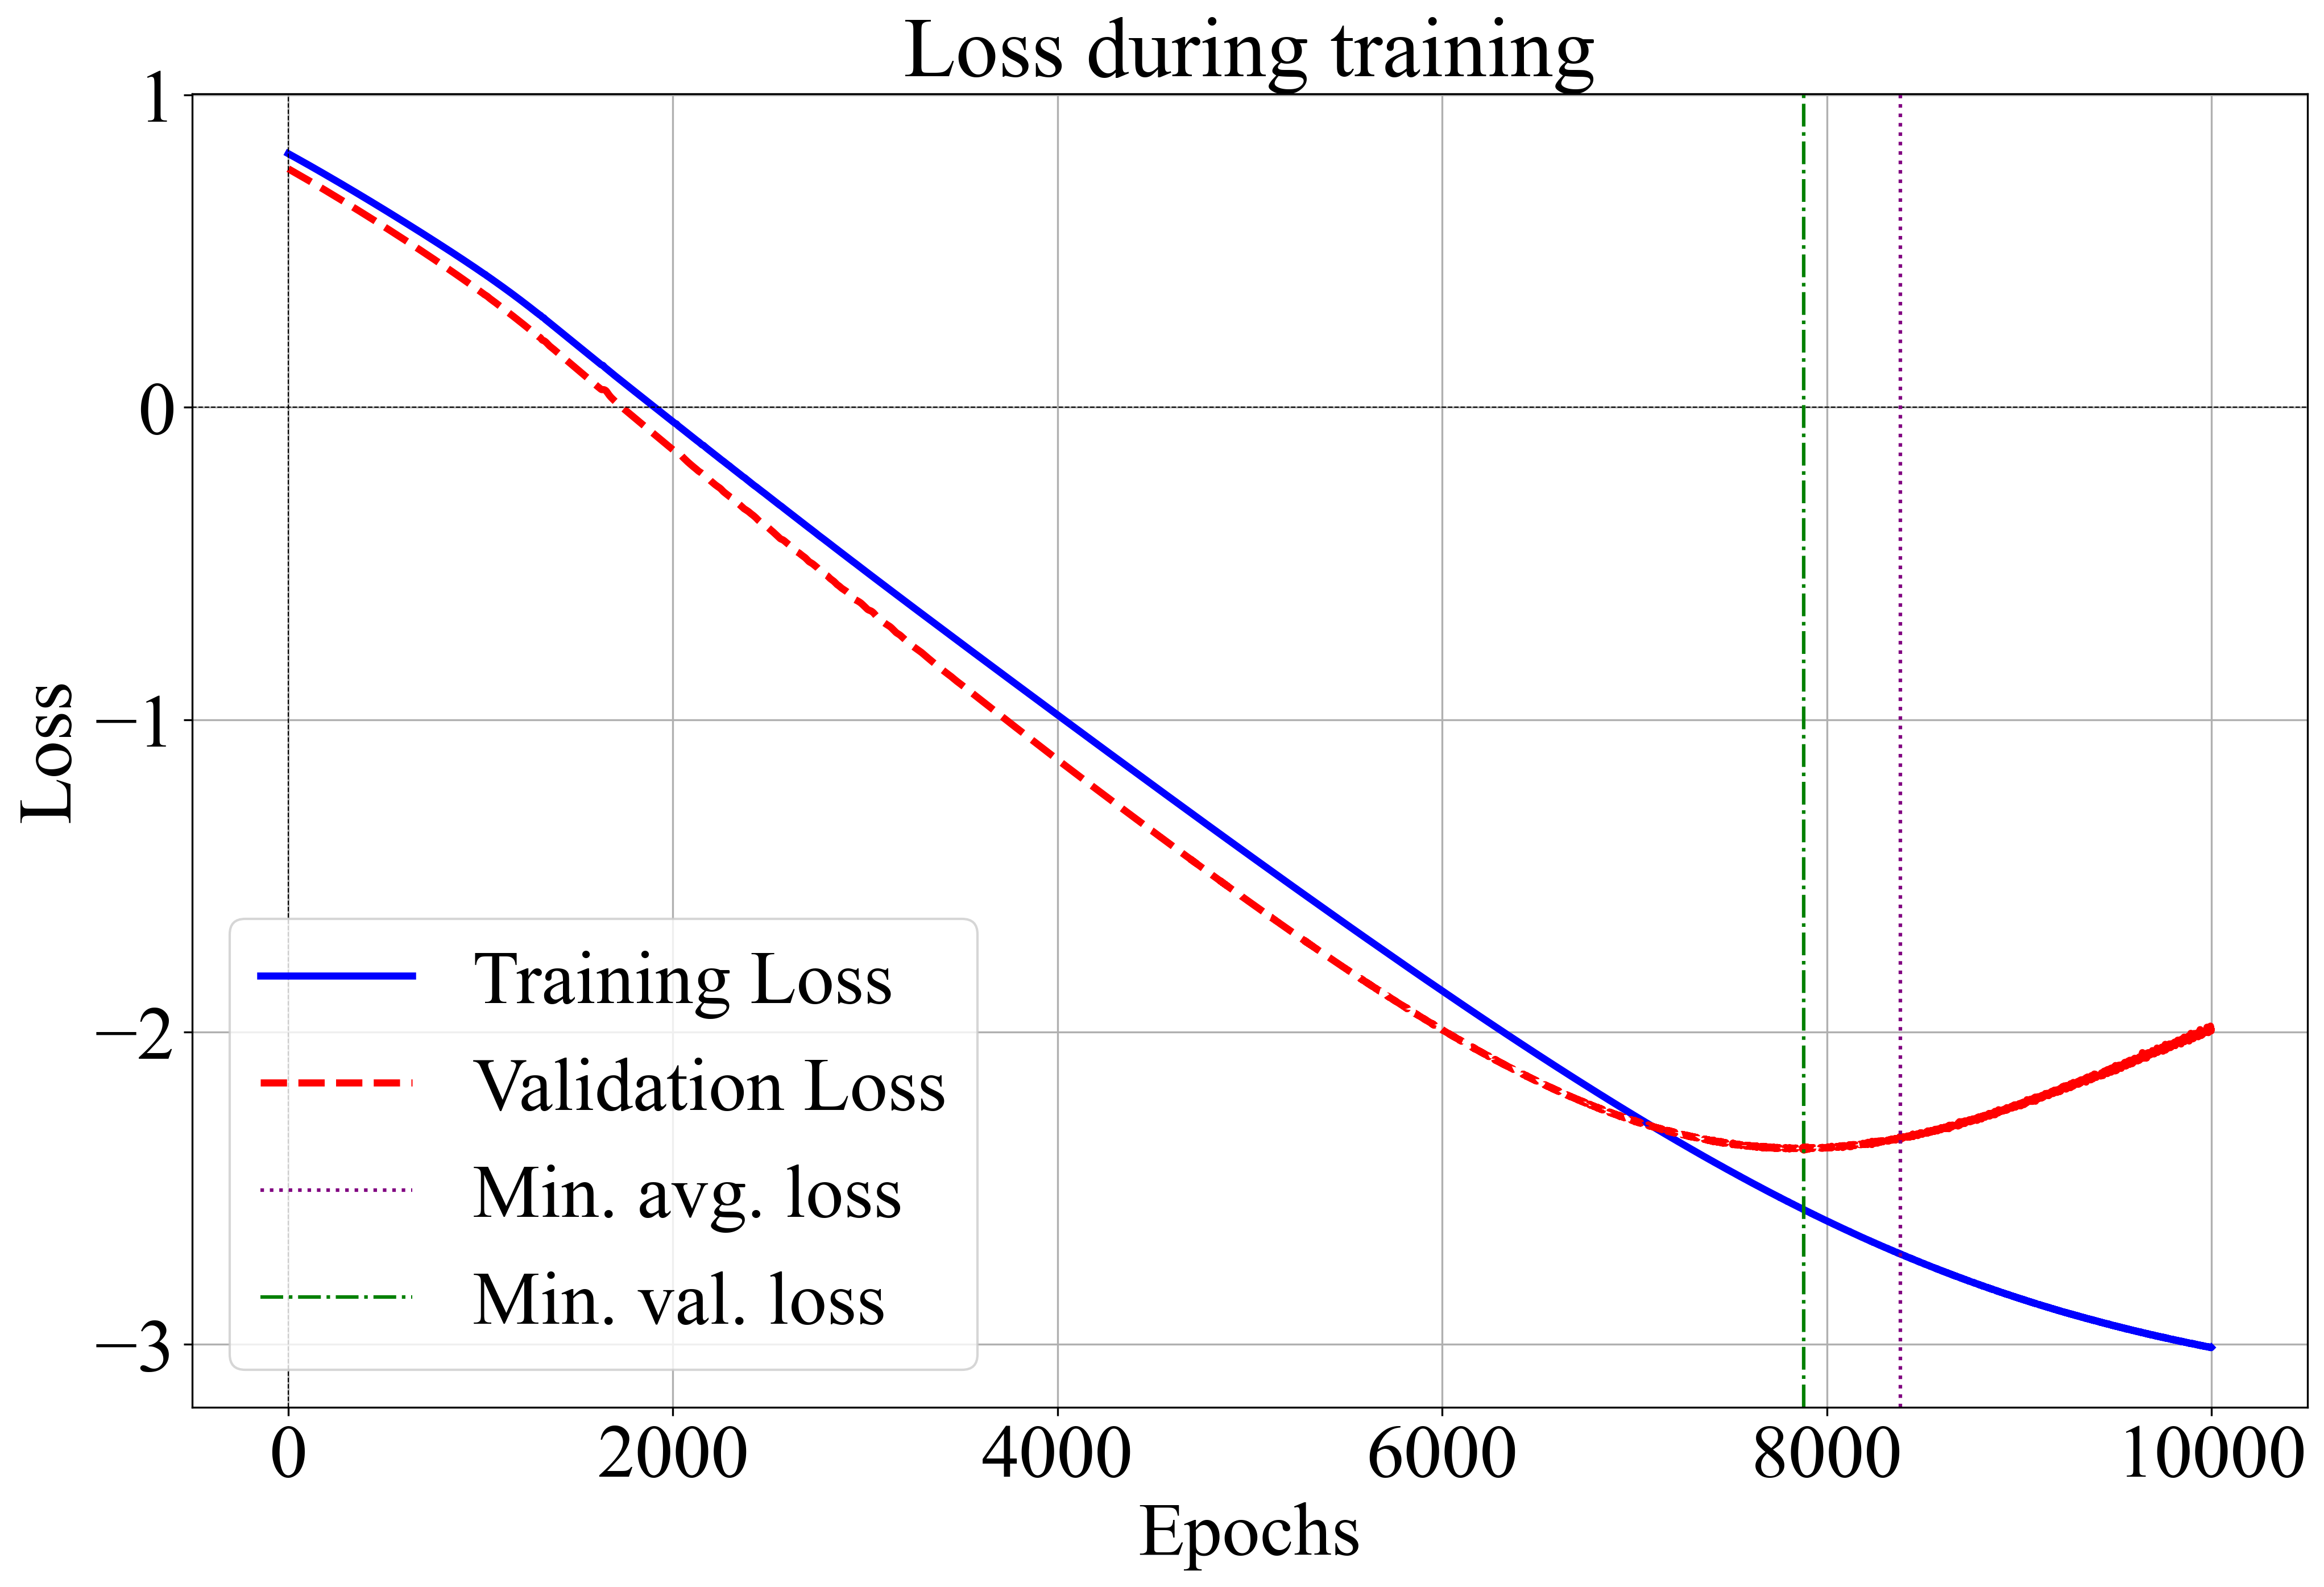

tensor([[34.8565,  1.2367,  1.1891,  0.9917,  1.0400,  1.0253,  1.1242,  1.1261,
          0.9980,  1.0010,  1.0232,  0.9898,  1.0004,  1.0018,  1.0070,  1.0102,
          1.0190,  1.0176,  0.9931,  0.9964,  1.0095,  1.2315,  1.3437,  1.1903,
          1.3053,  0.9928,  0.8244,  0.9336,  0.8972,  0.7555]])
Points added: 48 of 60
Current time: 23:09:28 12-12-2024
Pf: 0.135% - Pf interval: [0.127, 0.146]%
delta: 14.096%
tensor([0.0054])

Iteration 1
Early stopping at epoch 6756
Best Loss: -1.3851752281188965 at epoch 5754. Training loss: -1.7626250982284546 and val. loss: -1.0077253580093384
  Training succeeded after 1 attempt(s).
delta = 43.02%, avg. loss = -1.3852
New best model found at fold 1:
    delta = 43.02%, avg. loss = -1.3852
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.3851752281188965

Early stopping at epoch 6742
Best Loss: -1.3913022875785828 at epoch 5740. Training loss: -1.7691211700439453 and val. loss: 

<Figure size 640x480 with 0 Axes>

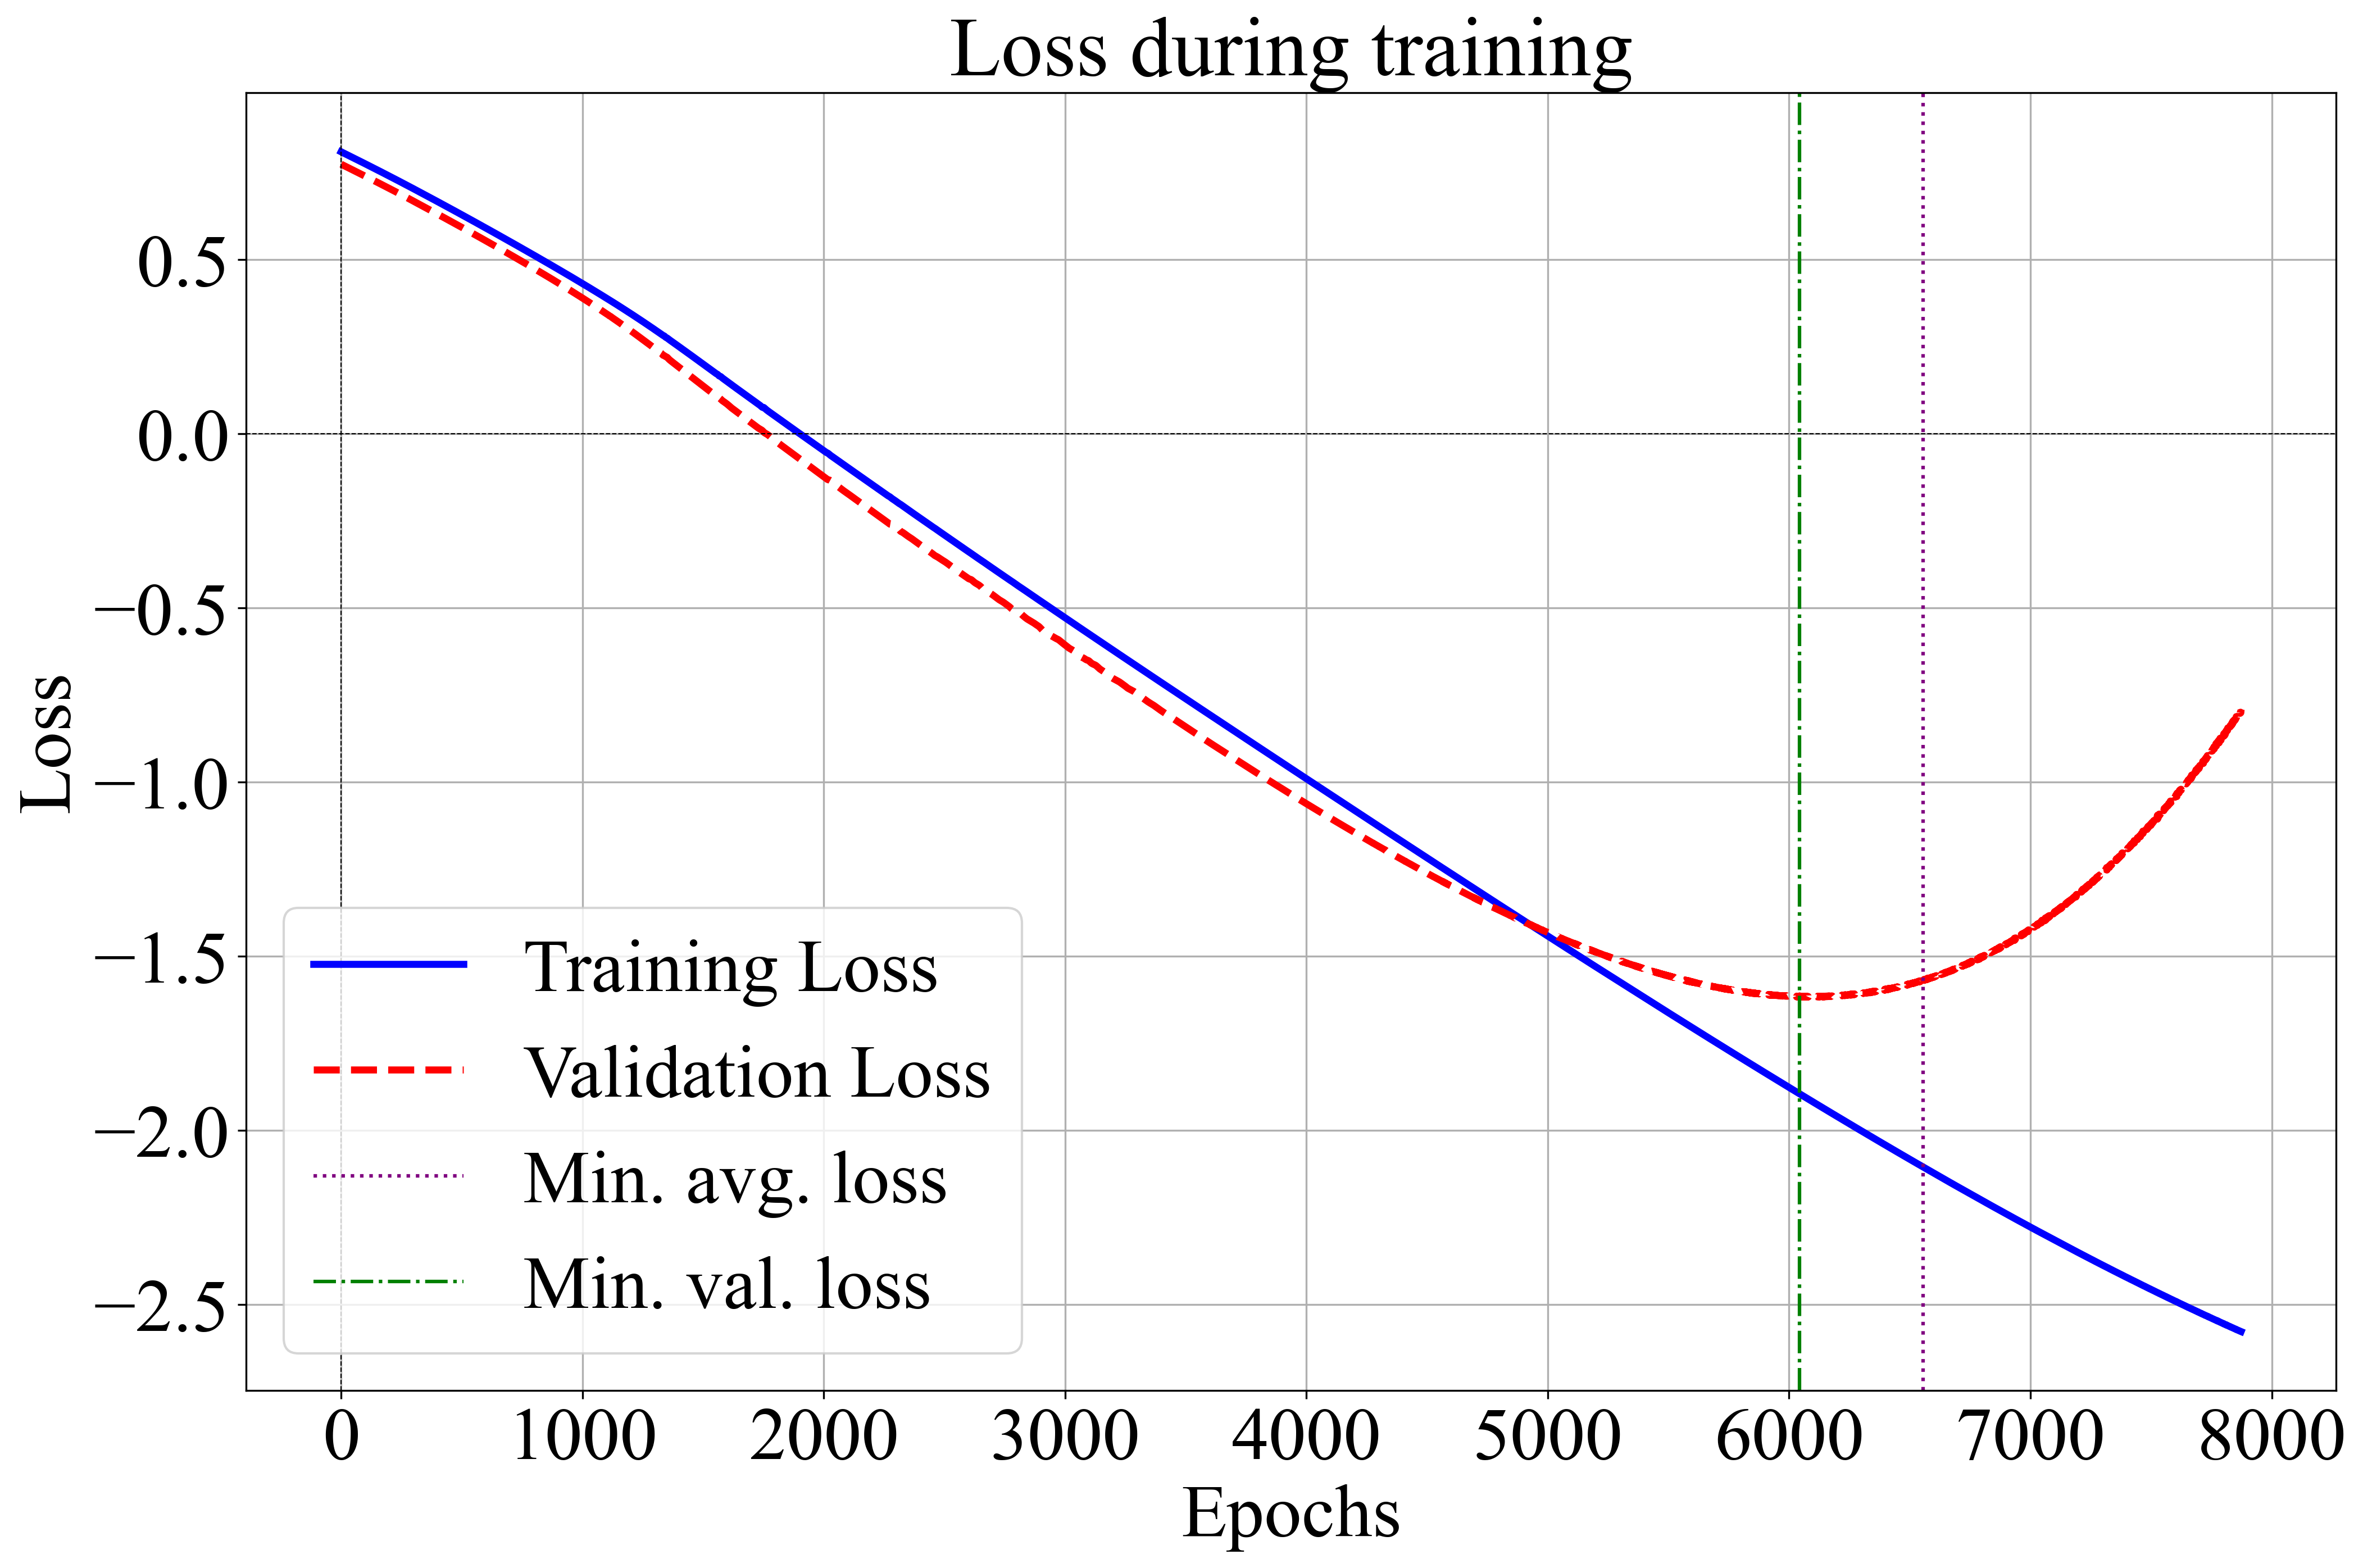

tensor([[36.2552,  1.1690,  1.1783,  1.0303,  1.0230,  1.0365,  1.2644,  1.0071,
          0.9987,  0.9958,  1.0222,  1.0054,  1.0006,  0.9985,  1.0546,  1.0137,
          1.0099,  1.0422,  1.0189,  0.9970,  0.9934,  1.1221,  1.1842,  1.2157,
          0.8276,  0.9764,  0.7439,  1.0899,  1.0529,  0.6885]])
Points added: 49 of 60
Current time: 23:17:55 12-12-2024
Pf: 0.153% - Pf interval: [0.134, 0.176]%
delta: 27.462%
tensor([-0.0752])

Iteration 2
Early stopping at epoch 6651
Best Loss: -1.3598833680152893 at epoch 5649. Training loss: -1.7236961126327515 and val. loss: -0.9960706233978271
  Training succeeded after 1 attempt(s).
delta = 43.13%, avg. loss = -1.3599
New best model found at fold 1:
    delta = 43.13%, avg. loss = -1.3599
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.3598833680152893

Early stopping at epoch 7478
Best Loss: -1.703610122203827 at epoch 6476. Training loss: -2.076875925064087 and val. loss: -

<Figure size 640x480 with 0 Axes>

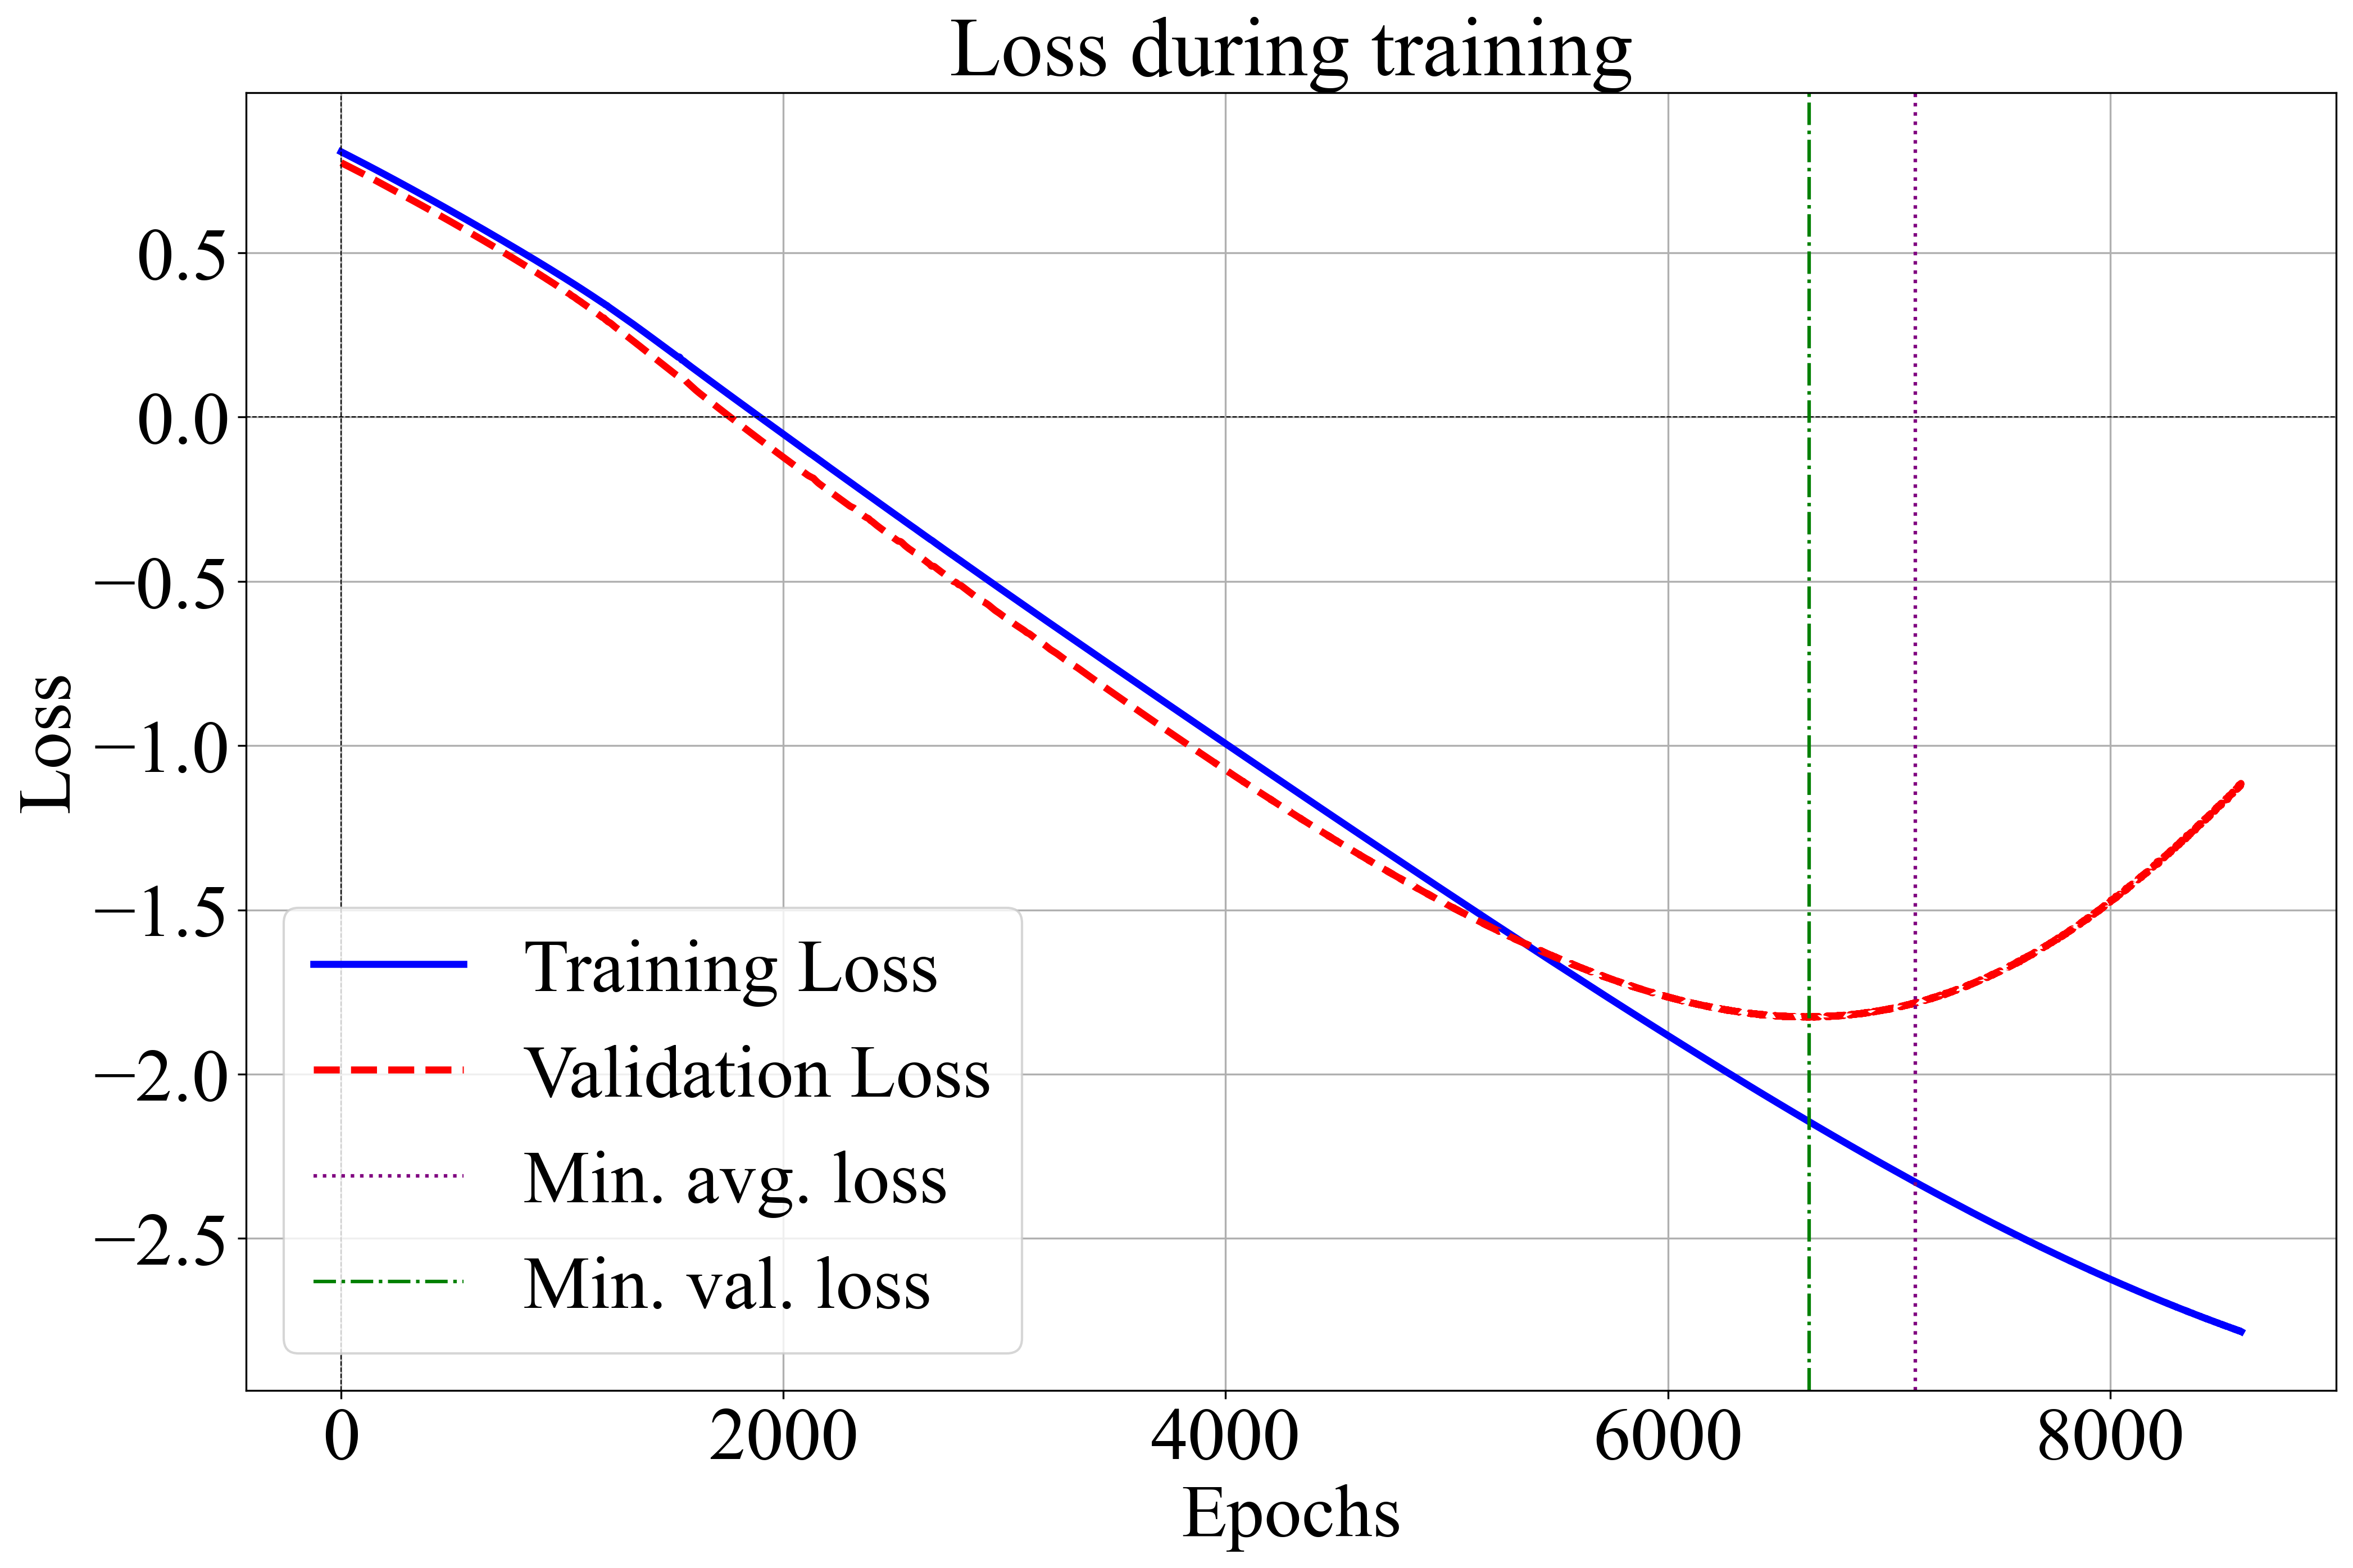

tensor([[31.6380,  1.2415,  1.1399,  0.9941,  0.9864,  1.0264,  1.1459,  1.0997,
          0.9993,  1.0010,  1.0203,  0.9831,  1.0081,  0.9966,  1.0059,  1.0498,
          1.0076,  1.0069,  1.0113,  1.0115,  1.0020,  1.2898,  1.2277,  1.2832,
          0.9966,  1.0610,  1.0513,  0.9523,  0.8873,  1.1053]])
Points added: 50 of 60
Current time: 23:57:57 24-12-2024
Pf: 0.138% - Pf interval: [0.126, 0.155]%
delta: 20.682%
tensor([0.0949])

Iteration 3
Early stopping at epoch 8578
Best Loss: -2.1633729934692383 at epoch 7576. Training loss: -2.485581874847412 and val. loss: -1.8411641120910645
  Training succeeded after 1 attempt(s).
delta = 17.76%, avg. loss = -2.1634
New best model found at fold 1:
    delta = 17.76%, avg. loss = -2.1634
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -2.1633729934692383

Early stopping at epoch 7642
Best Loss: -1.7789521217346191 at epoch 6640. Training loss: -2.1496968269348145 and val. loss: -

<Figure size 640x480 with 0 Axes>

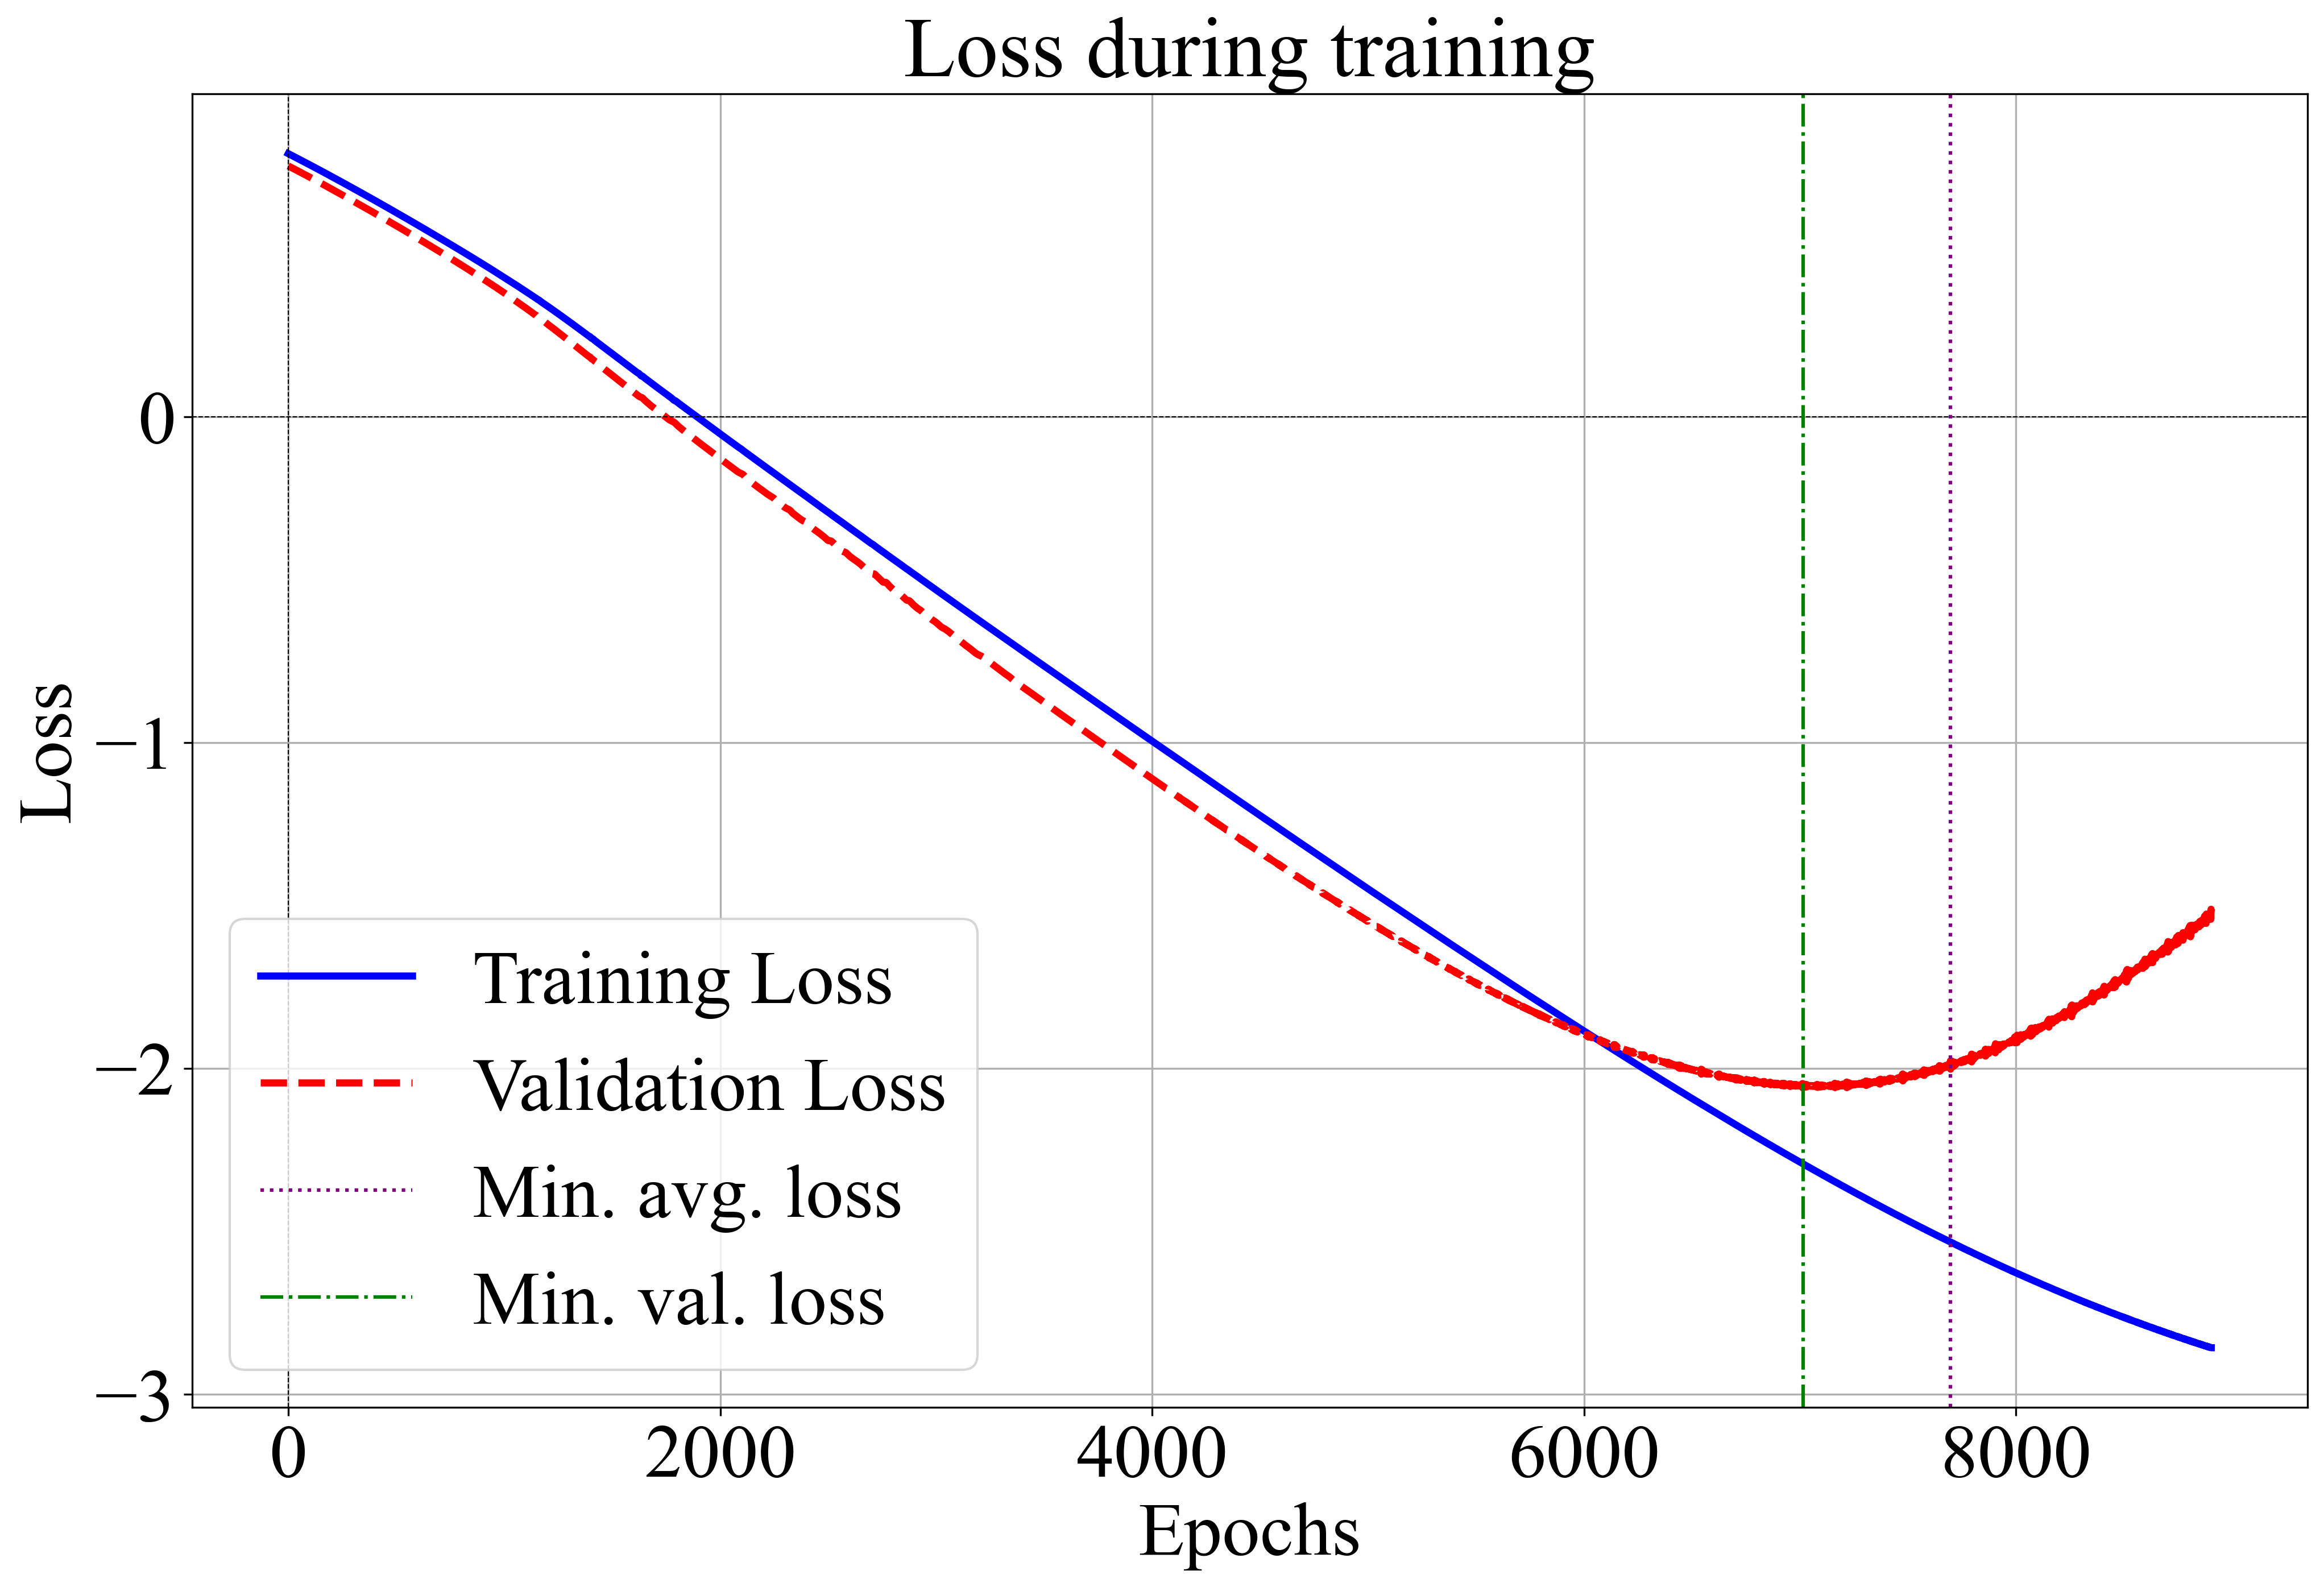

tensor([[34.0771,  1.1777,  1.2331,  0.9864,  1.0003,  1.0500,  1.1588,  1.0268,
          0.9983,  0.9970,  1.0190,  0.9995,  0.9877,  1.0078,  1.0239,  1.0627,
          1.0154,  1.0521,  0.9905,  0.9928,  1.0012,  1.3093,  1.3051,  1.2537,
          0.8689,  0.8347,  0.6117,  0.9303,  1.1816,  0.8813]])
Points added: 51 of 60
Current time: 00:08:04 26-12-2024
Pf: 0.127% - Pf interval: [0.118, 0.138]%
delta: 15.391%
tensor([0.0096])

Iteration 4
Early stopping at epoch 7966
Best Loss: -1.9261035919189453 at epoch 6964. Training loss: -2.274348735809326 and val. loss: -1.5778584480285645
  Training succeeded after 1 attempt(s).
delta = 21.26%, avg. loss = -1.9261
New best model found at fold 1:
    delta = 21.26%, avg. loss = -1.9261
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.9261035919189453

Early stopping at epoch 7728
Best Loss: -1.8030350804328918 at epoch 6726. Training loss: -2.189533233642578 and val. loss: -1

<Figure size 640x480 with 0 Axes>

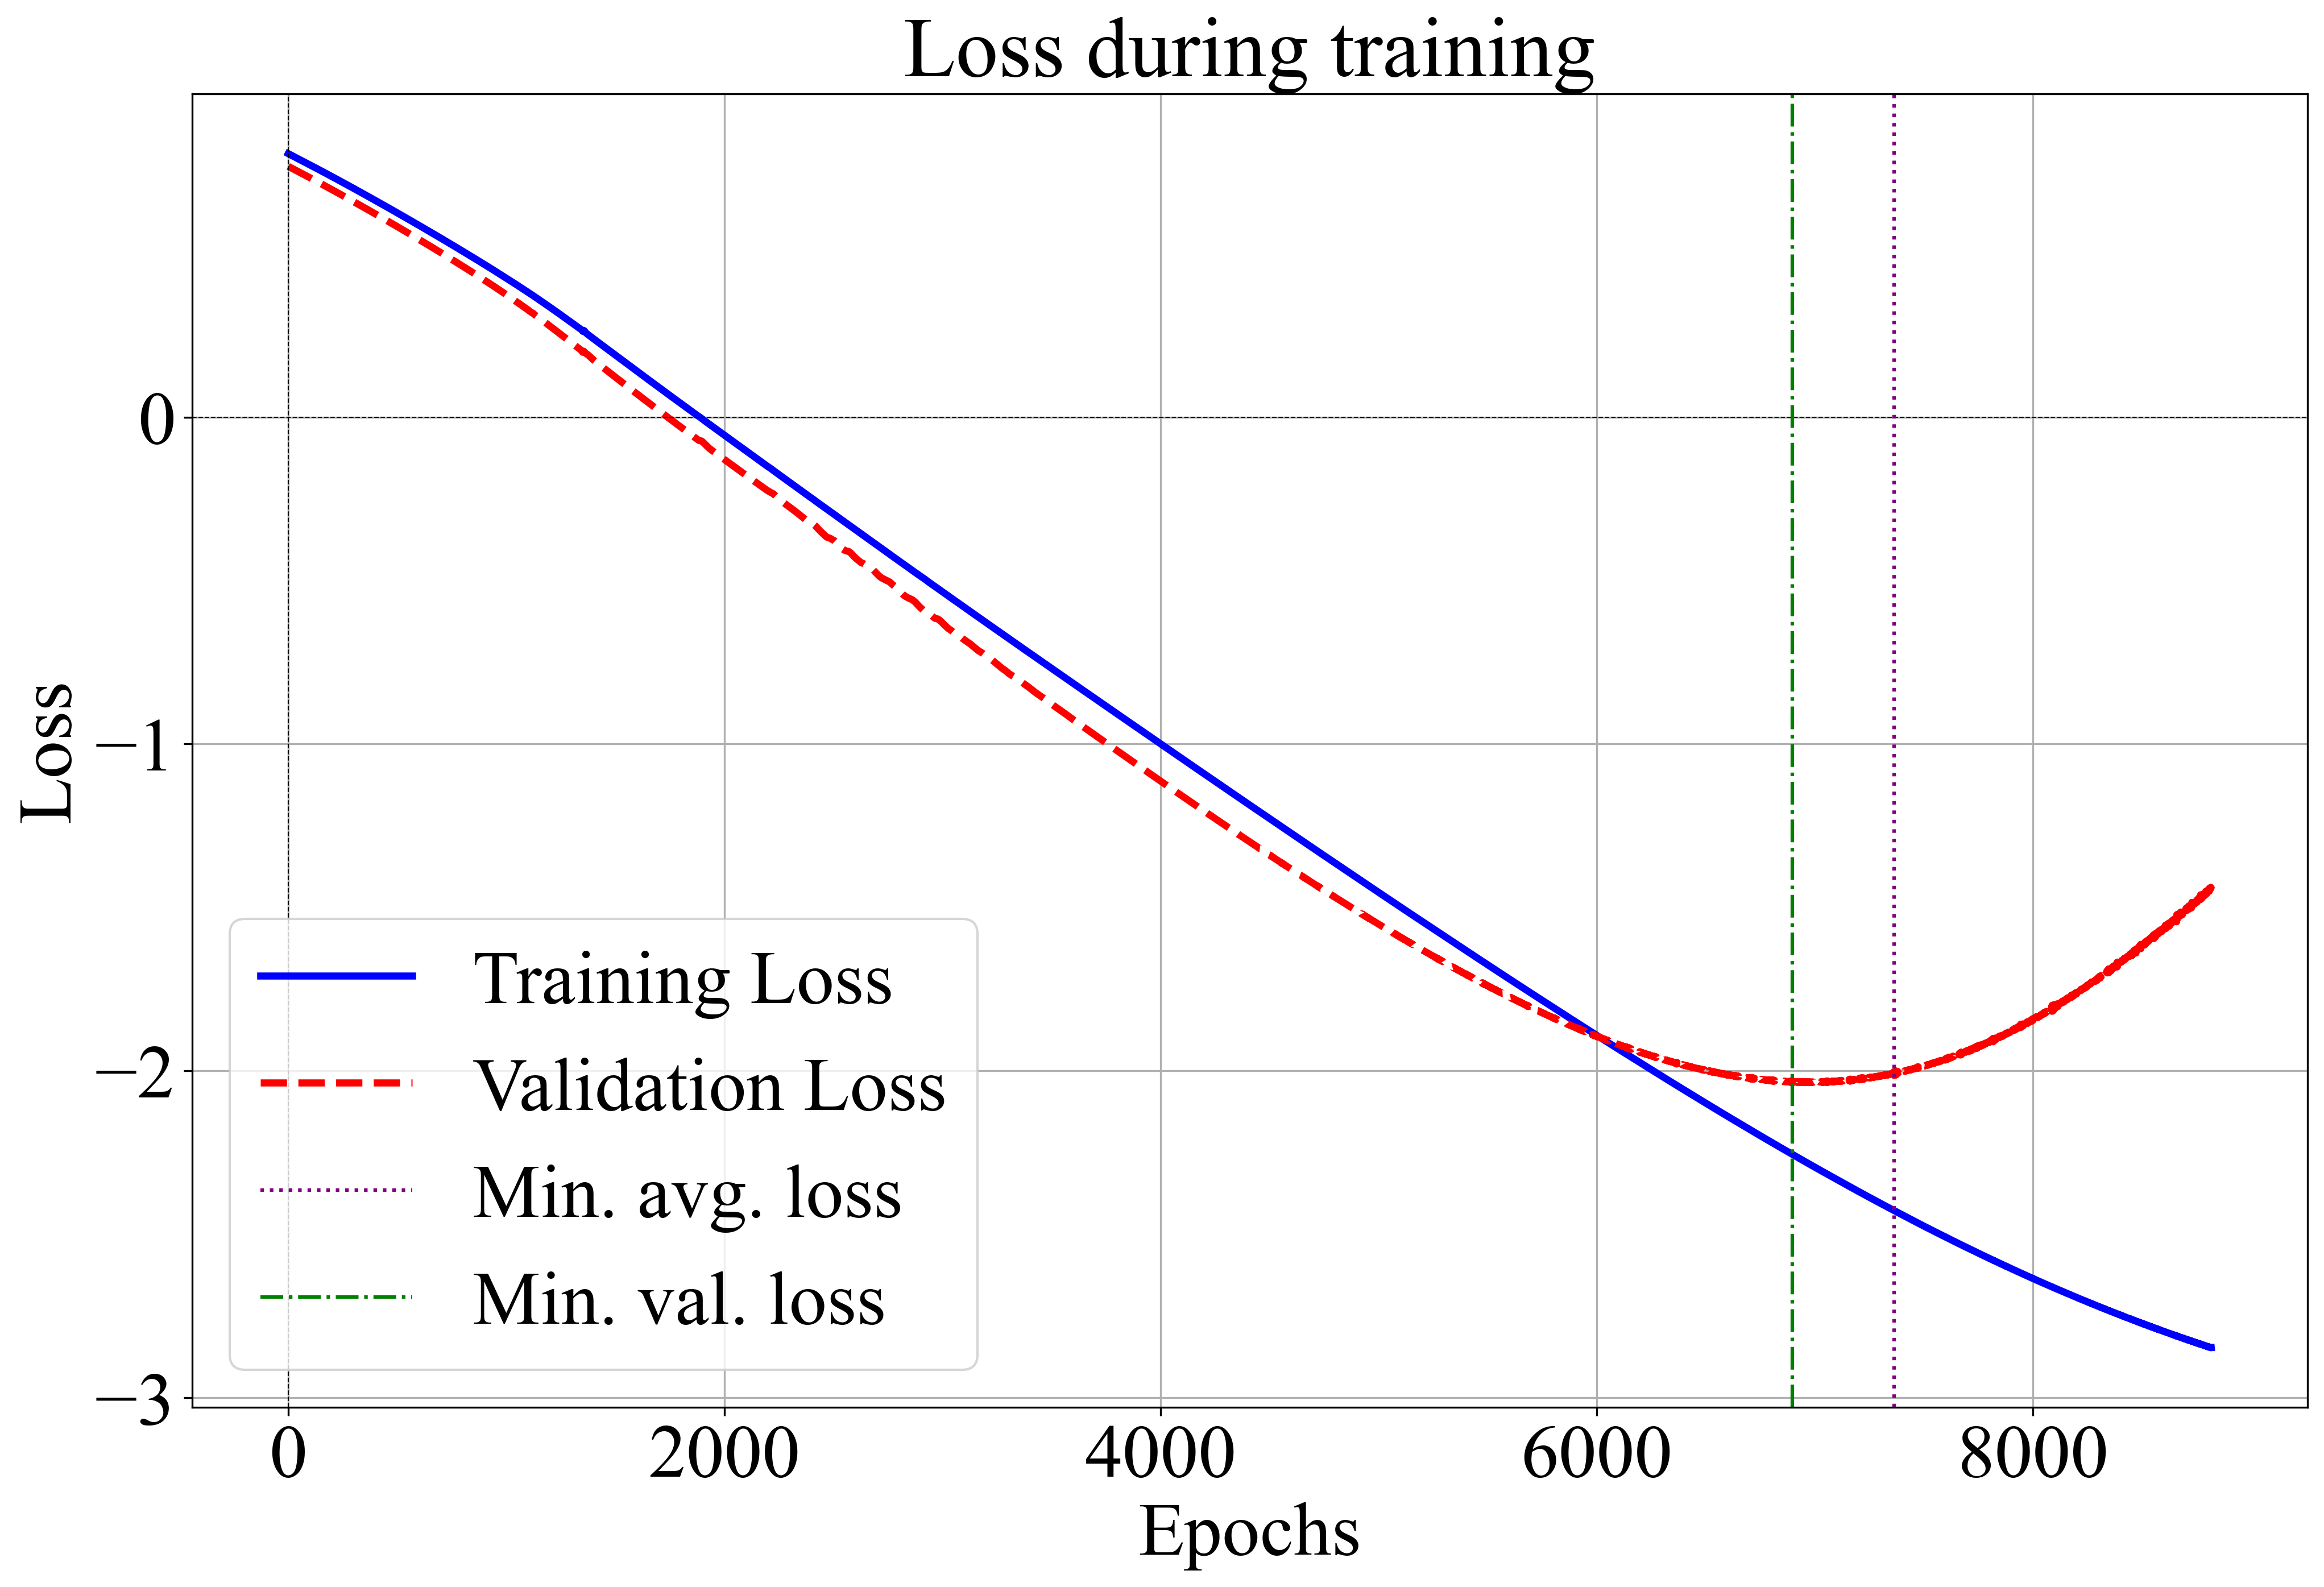

tensor([[34.0123,  1.0840,  1.1727,  1.0006,  0.9795,  1.0235,  1.1641,  0.8505,
          1.0007,  1.0089,  1.0133,  0.9945,  0.9868,  1.0048,  1.0568,  0.9653,
          0.9976,  0.9931,  1.0751,  0.9976,  0.9953,  1.1992,  1.1680,  1.2527,
          0.9092,  0.9675,  1.4645,  0.9248,  1.1388,  1.1556]])
Points added: 52 of 60
Current time: 17:24:22 26-12-2024
Pf: 0.126% - Pf interval: [0.116, 0.136]%
delta: 15.873%
tensor([0.0102])

Iteration 5
Early stopping at epoch 8256
Best Loss: -2.0335381031036377 at epoch 7254. Training loss: -2.387974739074707 and val. loss: -1.6791014671325684
  Training succeeded after 1 attempt(s).
delta = 17.52%, avg. loss = -2.0335
New best model found at fold 1:
    delta = 17.52%, avg. loss = -2.0335
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -2.0335381031036377

Early stopping at epoch 7580
Best Loss: -1.7624251246452332 at epoch 6578. Training loss: -2.1360080242156982 and val. loss: -

<Figure size 640x480 with 0 Axes>

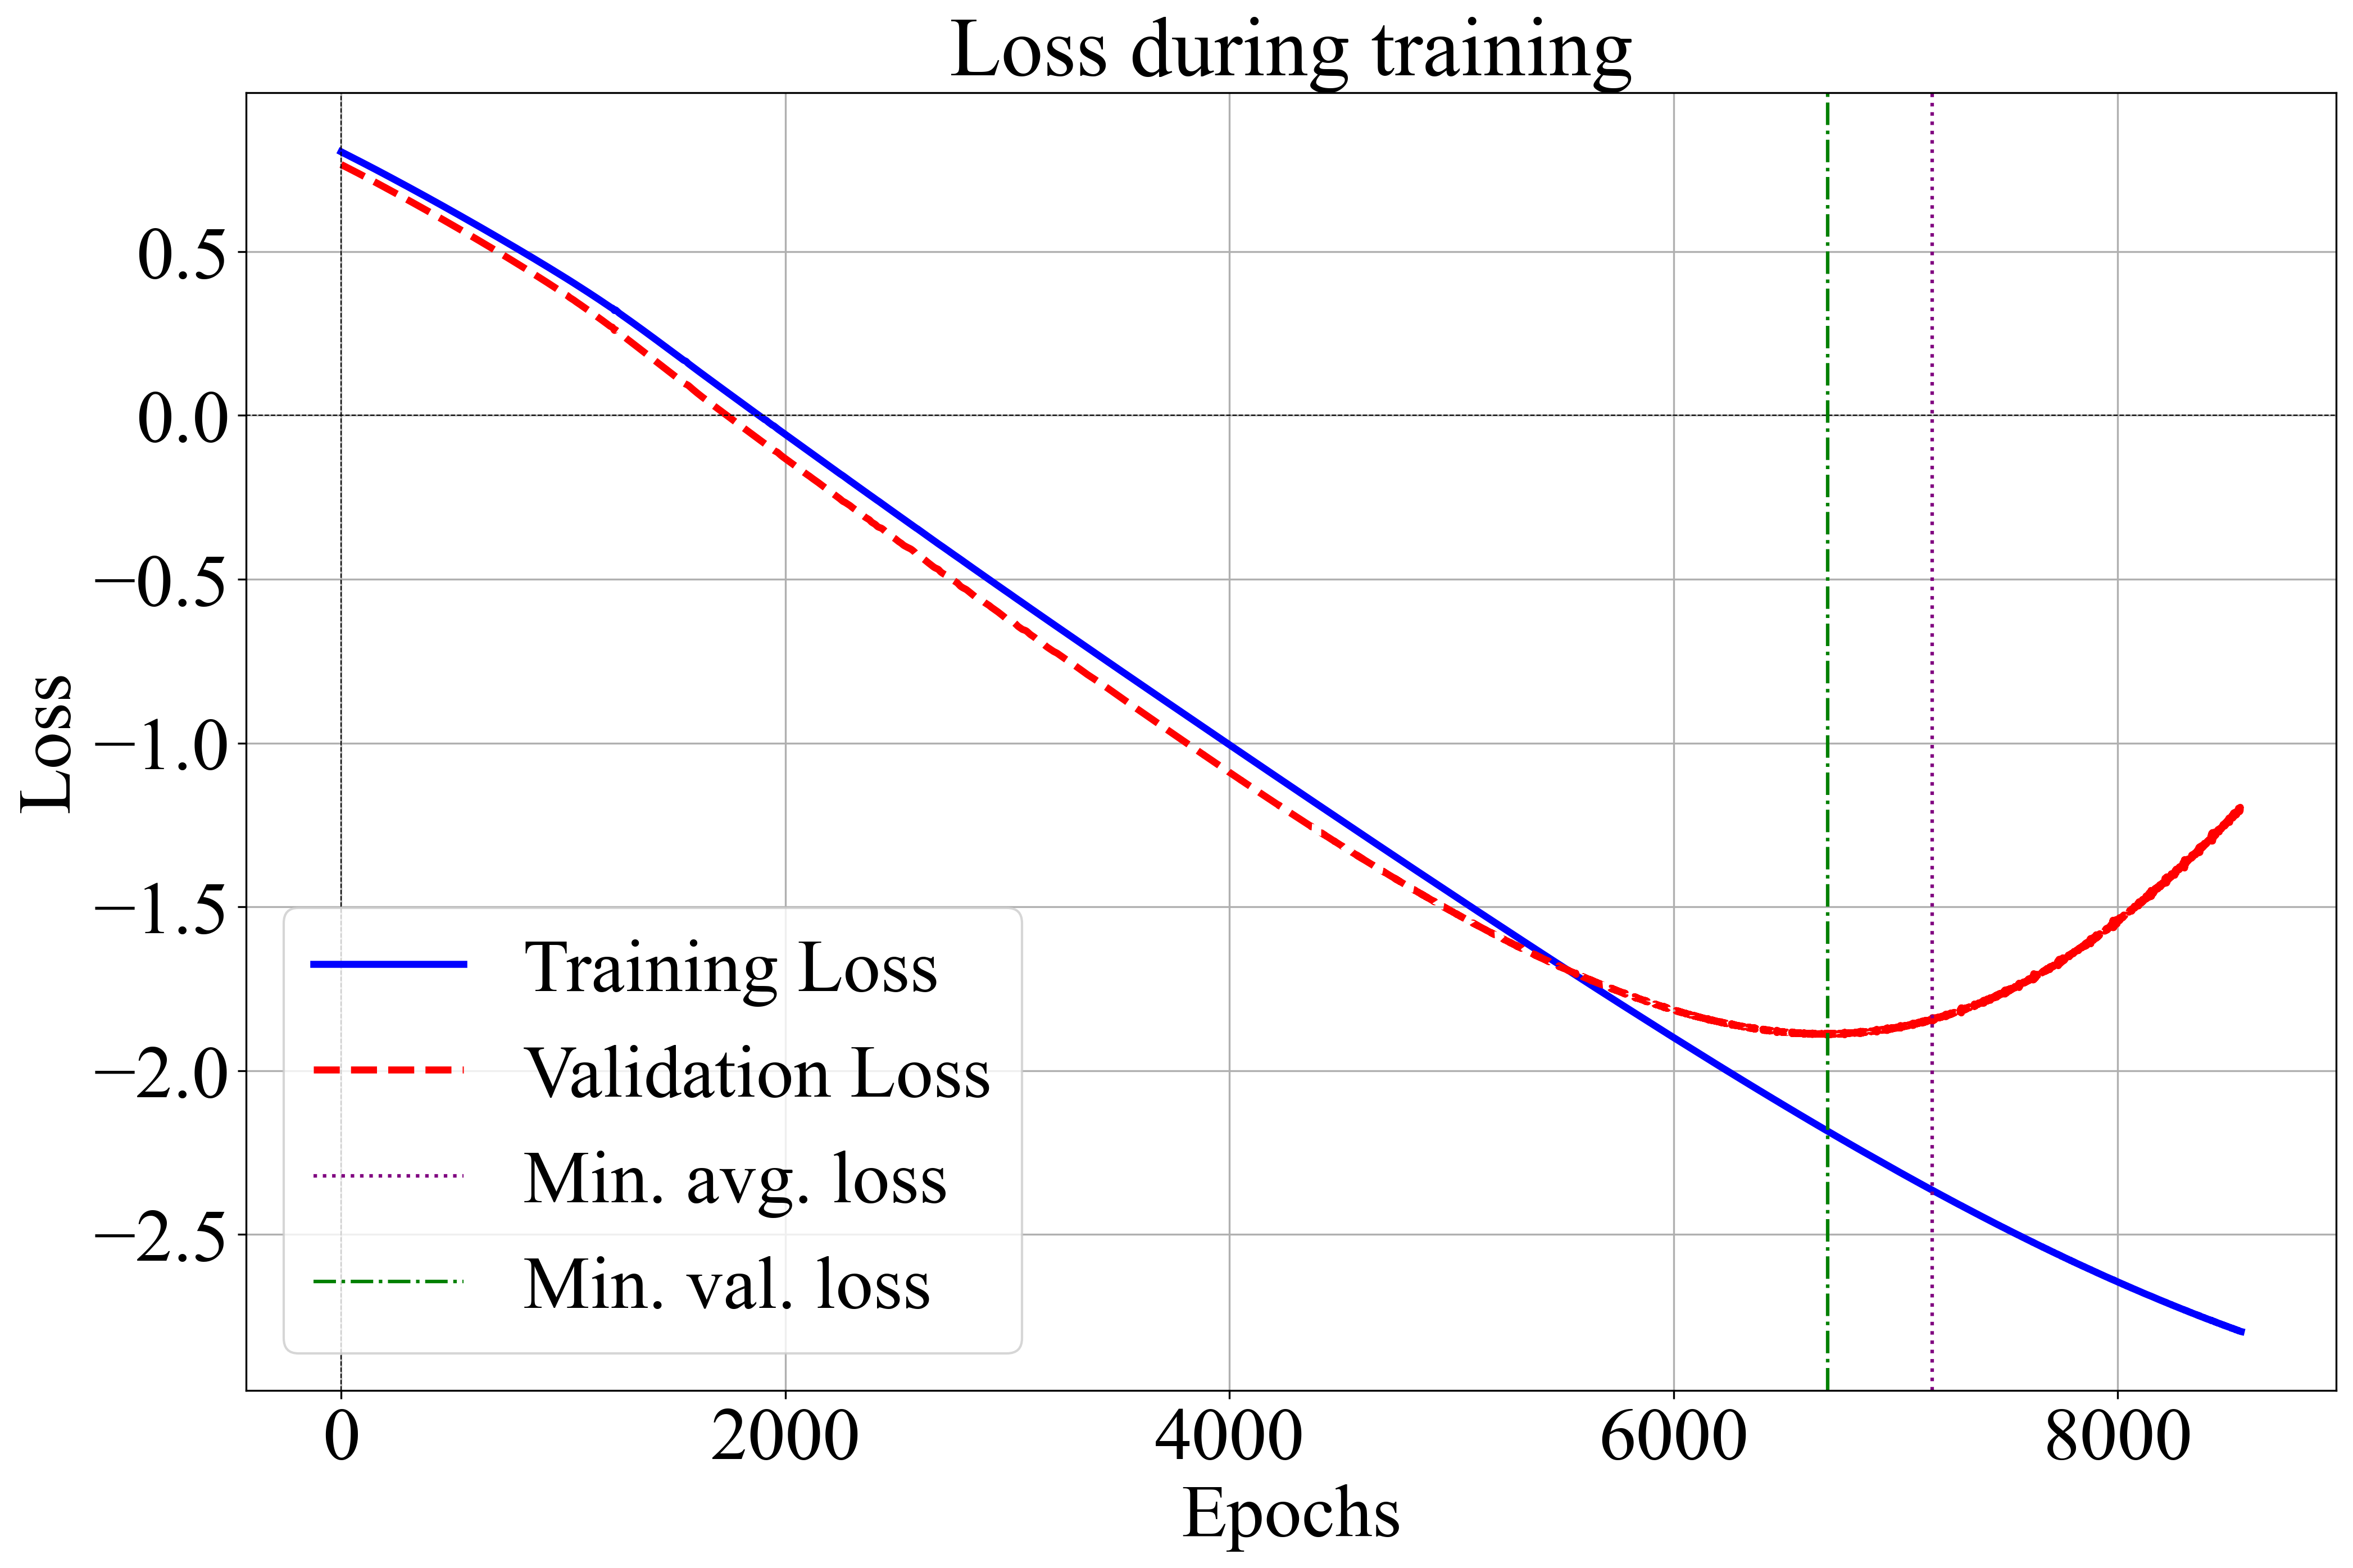

tensor([[35.3579,  1.1302,  1.1257,  0.9999,  0.9556,  1.0346,  1.2351,  0.9753,
          1.0037,  0.9992,  1.0206,  0.9948,  0.9861,  1.0025,  1.0656,  1.0833,
          0.9891,  1.0297,  1.0069,  0.9934,  1.0057,  1.1890,  1.2039,  1.3410,
          0.9680,  0.9374,  1.1872,  1.4989,  0.8289,  0.8888]])
Points added: 53 of 60
Current time: 04:40:15 28-12-2024
Pf: 0.139% - Pf interval: [0.127, 0.151]%
delta: 17.363%
tensor([-0.4742])

Iteration 6
Early stopping at epoch 7717
Best Loss: -1.8017337322235107 at epoch 6715. Training loss: -2.176530361175537 and val. loss: -1.4269371032714844
  Training succeeded after 1 attempt(s).
delta = 21.53%, avg. loss = -1.8017
New best model found at fold 1:
    delta = 21.53%, avg. loss = -1.8017
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.8017337322235107

Early stopping at epoch 6394
Best Loss: -1.2507918179035187 at epoch 5392. Training loss: -1.6260576248168945 and val. loss: 

<Figure size 640x480 with 0 Axes>

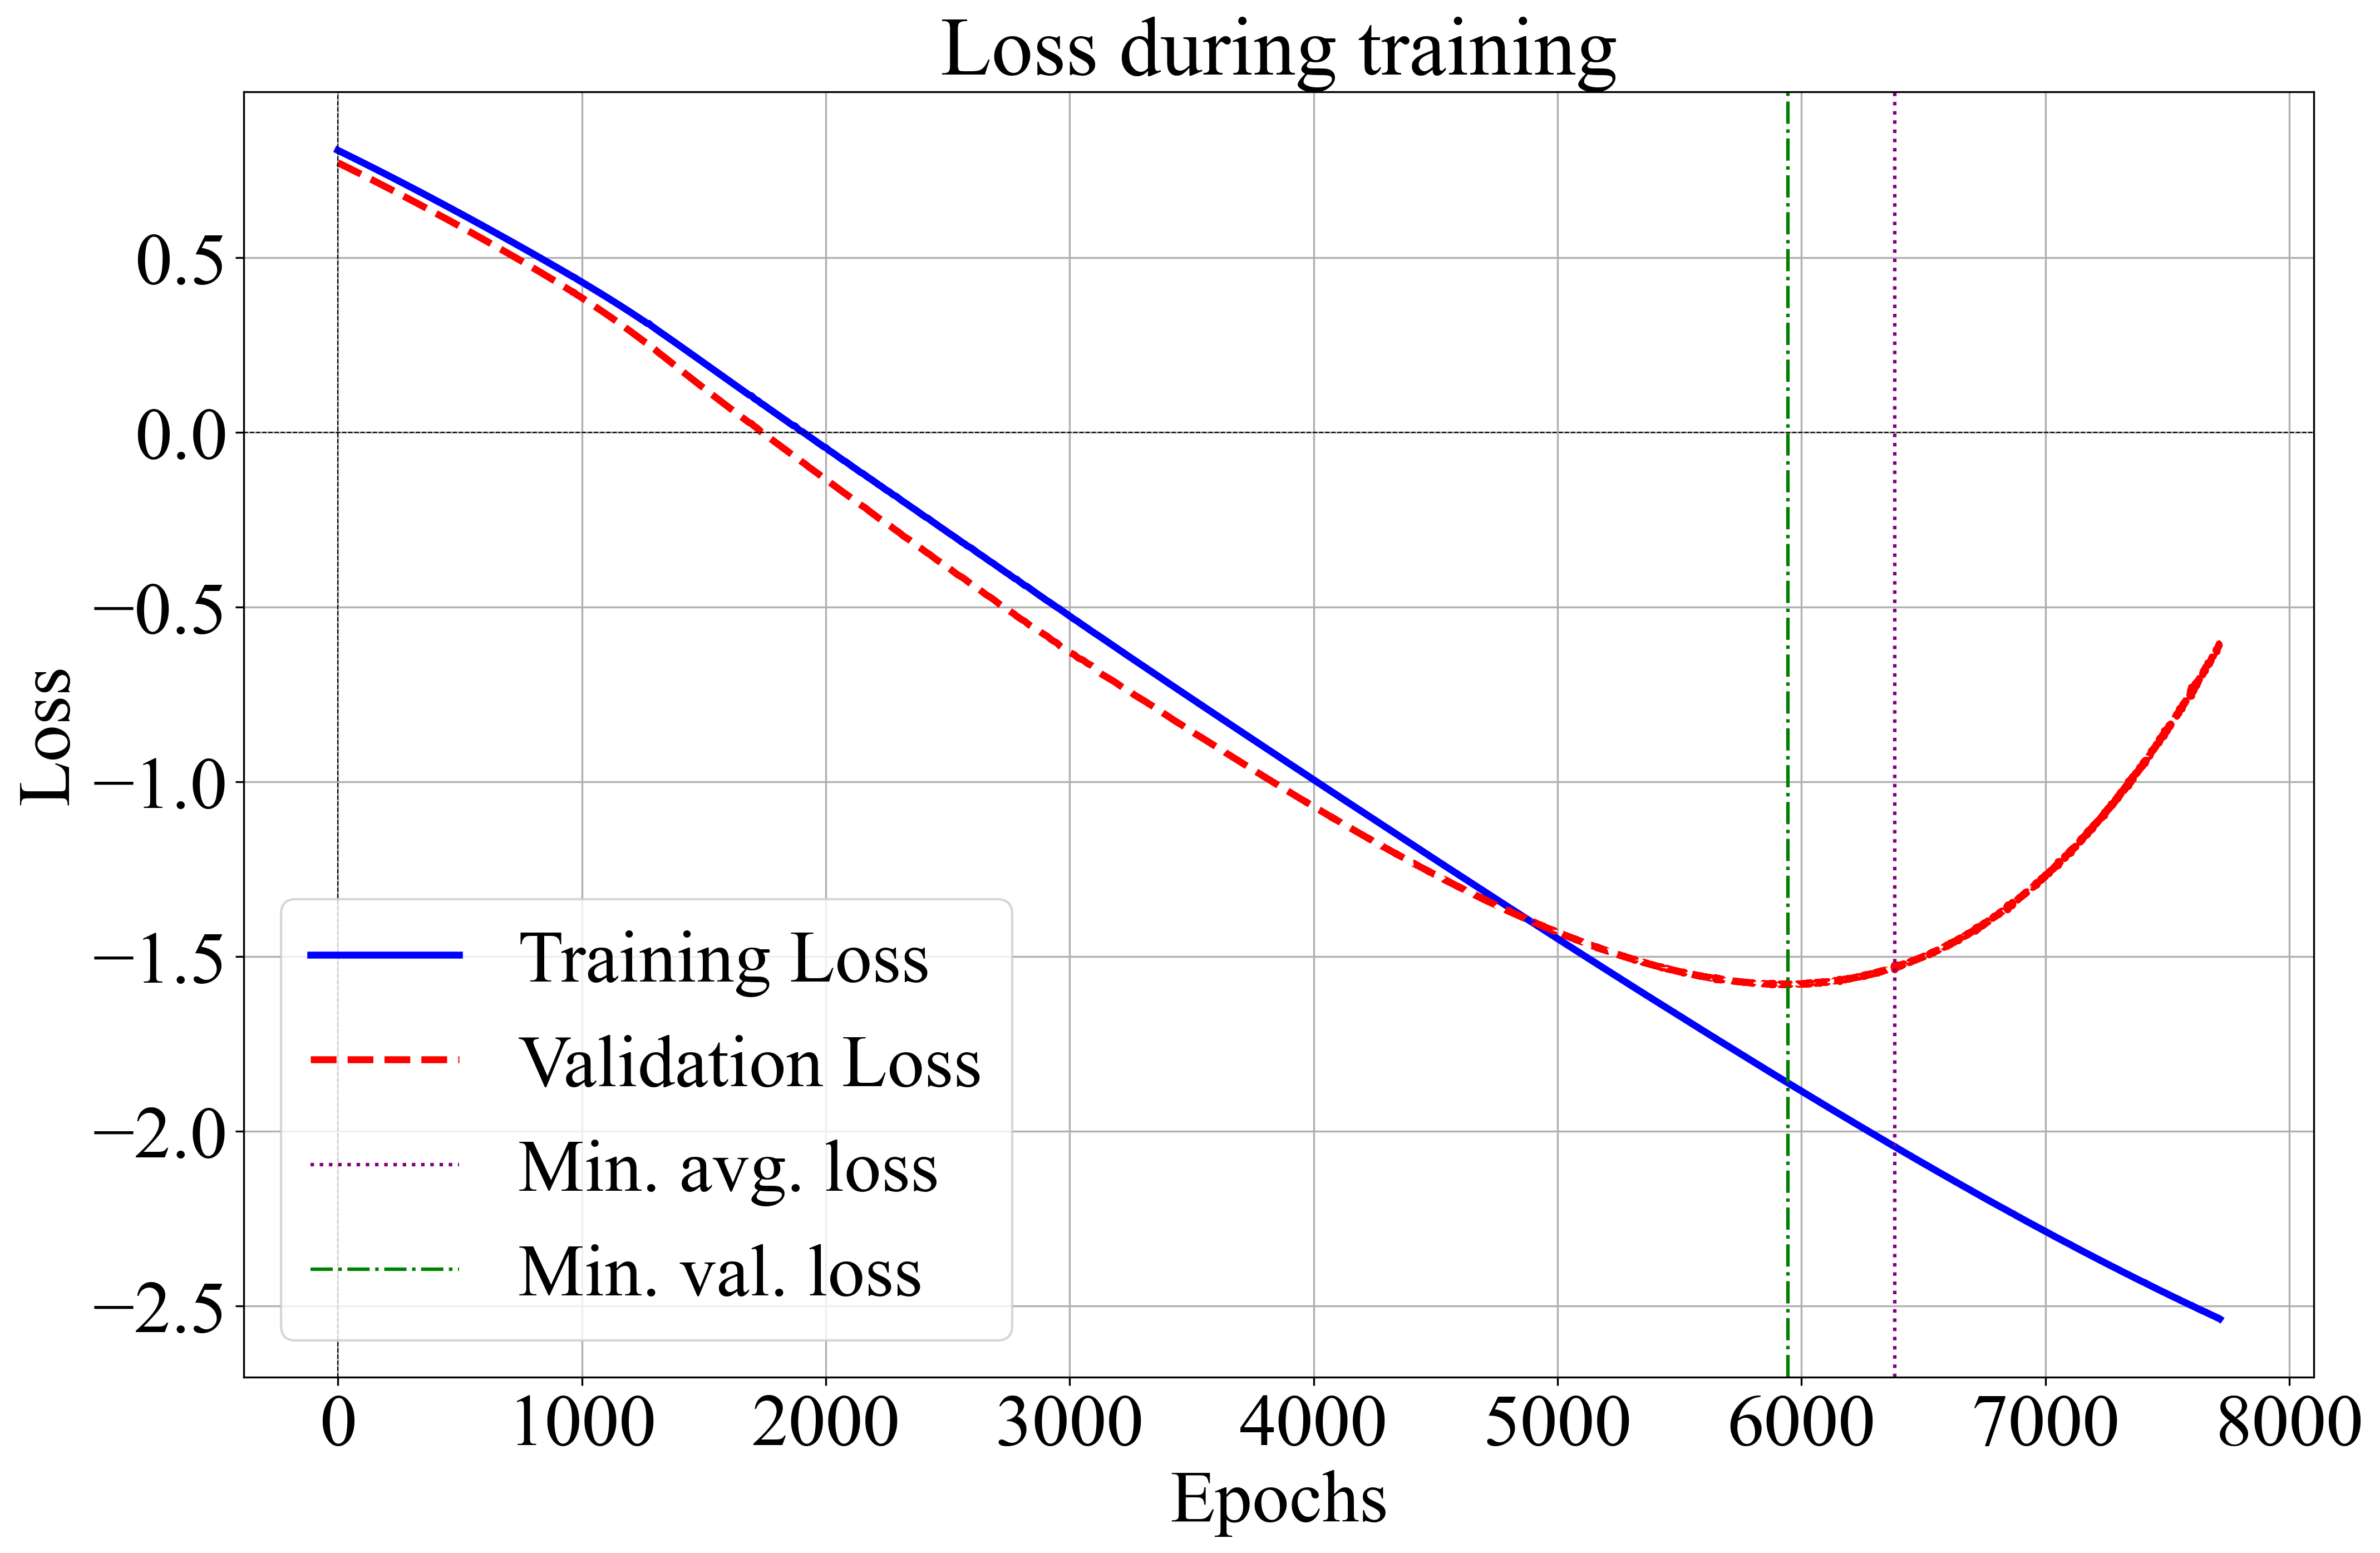

tensor([[34.9336,  1.1652,  1.1448,  1.0302,  0.9931,  1.0370,  1.1353,  1.1327,
          1.0049,  0.9922,  1.0238,  0.9863,  0.9904,  0.9945,  1.0328,  1.0847,
          1.0086,  0.9866,  0.9405,  1.0010,  1.0108,  1.0770,  1.2230,  1.1245,
          1.1053,  1.0065,  1.1577,  1.0263,  1.1251,  1.2188]])
Points added: 54 of 60
Current time: 00:27:48 29-12-2024
Pf: 0.137% - Pf interval: [0.123, 0.152]%
delta: 21.533%
tensor([-0.0190])

Iteration 7
Early stopping at epoch 6087
Best Loss: -1.1213247776031494 at epoch 5085. Training loss: -1.4864088296890259 and val. loss: -0.756240725517273
  Training succeeded after 1 attempt(s).
delta = 39.57%, avg. loss = -1.1213
New best model found at fold 1:
    delta = 39.57%, avg. loss = -1.1213
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.1213247776031494

Early stopping at epoch 6291
Best Loss: -1.1820420622825623 at epoch 5289. Training loss: -1.585063099861145 and val. loss: -

<Figure size 640x480 with 0 Axes>

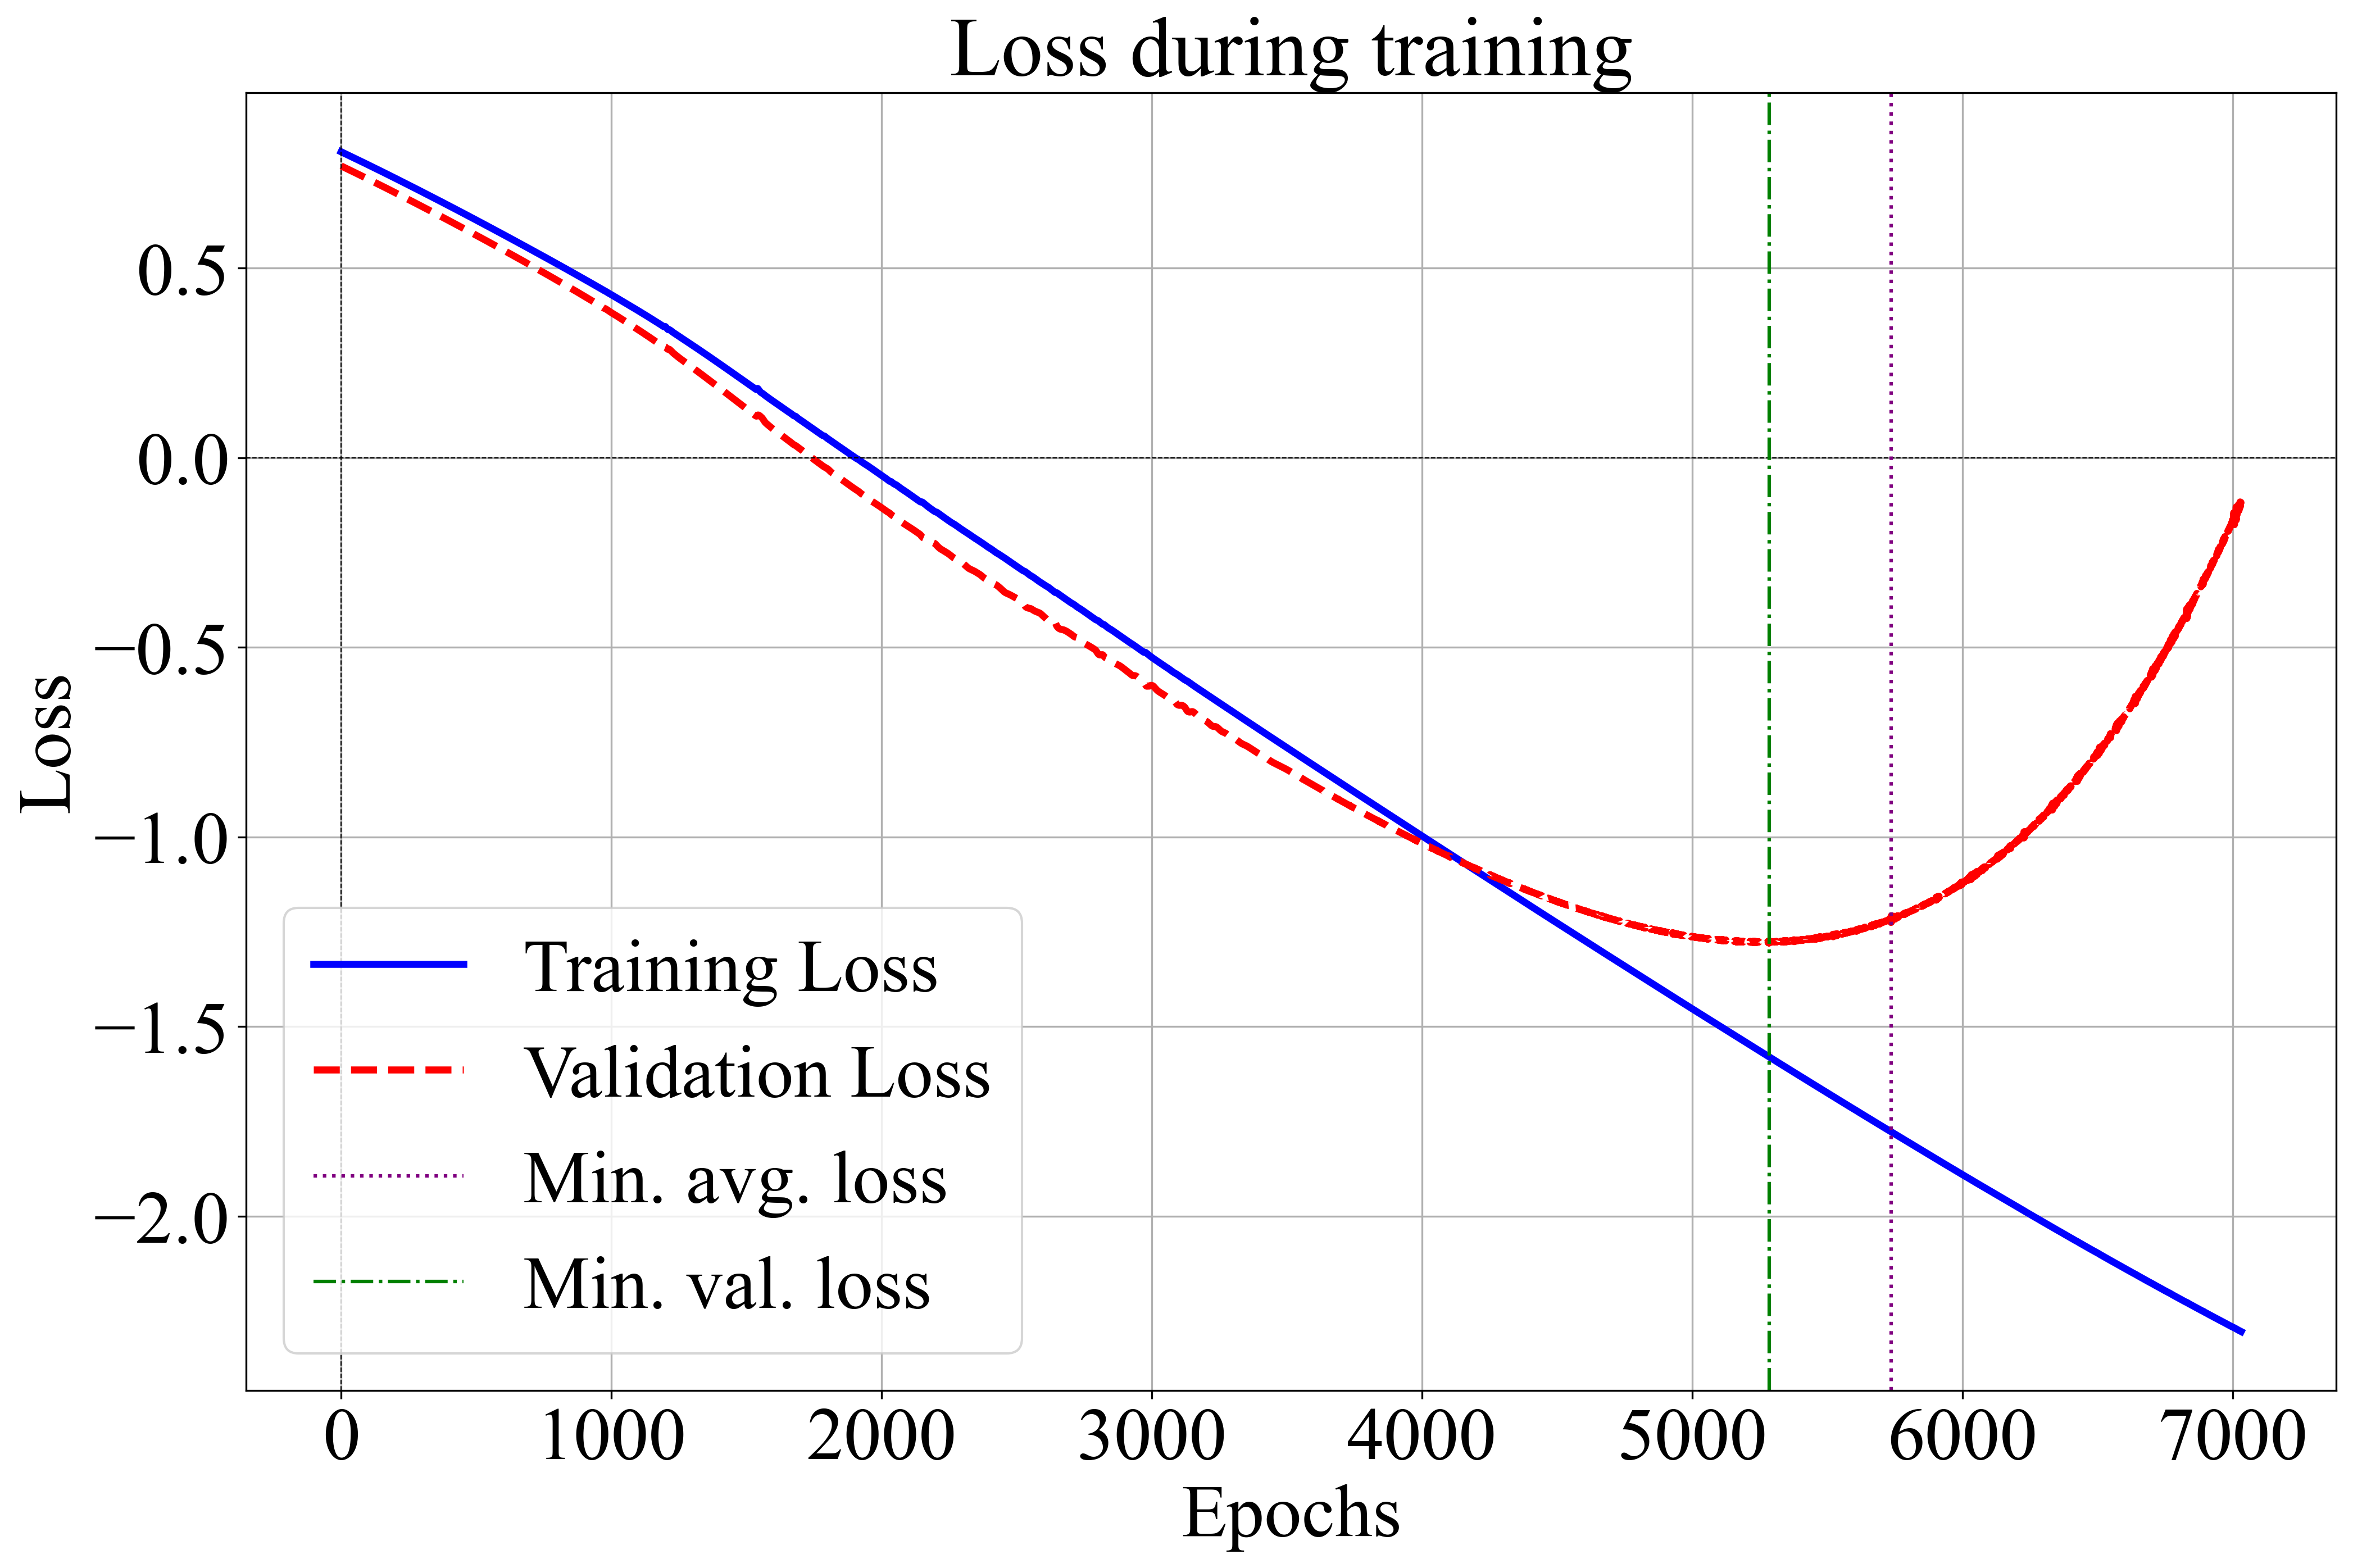

tensor([[32.5913,  1.1868,  1.1044,  1.0184,  0.9916,  1.0145,  1.2332,  0.8247,
          1.0041,  1.0037,  1.0180,  0.9874,  0.9917,  0.9899,  1.0475,  1.0242,
          1.0075,  0.9942,  0.9843,  0.9965,  1.0063,  1.2144,  1.1154,  1.2194,
          1.2186,  0.9999,  1.4585,  1.0684,  0.8632,  1.4565]])
Points added: 55 of 60
Current time: 17:11:55 30-12-2024
Pf: 0.149% - Pf interval: [0.132, 0.166]%
delta: 22.813%
tensor([0.0565])

Iteration 8
Early stopping at epoch 5627
Best Loss: -0.8869976848363876 at epoch 4625. Training loss: -1.2831343412399292 and val. loss: -0.49086102843284607
  Training succeeded after 1 attempt(s).
delta = 47.87%, avg. loss = -0.8870
New best model found at fold 1:
    delta = 47.87%, avg. loss = -0.8870
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -0.8869976848363876

Early stopping at epoch 6254
Best Loss: -1.1814882159233093 at epoch 5252. Training loss: -1.5684736967086792 and val. loss:

<Figure size 640x480 with 0 Axes>

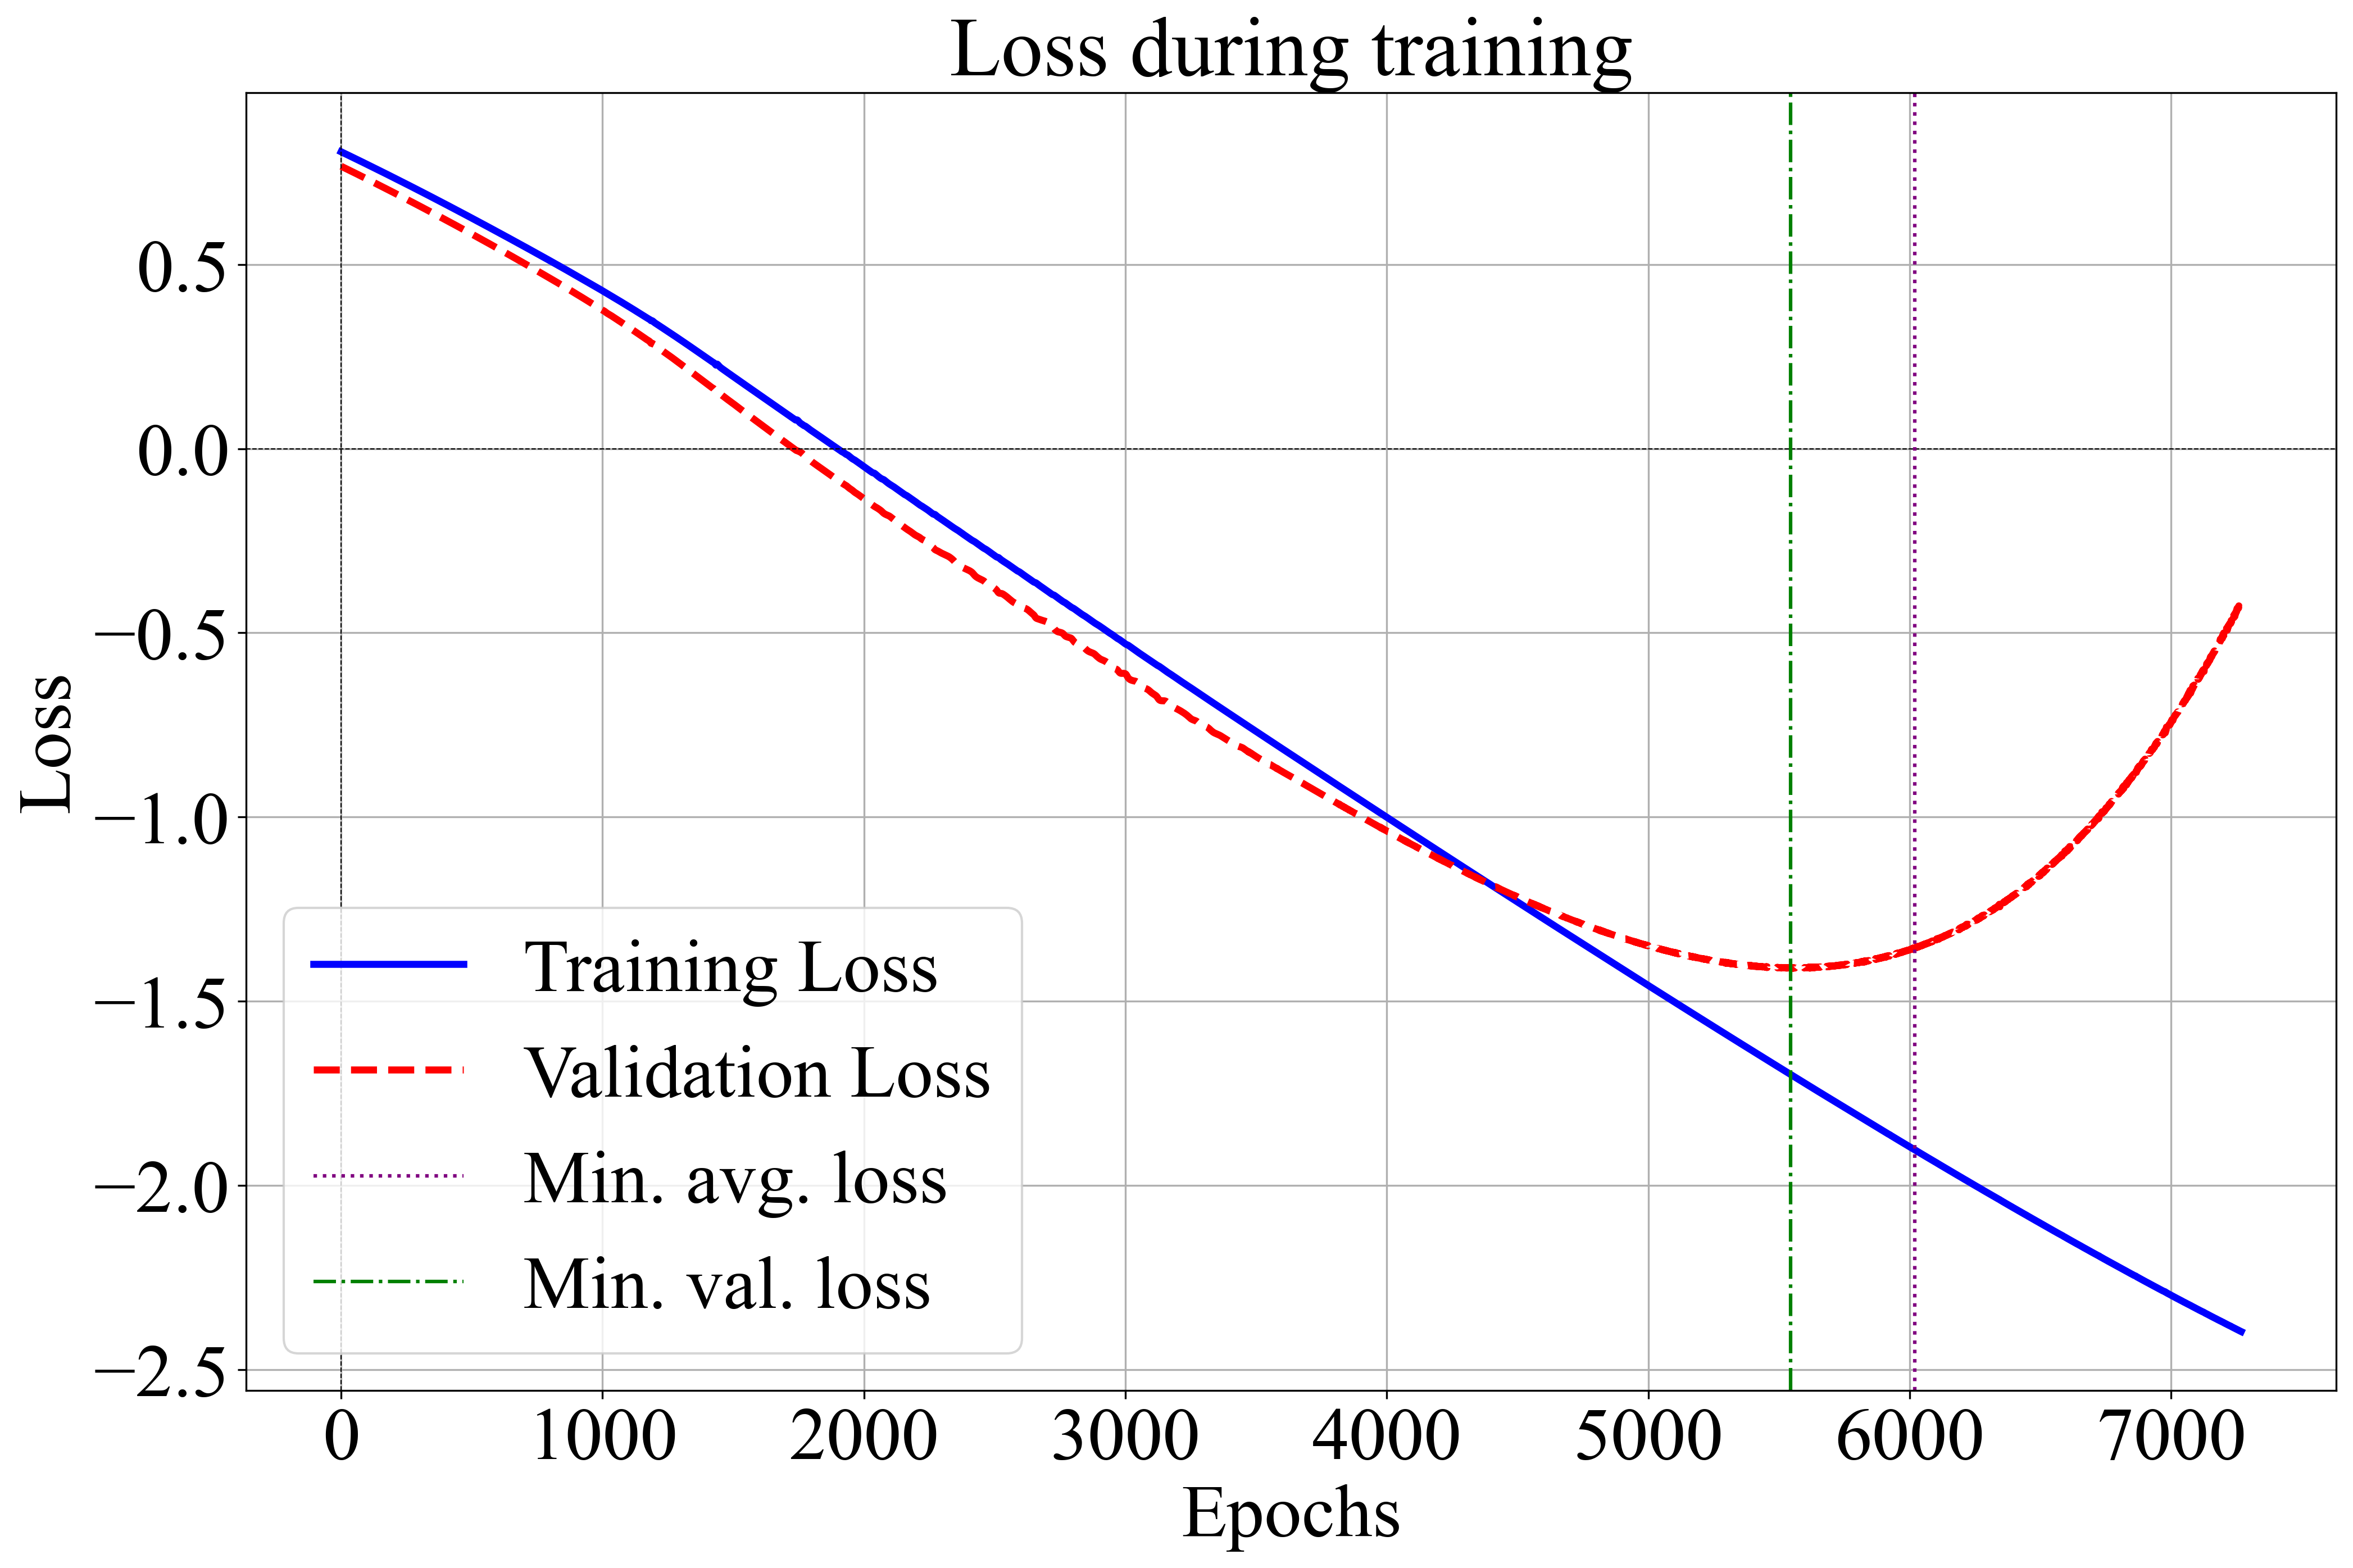

tensor([[34.5785,  1.2312,  1.1427,  1.0050,  0.9761,  1.0382,  1.1520,  0.8168,
          0.9988,  0.9996,  1.0229,  0.9830,  1.0001,  0.9898,  1.0162,  1.0709,
          0.9986,  1.0416,  0.9757,  0.9898,  0.9928,  1.1913,  1.1249,  1.1727,
          1.0189,  1.0253,  0.6494,  0.9950,  1.0066,  0.8669]])
Points added: 56 of 60
Current time: 17:11:54 31-12-2024
Pf: 0.146% - Pf interval: [0.132, 0.164]%
delta: 21.772%
tensor([-0.0596])

Iteration 9
Early stopping at epoch 6481
Best Loss: -1.28862065076828 at epoch 5479. Training loss: -1.6697840690612793 and val. loss: -0.9074572324752808
  Training succeeded after 1 attempt(s).
delta = 35.06%, avg. loss = -1.2886
New best model found at fold 1:
    delta = 35.06%, avg. loss = -1.2886
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.28862065076828

Early stopping at epoch 7390
Best Loss: -1.673589289188385 at epoch 6388. Training loss: -2.062450408935547 and val. loss: -1.28

<Figure size 640x480 with 0 Axes>

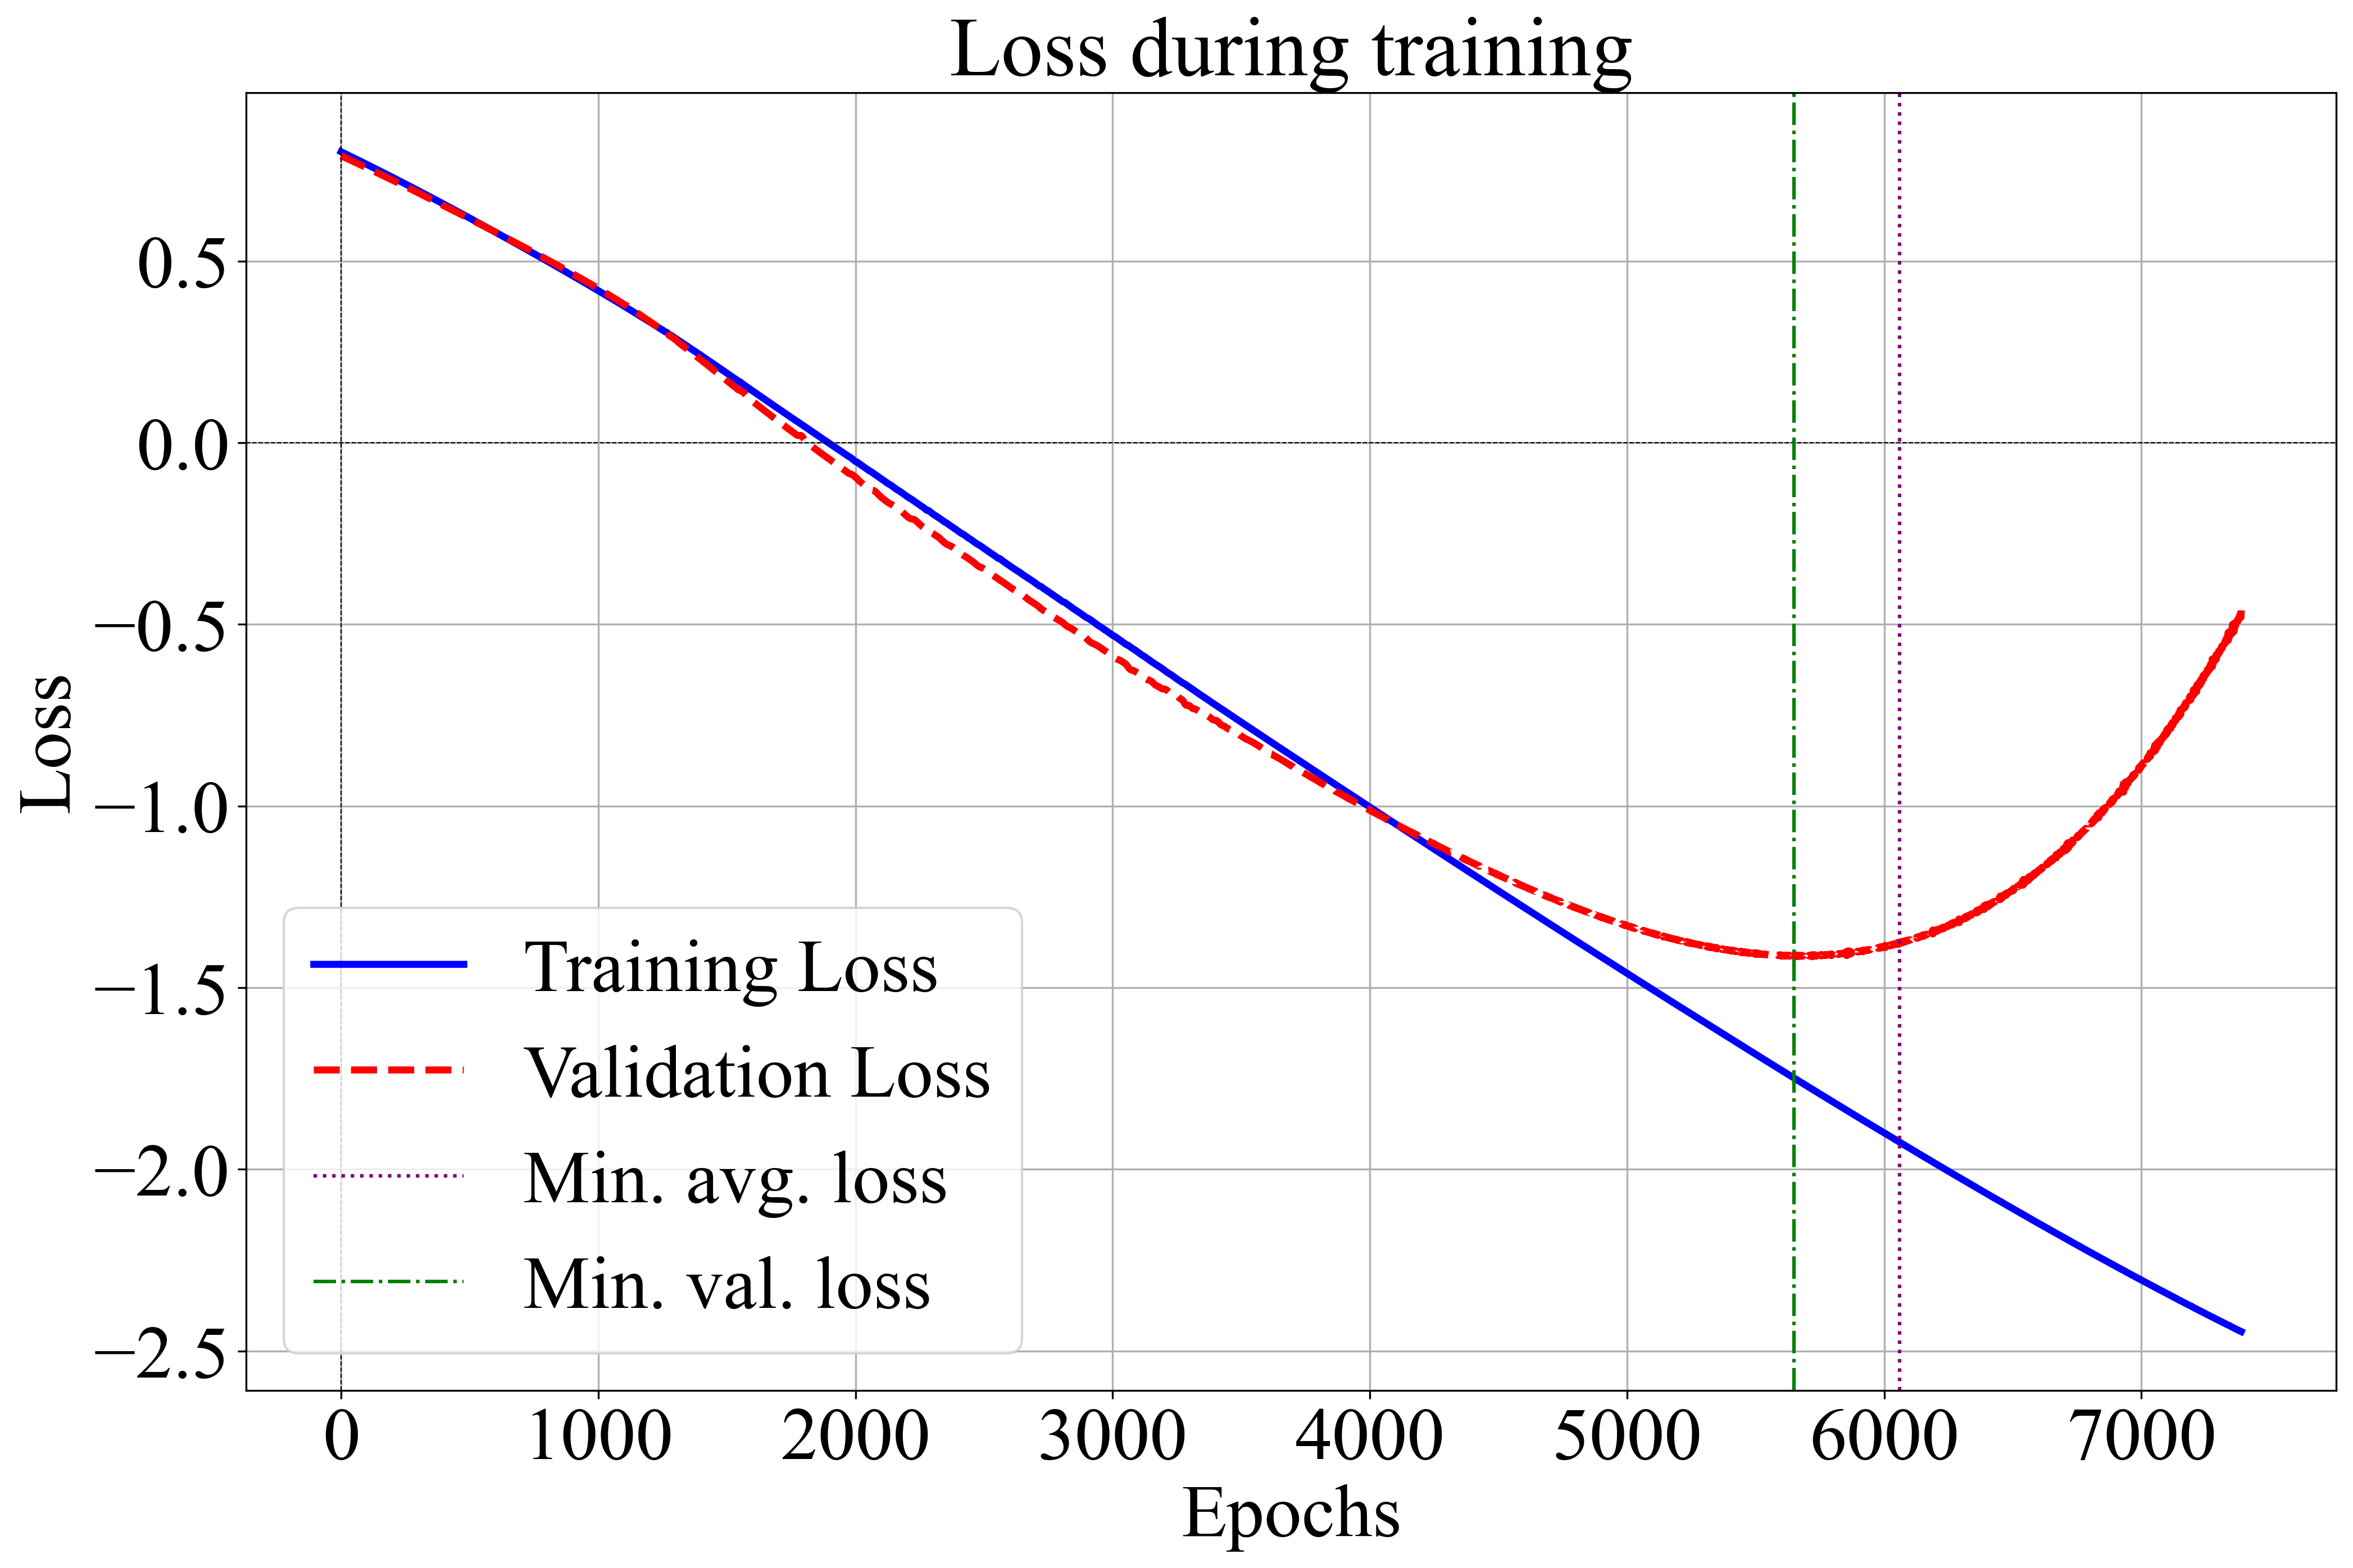

tensor([[33.9964,  1.1212,  1.1216,  1.0127,  0.9714,  1.0246,  1.1921,  1.0926,
          0.9972,  1.0051,  1.0279,  0.9952,  0.9908,  1.0041,  1.0301,  1.0040,
          1.0022,  1.0095,  1.0465,  0.9894,  1.0029,  1.1356,  1.2013,  1.2062,
          1.0496,  1.0092,  0.6840,  1.0683,  0.8966,  1.4027]])
Points added: 57 of 60
Current time: 21:23:38 06-01-2025
Pf: 0.142% - Pf interval: [0.128, 0.159]%
delta: 21.684%
tensor([-0.0004])

Iteration 10
Early stopping at epoch 5767
Best Loss: -0.9526267051696777 at epoch 4765. Training loss: -1.3546384572982788 and val. loss: -0.5506149530410767
  Training succeeded after 1 attempt(s).
delta = 46.83%, avg. loss = -0.9526
New best model found at fold 1:
    delta = 46.83%, avg. loss = -0.9526
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -0.9526267051696777

Early stopping at epoch 5636
Best Loss: -0.8933161944150925 at epoch 4634. Training loss: -1.2976047992706299 and val. loss

<Figure size 640x480 with 0 Axes>

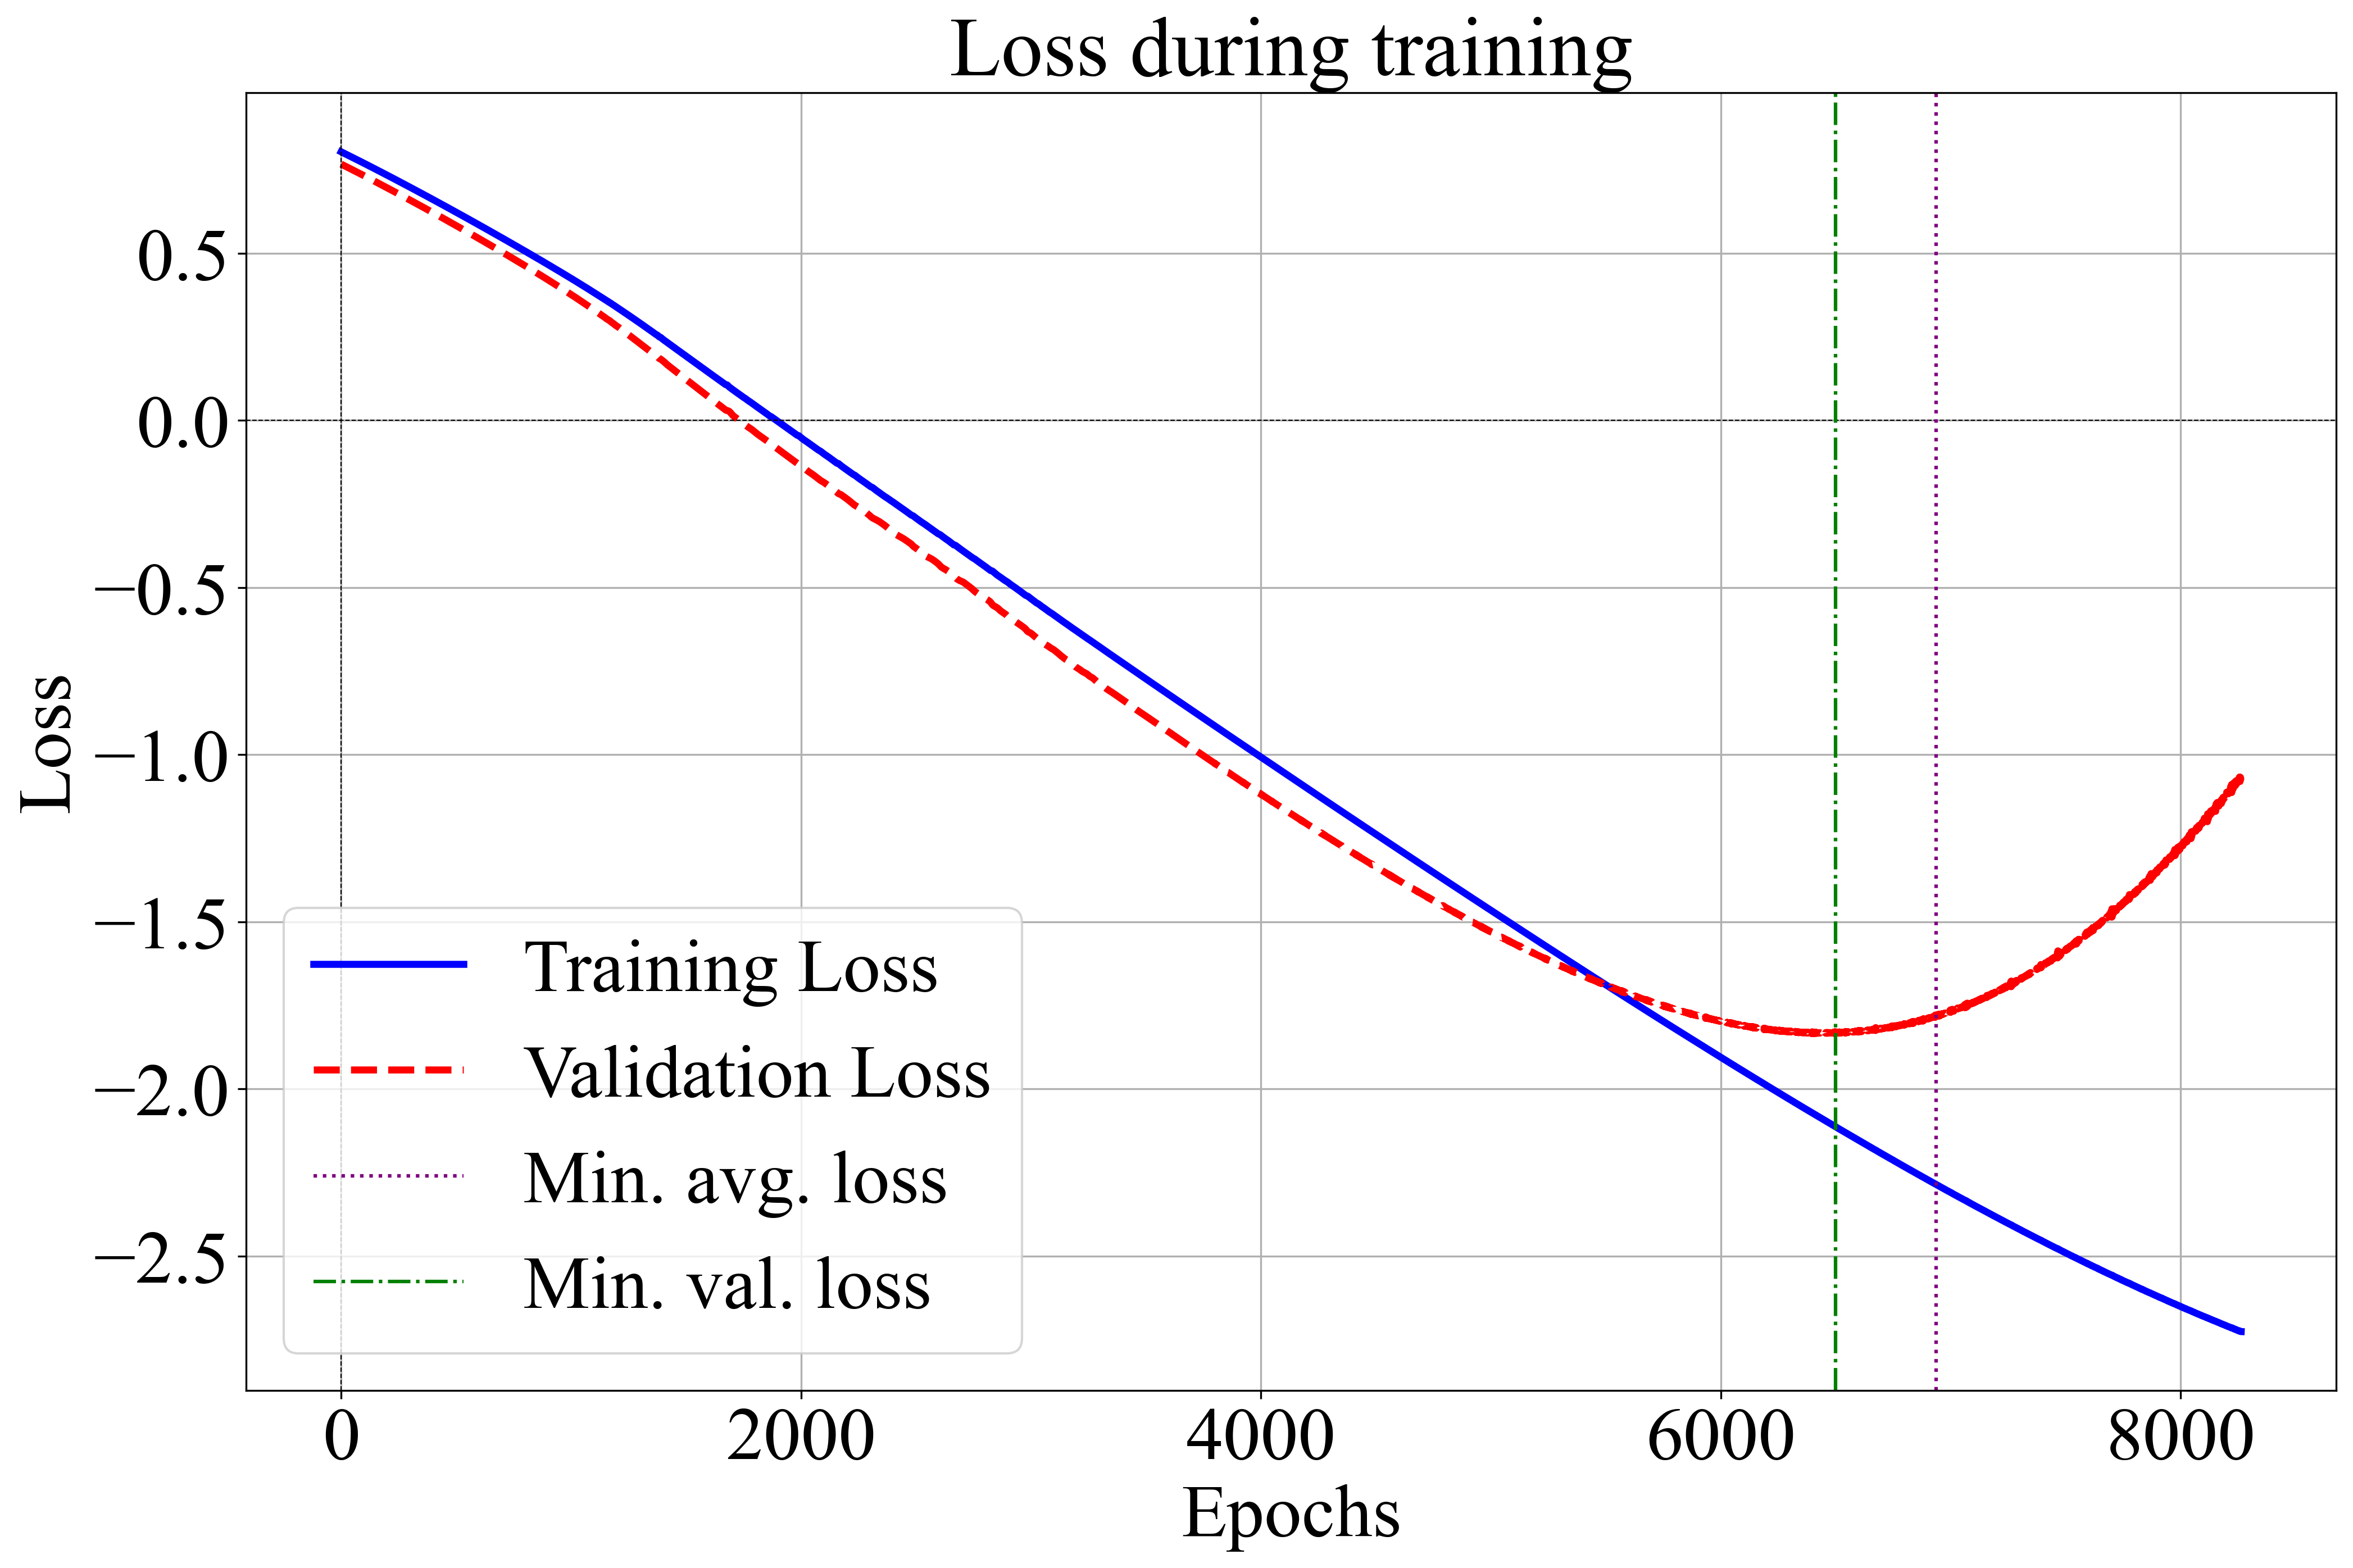

tensor([[35.1623,  1.1742,  1.1948,  0.9348,  0.9922,  1.0338,  1.1731,  1.2052,
          1.0059,  0.9970,  1.0245,  0.9787,  0.9759,  0.9948,  1.0315,  1.0633,
          1.0010,  1.0361,  0.9610,  1.0024,  0.9862,  1.2390,  1.1312,  1.2629,
          0.9203,  1.0949,  0.8783,  0.8800,  1.2182,  0.4238]])
Points added: 58 of 60
Current time: 13:09:56 14-01-2025
Pf: 0.142% - Pf interval: [0.132, 0.155]%
delta: 16.174%
tensor([-0.0416])

Iteration 11
Early stopping at epoch 5448
Best Loss: -0.8182981908321381 at epoch 4446. Training loss: -1.2210811376571655 and val. loss: -0.4155152440071106
  Training succeeded after 1 attempt(s).
delta = 72.26%, avg. loss = -0.8183
New best model found at fold 1:
    delta = 72.26%, avg. loss = -0.8183
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -0.8182981908321381

Early stopping at epoch 5747
Best Loss: -0.9458320438861847 at epoch 4745. Training loss: -1.3519937992095947 and val. loss

<Figure size 640x480 with 0 Axes>

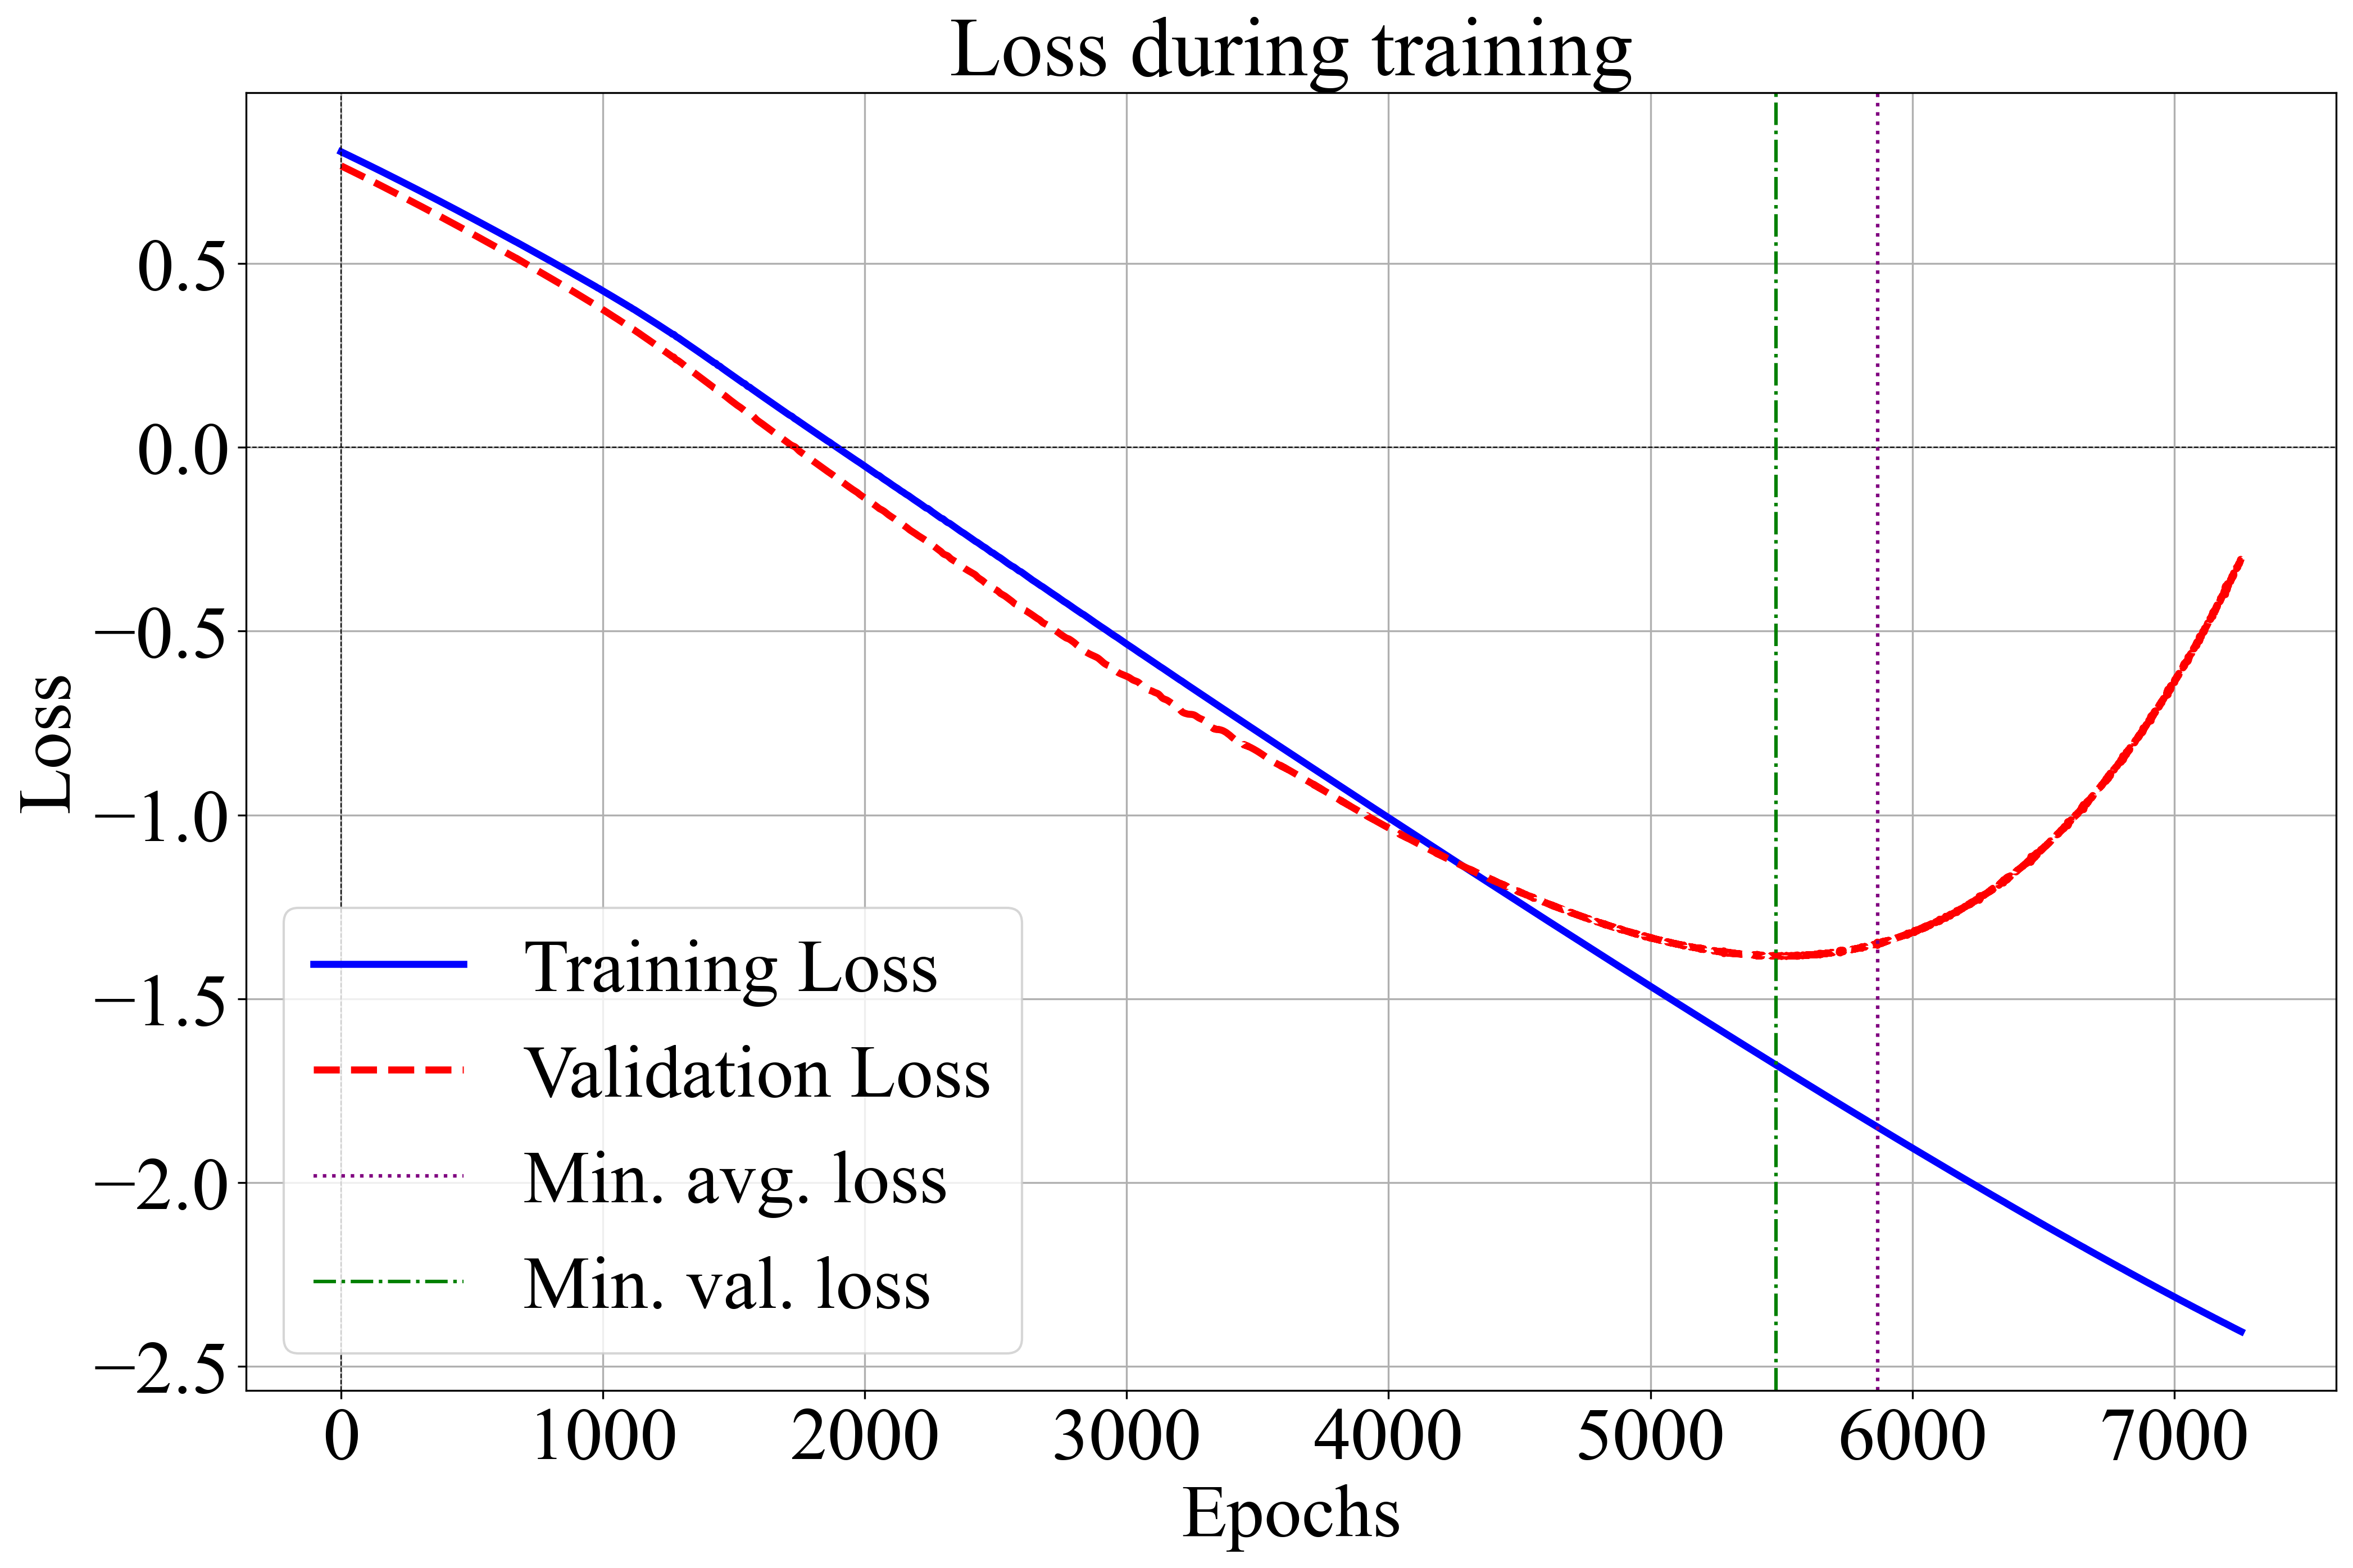

tensor([[32.7782,  1.1128,  1.1865,  0.9830,  0.9735,  1.0313,  1.1873,  0.8532,
          0.9921,  1.0033,  1.0113,  0.9900,  0.9887,  0.9919,  1.0411,  1.0306,
          1.0052,  1.0472,  0.9954,  1.0036,  0.9870,  1.1127,  1.2727,  1.2195,
          0.9176,  0.9022,  0.8590,  1.3043,  1.0724,  0.4784]])
Points added: 59 of 60
Current time: 01:27:55 15-01-2025
Pf: 0.155% - Pf interval: [0.138, 0.172]%
delta: 22.071%
tensor([0.0400])

Iteration 12
Early stopping at epoch 5861
Best Loss: -1.0050298571586609 at epoch 4859. Training loss: -1.4050521850585938 and val. loss: -0.605007529258728
  Training succeeded after 1 attempt(s).
delta = 41.02%, avg. loss = -1.0050
New best model found at fold 1:
    delta = 41.02%, avg. loss = -1.0050
    layer_sizes: [16, 9, 5, 3], act fun: <class 'torch.nn.modules.activation.Sigmoid'>

Fold: 1, Avg. Loss: -1.0050298571586609

Early stopping at epoch 7180
Best Loss: -1.5274414420127869 at epoch 6178. Training loss: -1.989019513130188 and val. loss: -

<Figure size 640x480 with 0 Axes>

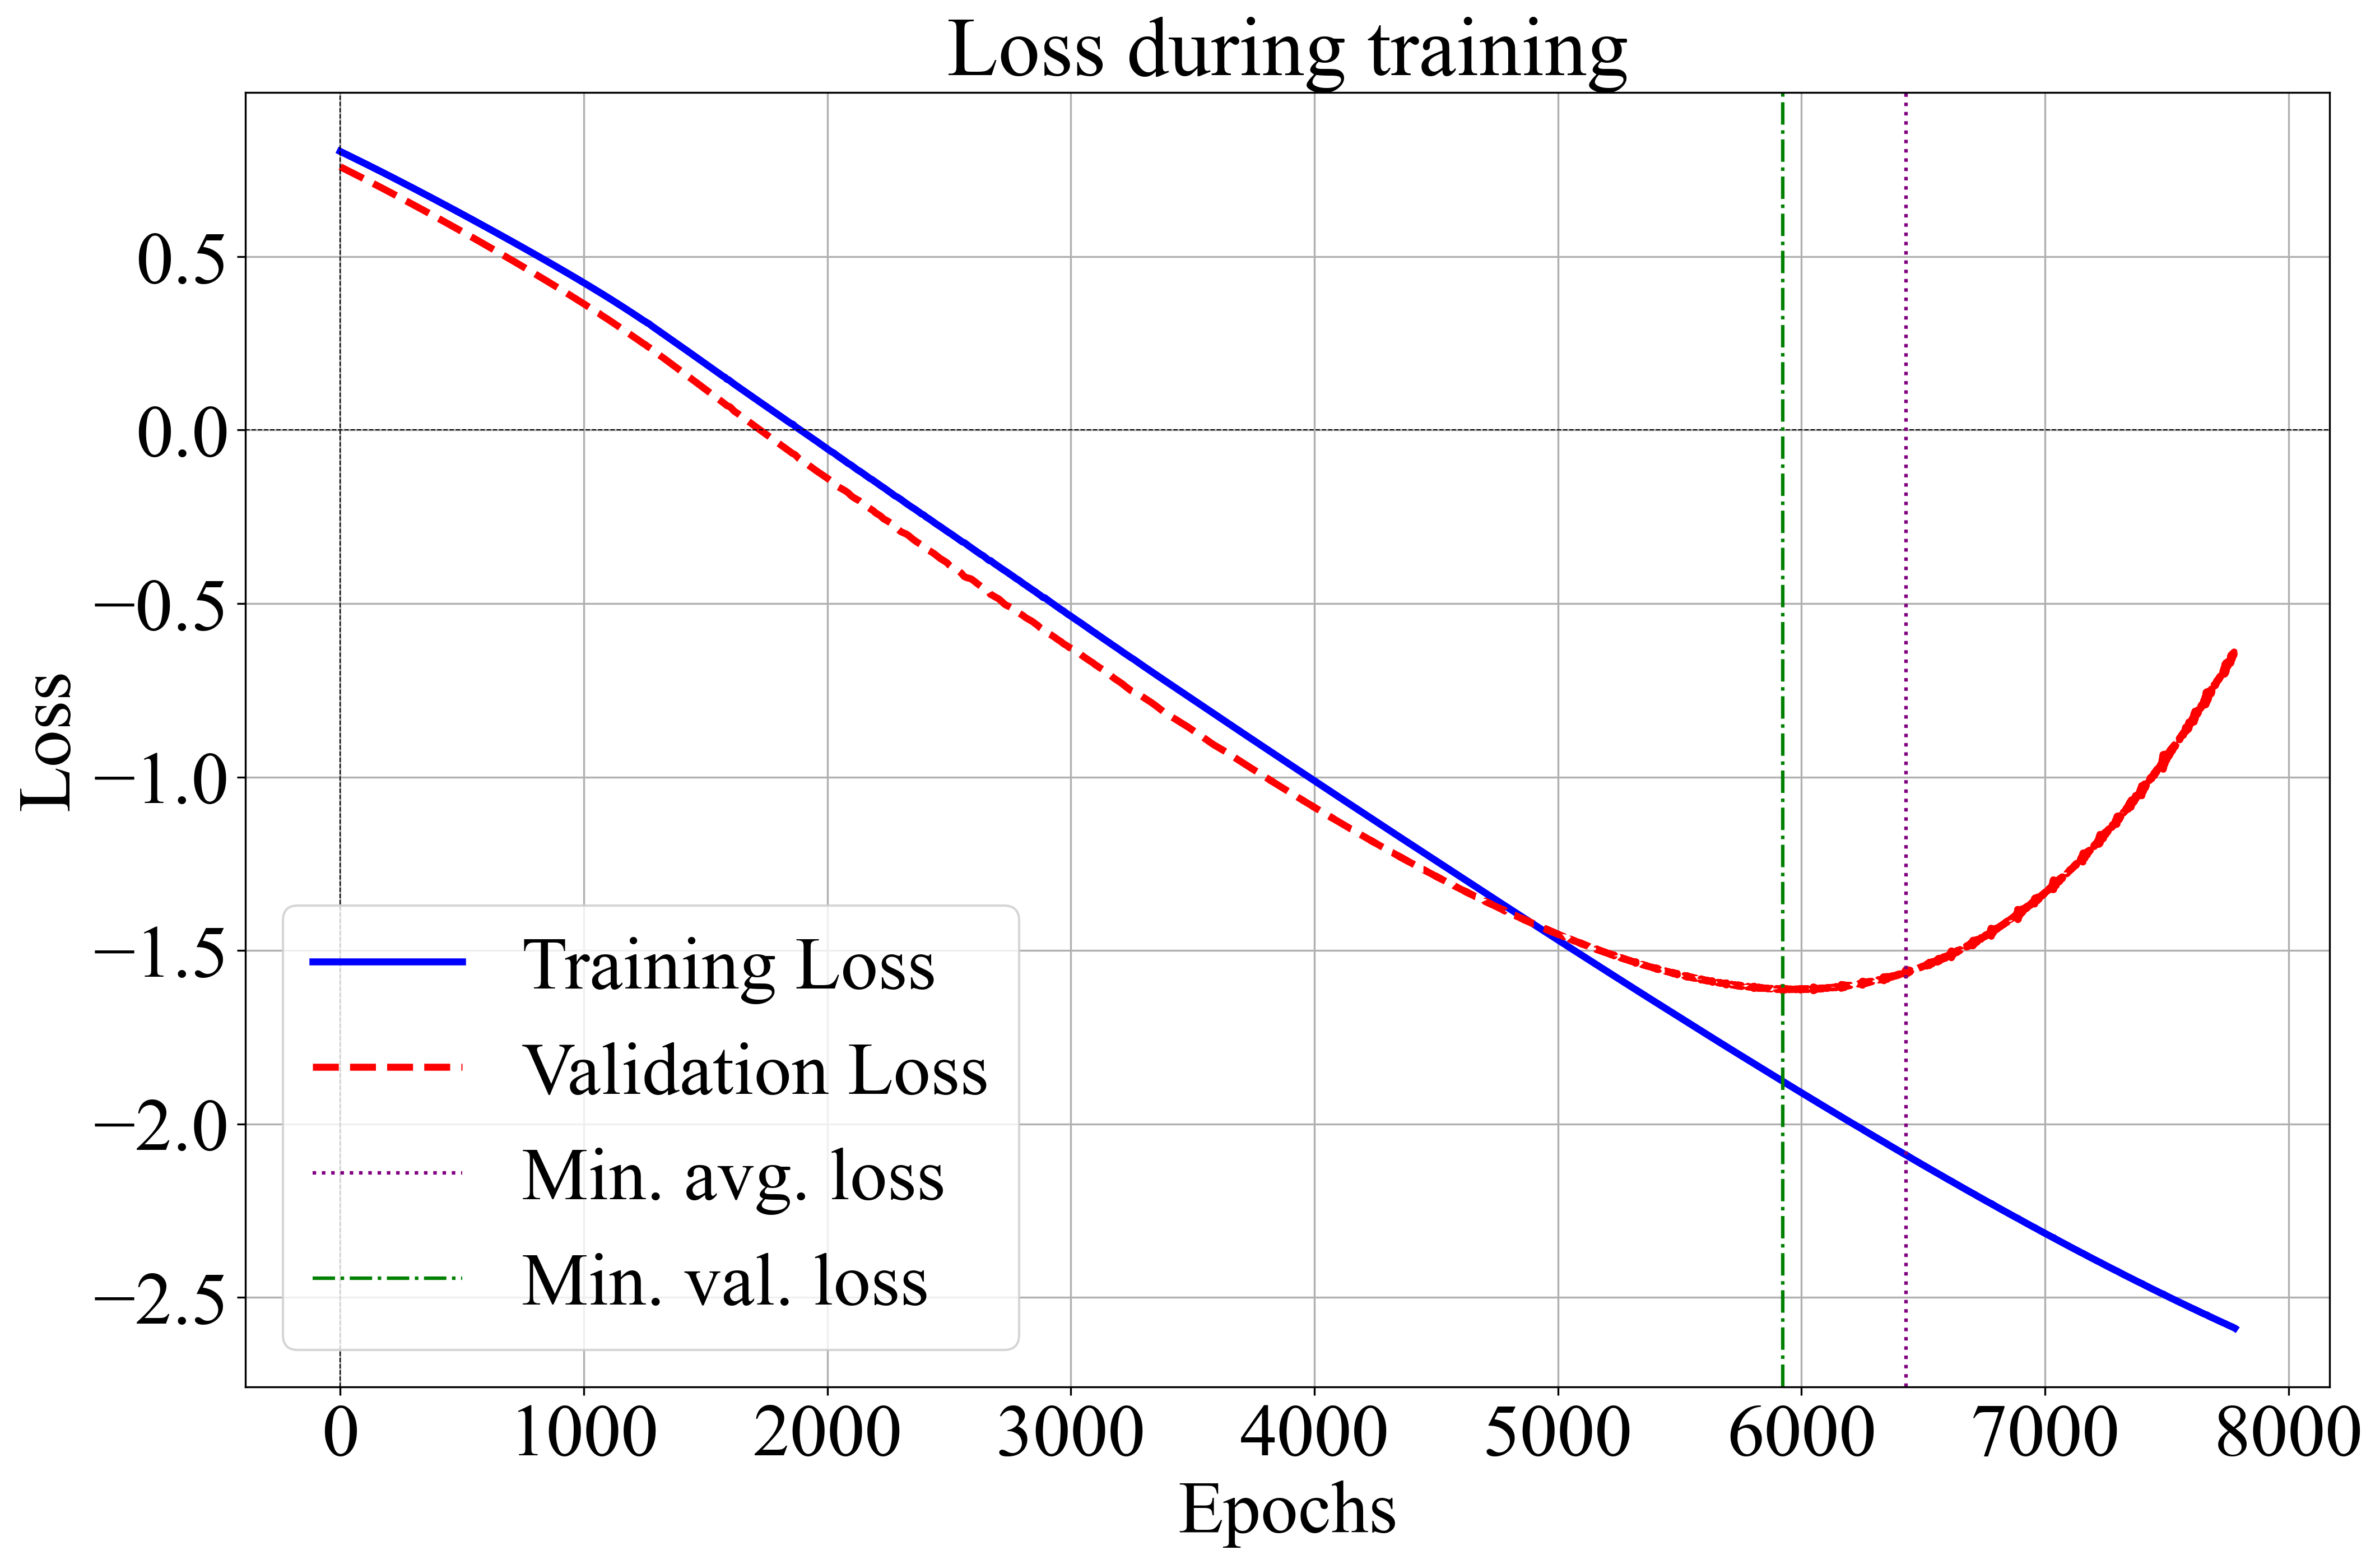

tensor([[32.4491,  1.2593,  1.1266,  1.0210,  0.9798,  1.0301,  1.1669,  0.8147,
          1.0080,  1.0062,  1.0206,  0.9867,  0.9795,  1.0066,  1.0100,  0.9895,
          1.0209,  1.0062,  0.9736,  0.9807,  1.0232,  1.1663,  1.1958,  1.2009,
          1.1791,  0.9236,  1.0360,  1.1954,  1.0207,  0.8718]])
Points added: 60 of 60
Current time: 08:43:48 23-01-2025
Pf: 0.144% - Pf interval: [0.134, 0.158]%
delta: 17.002%


<Figure size 640x480 with 0 Axes>

In [37]:
while True:
    print(f'\nIteration {it}')
    
    if it == 0:
        f_EGO, x_EGO, model, likelihood, train_losses, val_losses, train_x, val_x, train_g, val_g, x_max, x_min \
            = bayesian_optimization(
                N_INITIAL_EGO, N_INFILL_EGO, DIM_EGO, TRAINING_ITERATIONS_EGO, BOUNDS_BSA, BSA_POPSIZE, BSA_EPOCH
                )
    else:
        layer_sizes, _, act_fun = optimization_variables(BOUNDS_BAY_OPT, x_EGO[torch.argmin(f_EGO), :], x)
        _, _, model, likelihood, train_losses, val_losses, train_x, val_x, train_g, val_g, x_max, x_min, fold = kfold_train(
            x, g, x_candidate, TRAINING_ITERATIONS, LEARNING_RATE, layer_sizes, act_fun, SPECTRAL_NORMALIZATION, n_splits=VALIDATION_SPLIT)
    
    save_bests(model, likelihood, train_losses, val_losses, train_x, val_x, train_g, val_g,
               x_EGO, f_EGO, x_max, x_min)
    plot_losses(train_losses, val_losses, it)
    
    # Predict MC responses (only the sample which are not contained in the Kriging yet)
    x_candidate_normalized = normalize_MC(x_max, x_min, x_candidate)
    preds = MC_prediction(model, likelihood, x_candidate_normalized)
    
    # Evaluate learning function
    g_mean, gs, ind_lf = evaluate_lf(preds, learning_function)
    
    # Select additional sample (the sample which maximizes the learning function value)
    x_added = x_candidate[ind_lf, :]
    x_added = x_added.view(1, data_dim)
    # x_added = x_added * (x_max - x_min) + x_min  # undo normalization
    
    save_x_added(x_added, it)  # Salve o array do NumPy em um arquivo .mat
    
    # Estimate Pf
    Pf, Pf_plus, Pf_minus = estimate_Pf(g, g_mean, gs)
    
    estimate_Pf_all.append(Pf)
    estimate_Pf_allp.append(Pf_plus)
    estimate_Pf_allm.append(Pf_minus)
    estimate_N_samples_added.append(N_samples_added_total)
    
    # Print some info
    print_info(N, N_INFILL, it, Pf, Pf_plus, Pf_minus)
    
    # Check if maximum number of points were added
    if N_samples_added_total >= N_INFILL: break
    it += 1
    
    # Convergence criterion
    if converged and N_samples_added_total != 0:
        if convergence_function(g, g_mean, gs, N, N_MC): break
        converged = False
    else:
        converged = convergence_function(g, g_mean, gs, N, N_MC)
    
    g_added = evaluate_g(x_added, it, limit_state_function)
    
    x = torch.cat((x, x_added), 0)
    g = torch.cat((g, g_added), 0)
    x_candidate = torch.cat((x_candidate[:ind_lf], x_candidate[ind_lf+1:]))
    N_samples_added_total = N_samples_added_total + 1

## Store results

In [38]:
# Store results
# Estimate failure probability
estimate_Pf = (torch.sum(g_mean <= 0) + torch.sum(g[N+1:] <= 0))/N_MC

# Estimate the covariance
estimate_CoV = torch.sqrt((1-estimate_Pf) / estimate_Pf / N_MC)

# Store the results
Results = {
    'Pf': estimate_Pf,
    'Beta': -ndtri(estimate_Pf),
    'CoV': estimate_CoV,
    'Model_Evaluations': N_samples_added_total + N,
    'Pf_CI': estimate_Pf * np.array([
        1 + ndtri(ALPHA/2)*estimate_CoV,
        1 + ndtri(1-ALPHA/2)*estimate_CoV
        ]),
    }
Results['Beta_CI'] = torch.flip(-ndtri(Results['Pf_CI']), [0])

History = {
    'Pf': estimate_Pf_all,
    'Pf_Upper': estimate_Pf_allp,
    'Pf_Lower': estimate_Pf_allm,
    'N_Samples': estimate_N_samples_added,
    'N_Init': N,
    'X': x,
    'G': g,
    'MC_Sample': x_candidate,
}

## SAVE

In [39]:
def save(Results, History, Params, file_name):
    # Open the file in binary mode
    with open('Results_' + file_name + '.pkl', 'wb') as Results_file:
        # Serialize and write the variable to the file
        pickle.dump(Results, Results_file)

    with open('History_' + file_name + '.pkl', 'wb') as History_file:
        # Serialize and write the variable to the file
        pickle.dump(History, History_file)

    with open('Params_' + file_name + '.pkl', 'wb') as Params_file:
        # Serialize and write the variable to the file
        pickle.dump(Params, Params_file)

In [40]:
save(Results, History, Params, FILE_NAME)

## Display results and plot

In [41]:
def results_print(Results, History, Params):
    model_evals = Results["Model_Evaluations"]
    N = History["N_Init"]
    N_added = History["N_Samples"][-1]
    Pf = Results["Pf"]
    Pf_CI = Results["Pf_CI"]
    Beta = Results["Beta"]
    CoV = Results["CoV"]
    print(f'Model evaluations: {model_evals} ({N} + {N_added})')
    print(f"Probability of failure: {Pf}")
    print(f"Confidence interval: [{Pf_CI[0]:.5f}, {Pf_CI[1]:.5f}] \
(alpha = {Params['alpha']})")
    print(f'Beta: {Beta:.3f}')
    print(f'CoV: {CoV:4f}')


def results_plot(Results, History, Params, file_name):
    plt.rcParams.update({'font.size': 28})
    # Plot Pf history
    x = np.array(History["N_Samples"]) + Params['N']
    y = np.array(History["Pf"])
    plt.plot(x, y, color=(0, 0.4470, 0.7410),
             linestyle='solid', linewidth=2, label=r'$P_f$')

    # # Plot Pf minus history
    ym = np.array(History["Pf_Lower"])
    # plt.plot(x, ym, 'k', linestyle='solid', linewidth=1.5)

    # # Plot Pf plus history
    yp = np.array(History["Pf_Upper"])
    # plt.plot(x, yp, 'k', linestyle='solid', linewidth=1.5)

    # Fill between Pf minus and Pf plus
    gray = 0.9
    plt.fill_between(x, ym, yp, alpha=0.3,
                     facecolor=(gray, gray, gray),
                     edgecolor=(0, 0, 0),
                     label=r'$P_f^+, P_f^-$')

    # Plot CI
    # CI_lower = Results["Pf_CI"][0]
    # CI_upper = Results["Pf_CI"][-1]
    # y = array([CI_lower, CI_upper])
    plt.errorbar(x[-1], y[-1],
                 yerr=Results["CoV"]*ndtri(1-Params['alpha']/2)*y[-1],
                 color=(0, 0, 0), linewidth=2, capsize=6,
                 label='CI MCS')

    # Plot IEC targets
    T = 150
    upper_IEC_target = 0.92*1/T
    y = np.array([upper_IEC_target, upper_IEC_target])
    plt.plot(np.array((x[0], x[-1])), y, 'k',
             linestyle='dashed', linewidth=2,
             label='IEC 60826 Target (1/T)')

    lower_IEC_target = 0.92*1/(2*T)
    y = np.array([lower_IEC_target, lower_IEC_target])
    plt.plot(np.array((x[0], x[-1])), y, 'k',
             linestyle='dashdot', linewidth=2,
             label='IEC 60826 Target (1/2T)')

    # limits and ticks
    plt.yticks(np.array([0, 0.005, 0.01, 0.015, 0.02]))
    plt.ylim([0, 0.02])
    plt.xticks(x)
    plt.xlim([x[0], x[-1]])
    plt.grid(color='gray', linestyle='-', linewidth=0.5)

    # Labels and legend
    plt.ylabel('Probability of failure')
    plt.xlabel('Model evaluations')
    plt.legend()

    # Set figure size and save
    fig = plt.gcf()
    fig.set_size_inches(16, 9)
    fig.savefig('Pf_convergence_' + file_name + '.png', dpi=300)


In [42]:
results_print(Results, History, Params)

Model evaluations: 60 (48 + 12)
Probability of failure: 0.0014410000294446945
Confidence interval: [0.00137, 0.00152] (alpha = 0.05)
Beta: 2.980
CoV: 0.026324


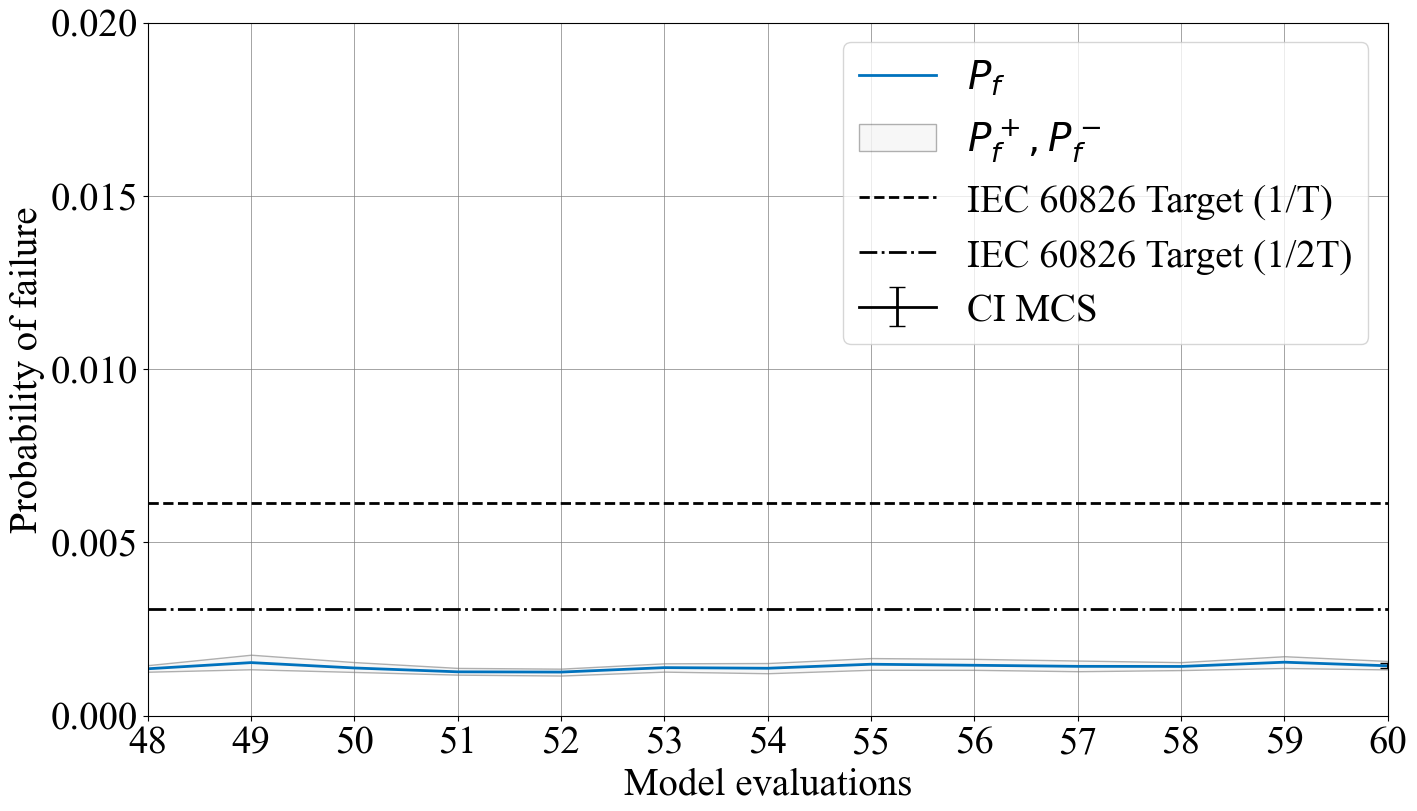

In [43]:
results_plot(Results, History, Params, FILE_NAME)

## LOAD

In [44]:
def pickle_load(results_file, history_file, params_file):
    # Load data
    Results = None
    History = None

    with open(results_file, 'rb') as Results_file:
        # Serialize and write the variable to the file
        Results = pickle.load(Results_file)

    with open(history_file, 'rb') as History_file:
        # Serialize and write the variable to the file
        History = pickle.load(History_file)

    with open(params_file, 'rb') as Params_file:
        # Serialize and write the variable to the file
        Params = pickle.load(Params_file)

    return Results, History, Params